# <font color=darkgreen>Análisis de los patrones de movilidad residencial en España<br>mediante árboles de clasificación
</font>

### <font color=darkgreen>Trabajo de Fin de [Máster en Data Science](https://masterdatascience.ifca.es/)</font>  
### <font color=darkgreen>© Autor: Matin Khakpour</font>

## <font color=darkgreen>Capítulo 4: Aplicaciones de aprendizaje automático</font>    

Para el aprendizaje automático partimos de esta pregunta:  

<h3><center><font color=darkblue>Si alguien se muda a una capital de provincia,<br>¿Cuáles son los factores más influyentes/predictivos que podemos deducir tanto de sus características personales como de las características municipales de su origen?</font></center></h3>

Para este caso, entre la panoplia de métodos de Machine Learning, usaremos los árboles de clasificación porque:
- Manejan bien la mezcla de variables categóricas y contínuas sin necesitar mucho preprocesamiento
- La estructura del árbol expresa explícitamente la jerarquía de las variables influyentes
- Son fácilmente interpretables/legibles

### Preparación del dataset para el modelo
Primero tenemos que preparar un dataset de entrada para el modelo. Del dataset gigante de la fase 2 sacamos como variables independientes/predictores (las X) todas las varibales personales + variables del municipio de BAJA. Como variable dependiente/objetivo (la Y) covertimos TAMUALTA == 6 en variable binaria (capital frente a otros tipos de municipio).

In [1]:
db_joined <- read.csv(choose.files())

Chequear los nulos de las variables pertinentes a EVR que no podremos usar:

In [20]:
colnames(db_joined[1:18])[apply(db_joined[1:18], 2, anyNA)]

[1] "MUNINAC"  "TAMUNACI"

In [2]:
str(db_joined)

'data.frame':	1649351 obs. of  162 variables:
 $ SEXO                  : Factor w/ 2 levels "M","V": 2 1 2 2 1 1 2 2 1 1 ...
 $ EDAD                  : int  4 1 36 26 37 75 14 11 28 9 ...
 $ MESVAR                : int  7 7 3 5 6 1 9 1 12 1 ...
 $ CNAC                  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ BPROVNAC              : int  0 0 0 0 0 0 0 0 0 0 ...
 $ PROVNAC               : int  1 1 1 1 1 1 1 1 1 1 ...
 $ MUNINAC               : int  NA NA NA NA NA NA NA NA NA NA ...
 $ TAMUNACI              : int  1 1 1 1 1 1 1 1 1 1 ...
 $ PROVALTA              : int  1 1 1 1 1 1 1 1 1 1 ...
 $ MUNIALTA              : int  999 999 999 59 59 59 59 59 59 59 ...
 $ IDMUNIALTA            : int  1999 1999 1999 1059 1059 1059 1059 1059 1059 1059 ...
 $ TAMUALTA              : int  1 1 1 6 6 6 6 6 6 6 ...
 $ ARRALTA               : int  1 1 1 1 1 1 1 1 1 1 ...
 $ PROVBAJA              : int  1 1 1 1 1 1 1 1 1 1 ...
 $ MUNIBAJA              : int  999 999 999 999 999 999 999 999 999 999 ...
 $ IDMUNIB

Las variables categóricas han cambiado de tipo al guaradar en formato CSV al final de la fase anterior (al parecer, deberíamos asignar las etiquetas explícitamente para evitar eso.)  
De nuevo, convertimos las variables necesarias a categórica:

In [2]:
db_joined$MESVAR <- as.factor(db_joined$MESVAR)

db_joined$CNAC <- as.factor(db_joined$CNAC)

db_joined$BPROVNAC <- as.factor(db_joined$BPROVNAC)

db_joined$TAMUBAJA <- as.factor(db_joined$TAMUBAJA)

db_joined$ARRBAJA <- as.factor(db_joined$ARRBAJA)

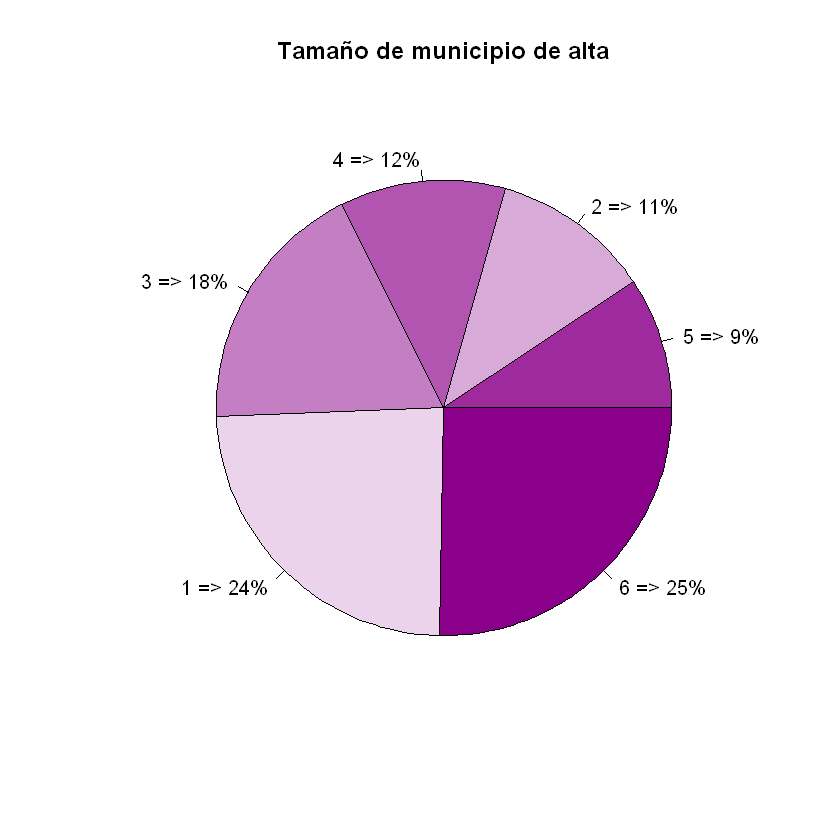

In [3]:
# ver las proporciones en la versión anterior a la binarización

db_joined$TAMUALTA <- as.factor(db_joined$TAMUALTA)

aux <- sort(table(db_joined$TAMUALTA))
aux <- as.data.frame(aux)

colfunc <- colorRampPalette(c("white","darkmagenta"))(7)

slices <- aux$Freq
lbl <- aux$Var1
pct <- round(slices/sum(slices)*100)
lbl <- paste(lbl, "=>", pct)
lbl <- paste(lbl,"%", sep="")
pie(slices, labels = lbl, col = c(colfunc[6],colfunc[3],colfunc[5],colfunc[4],colfunc[2],colfunc[7]),
    main="Tamaño de municipio de alta")

En el caso de TAMUALTA, creamos una nueva variable binaria:
- CAP si el MUNIALTA es capital de provincia.
- NoCAP si el MUNIALTA no es capital de provincia.

In [10]:
db_joined$ALTA_CAPITAL <- as.factor(ifelse(db_joined$TAMUALTA == 6, "CAP", "NoCAP"))

Comprobar las proporciones de la variable objetivo binaria:

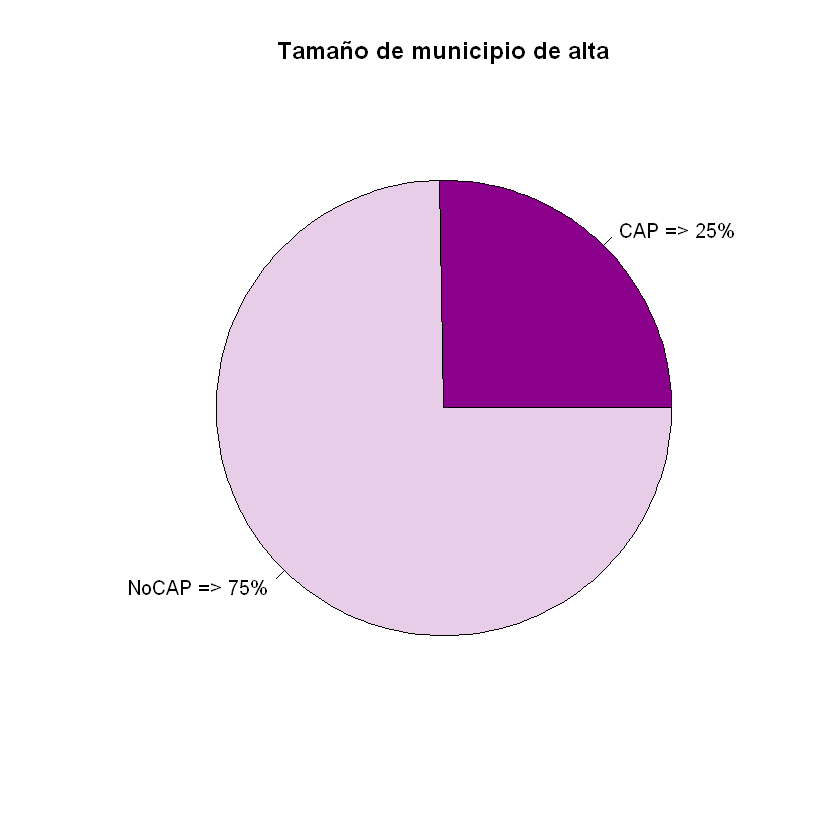

In [24]:
aux <- sort(table(db_joined$ALTA_CAPITAL))
aux <- as.data.frame(aux)

slices <- aux$Freq
lbl <- aux$Var1
pct <- round(slices/sum(slices)*100)
lbl <- paste(lbl, "=>", pct)
lbl <- paste(lbl,"%", sep="")
pie(slices, labels = lbl, col = c("darkmagenta", coltransp),
    main="Tamaño de municipio de alta")

Para evitar sesgos, en la entrada de este modelo, solo escogemos variables relacionadas con el municipio de BAJA.  
La razón es que, si a la vez introducimos datos de ambos municipios de ALTA y BAJA, como la variable objetivo es del municipio de ALTA, puede que el modelo esté buscando relaciones entre las variables X de ALTA y relacionarlo con la Y de ALTA, absteniendo así las de BAJA.

In [4]:
# crear un índice de columnas con la palabra BAJA

baja <- grepl("BAJA", names(db_joined), fixed = TRUE)

In [5]:
names(db_joined)[baja]

[1] "PROVBAJA"               "MUNIBAJA"               "IDMUNIBAJA"            
 [4] "TAMUBAJA"               "ARRBAJA"                "BAJA_POB2020"          
 [7] "BAJA_VAR2020"           "BAJA_MUJ2020"           "BAJA_IMASC20"          
[10] "BAJA_TC16A20"           "BAJA_PT0A4"             "BAJA_PT5A9"            
[13] "BAJA_PT10A14"           "BAJA_PT15A19"           "BAJA_PT20A24"          
[16] "BAJA_PT25A29"           "BAJA_PT30A34"           "BAJA_PT35A39"          
[19] "BAJA_PT40A44"           "BAJA_PT45A49"           "BAJA_PT50A54"          
[22] "BAJA_PT55A59"           "BAJA_PT60A64"           "BAJA_PT65A69"          
[25] "BAJA_PT70A74"           "BAJA_PT75A79"           "BAJA_PT80A84"          
[28] "BAJA_PT85A89"           "BAJA_PT90A94"           "BAJA_PT95A99"          
[31] "BAJA_PT100YM"           "BAJA_JOVEN"             "BAJA_ADULT"            
[34] "BAJA_MAYOR"             "BAJA_PRJOV"             "BAJA_PRAD"             
[37] "BAJA_PRMAY"             "BAJA_TDEP"              "BAJA_IDEPJOV"          
[40] "BAJA_IDEPMAY"           "BAJA_NACIM"             "BAJA_MUFET"            
[43] "BAJA_MATRIM"            "BAJA_FALLEC"            "BAJA_CV"               
[46] "BAJA_EDIFIC"            "BAJA_INMUEB"            "BAJA_RATINEDIF"        
[49] "BAJA_VIVFAM"            "BAJA_VIVPRIN"           "BAJA_VIVNOPR"          
[52] "BAJA_PRVPRIN"           "BAJA_PRVNPRIN"          "BAJA_OCTC"             
[55] "BAJA_OCTP"              "BAJA_PARTA"             "BAJA_PARPE"            
[58] "BAJA_INVPERM"           "BAJA_JUBPENS"           "BAJA_ESTUD"            
[61] "BAJA_OCUOTR"            "BAJA_PRIMARIO"          "BAJA_CONSTRU"          
[64] "BAJA_INDUSTR"           "BAJA_NOAPLI"            "BAJA_SERVICIOS"        
[67] "BAJA_TOTRAMAS"          "BAJA_PRPRIM"            "BAJA_PRSEC"            
[70] "BAJA_PRSERVIC"          "BAJA_AREAKM2"           "BAJA_PENDIENTE_GRADOS" 
[73] "BAJA_ALTITUD_M"         "BAJA_DISTNUC10KM_M"     "BAJA_DISTAUTOPAUTOV_M" 
[76] "BAJA_DISTCARRNAC_M"     "BAJA_DISTESTACFERROC_M"

De las columnas de arriba, tenemos que eliminar PROVBAJA, MUNIBAJA y IDMUNIBAJA porque, tal como PROVNAC, tienen más de 32 niveles (el límite de predictores categóricas en R).

In [9]:
# eliminar tres de las columnas BAJA

baja_ind <- names(db_joined)[baja][-c(1,2,3)]
baja_ind

[1] "TAMUBAJA"               "ARRBAJA"                "BAJA_POB2020"          
 [4] "BAJA_VAR2020"           "BAJA_MUJ2020"           "BAJA_IMASC20"          
 [7] "BAJA_TC16A20"           "BAJA_PT0A4"             "BAJA_PT5A9"            
[10] "BAJA_PT10A14"           "BAJA_PT15A19"           "BAJA_PT20A24"          
[13] "BAJA_PT25A29"           "BAJA_PT30A34"           "BAJA_PT35A39"          
[16] "BAJA_PT40A44"           "BAJA_PT45A49"           "BAJA_PT50A54"          
[19] "BAJA_PT55A59"           "BAJA_PT60A64"           "BAJA_PT65A69"          
[22] "BAJA_PT70A74"           "BAJA_PT75A79"           "BAJA_PT80A84"          
[25] "BAJA_PT85A89"           "BAJA_PT90A94"           "BAJA_PT95A99"          
[28] "BAJA_PT100YM"           "BAJA_JOVEN"             "BAJA_ADULT"            
[31] "BAJA_MAYOR"             "BAJA_PRJOV"             "BAJA_PRAD"             
[34] "BAJA_PRMAY"             "BAJA_TDEP"              "BAJA_IDEPJOV"          
[37] "BAJA_IDEPMAY"           "BAJA_NACIM"             "BAJA_MUFET"            
[40] "BAJA_MATRIM"            "BAJA_FALLEC"            "BAJA_CV"               
[43] "BAJA_EDIFIC"            "BAJA_INMUEB"            "BAJA_RATINEDIF"        
[46] "BAJA_VIVFAM"            "BAJA_VIVPRIN"           "BAJA_VIVNOPR"          
[49] "BAJA_PRVPRIN"           "BAJA_PRVNPRIN"          "BAJA_OCTC"             
[52] "BAJA_OCTP"              "BAJA_PARTA"             "BAJA_PARPE"            
[55] "BAJA_INVPERM"           "BAJA_JUBPENS"           "BAJA_ESTUD"            
[58] "BAJA_OCUOTR"            "BAJA_PRIMARIO"          "BAJA_CONSTRU"          
[61] "BAJA_INDUSTR"           "BAJA_NOAPLI"            "BAJA_SERVICIOS"        
[64] "BAJA_TOTRAMAS"          "BAJA_PRPRIM"            "BAJA_PRSEC"            
[67] "BAJA_PRSERVIC"          "BAJA_AREAKM2"           "BAJA_PENDIENTE_GRADOS" 
[70] "BAJA_ALTITUD_M"         "BAJA_DISTNUC10KM_M"     "BAJA_DISTAUTOPAUTOV_M" 
[73] "BAJA_DISTCARRNAC_M"     "BAJA_DISTESTACFERROC_M"

Escoger las columnas de datos personales + seleccionados de BAJA + variable objetivo:

In [11]:
selection <- c("SEXO","EDAD","MESVAR","CNAC","BPROVNAC","ARRALTA",  # variables personales
               baja_ind,  # variables municipales de BAJA 
               "ALTA_CAPITAL"  # variable objetivo
               )

In [12]:
db_joined <- db_joined[selection]

In [13]:
names(db_joined)

[1] "SEXO"                   "EDAD"                   "MESVAR"                
 [4] "CNAC"                   "BPROVNAC"               "TAMUBAJA"              
 [7] "ARRBAJA"                "BAJA_POB2020"           "BAJA_VAR2020"          
[10] "BAJA_MUJ2020"           "BAJA_IMASC20"           "BAJA_TC16A20"          
[13] "BAJA_PT0A4"             "BAJA_PT5A9"             "BAJA_PT10A14"          
[16] "BAJA_PT15A19"           "BAJA_PT20A24"           "BAJA_PT25A29"          
[19] "BAJA_PT30A34"           "BAJA_PT35A39"           "BAJA_PT40A44"          
[22] "BAJA_PT45A49"           "BAJA_PT50A54"           "BAJA_PT55A59"          
[25] "BAJA_PT60A64"           "BAJA_PT65A69"           "BAJA_PT70A74"          
[28] "BAJA_PT75A79"           "BAJA_PT80A84"           "BAJA_PT85A89"          
[31] "BAJA_PT90A94"           "BAJA_PT95A99"           "BAJA_PT100YM"          
[34] "BAJA_JOVEN"             "BAJA_ADULT"             "BAJA_MAYOR"            
[37] "BAJA_PRJOV"             "BAJA_PRAD"              "BAJA_PRMAY"            
[40] "BAJA_TDEP"              "BAJA_IDEPJOV"           "BAJA_IDEPMAY"          
[43] "BAJA_NACIM"             "BAJA_MUFET"             "BAJA_MATRIM"           
[46] "BAJA_FALLEC"            "BAJA_CV"                "BAJA_EDIFIC"           
[49] "BAJA_INMUEB"            "BAJA_RATINEDIF"         "BAJA_VIVFAM"           
[52] "BAJA_VIVPRIN"           "BAJA_VIVNOPR"           "BAJA_PRVPRIN"          
[55] "BAJA_PRVNPRIN"          "BAJA_OCTC"              "BAJA_OCTP"             
[58] "BAJA_PARTA"             "BAJA_PARPE"             "BAJA_INVPERM"          
[61] "BAJA_JUBPENS"           "BAJA_ESTUD"             "BAJA_OCUOTR"           
[64] "BAJA_PRIMARIO"          "BAJA_CONSTRU"           "BAJA_INDUSTR"          
[67] "BAJA_NOAPLI"            "BAJA_SERVICIOS"         "BAJA_TOTRAMAS"         
[70] "BAJA_PRPRIM"            "BAJA_PRSEC"             "BAJA_PRSERVIC"         
[73] "BAJA_AREAKM2"           "BAJA_PENDIENTE_GRADOS"  "BAJA_ALTITUD_M"        
[76] "BAJA_DISTNUC10KM_M"     "BAJA_DISTAUTOPAUTOV_M"  "BAJA_DISTCARRNAC_M"    
[79] "BAJA_DISTESTACFERROC_M" "ALTA_CAPITAL"

In [14]:
# renombrar el dataset

db.baja <- db_joined

# rm(db_joined)

In [15]:
dim(db.baja)

[1] 1649351      80

Como el número de registros de este dataset es demasiado grande, truncamos el número de filas a 10,000 aleatoriamente:

In [16]:
set.seed(1)

rows = sample(1:nrow(db.baja), 10000)
db.baja <- db.baja[rows,]
rownames(db.baja) <- NULL

dim(db.baja)

[1] 10000    80

In [24]:
# Guardamos esta versión del dataset

write.csv(db.baja, "db_baja.csv", row.names = FALSE)

In [1]:
# db.baja <- read.csv(choose.files())
# db.baja$MESVAR <- as.factor(db.baja$MESVAR)
# db.baja$CNAC <- as.factor(db.baja$CNAC)
# db.baja$BPROVNAC <- as.factor(db.baja$BPROVNAC)
# db.baja$TAMUBAJA <- as.factor(db.baja$TAMUBAJA)
# db.baja$ARRBAJA <- as.factor(db.baja$ARRBAJA)

Luego lo dividimos en train / test:

In [58]:
n = nrow(db.baja)

indtrain = sample(1:n, 0.8*n)     # 80% para train
indtest = setdiff(1:n, indtrain)  # 20% para test

db.train = db.baja[indtrain,]
rownames(db.train) <- NULL

db.test = db.baja[indtest,]
rownames(db.test) <- NULL

### Análisis pre-ML
Antes de crear el modelo, hacemos unos análisis estadísticos para conocer mejor las variables y sus relaciones.

In [13]:
head(db.baja)

SEXO,EDAD,MESVAR,CNAC,BPROVNAC,TAMUBAJA,ARRBAJA,BAJA_POB2020,BAJA_VAR2020,BAJA_MUJ2020,...,BAJA_PRSEC,BAJA_PRSERVIC,BAJA_AREAKM2,BAJA_PENDIENTE_GRADOS,BAJA_ALTITUD_M,BAJA_DISTNUC10KM_M,BAJA_DISTAUTOPAUTOV_M,BAJA_DISTCARRNAC_M,BAJA_DISTESTACFERROC_M,ALTA_CAPITAL
V,45,5,1,1,1,3,2214,1114,1100,...,30.60318,59.66672,35.46262,6.128889,311.5101,11998.500,8264.007,8172.180,8642.144,CAP
V,2,7,0,0,6,1,87484,42091,45393,...,22.29034,75.99769,235.30000,4.151902,818.7285,8487.562,5074.398,6734.161,18042.856,NoCAP
V,88,5,0,0,6,1,1664182,790708,873474,...,17.26236,82.17585,99.50000,5.413368,106.1421,3219.881,1528.045,6497.181,1722.347,NoCAP
M,37,4,0,1,2,3,10133,5142,4991,...,37.13355,51.03149,184.80000,6.125706,361.8710,17179.485,15023.941,17200.857,9696.234,CAP
M,26,6,0,0,2,1,17323,8409,8914,...,38.47875,59.11633,68.60000,7.676886,143.8180,17609.827,2919.113,3128.709,3078.404,NoCAP
V,12,6,0,0,4,1,58978,29149,29829,...,22.84247,74.88819,40.60000,3.413221,209.8724,4266.448,1627.622,9055.118,4362.129,CAP


Separar las variables categóricas y numéricas:

In [29]:
str(db.baja[c(80,1,3,4,5,6,7)])

'data.frame':	10000 obs. of  7 variables:
 $ ALTA_CAPITAL: Factor w/ 2 levels "CAP","NoCAP": 1 2 2 1 2 1 1 2 2 2 ...
 $ SEXO        : Factor w/ 2 levels "M","V": 2 2 2 1 1 2 2 1 2 1 ...
 $ MESVAR      : Factor w/ 12 levels "1","2","3","4",..: 5 7 5 4 6 6 4 10 10 10 ...
 $ CNAC        : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 2 2 2 1 ...
 $ BPROVNAC    : Factor w/ 2 levels "0","1": 2 1 1 2 1 1 2 2 1 1 ...
 $ TAMUBAJA    : Factor w/ 6 levels "1","2","3","4",..: 1 6 6 2 2 4 6 4 6 3 ...
 $ ARRBAJA     : Factor w/ 3 levels "1","2","3": 3 1 1 3 1 1 3 3 1 2 ...


In [14]:
cat <- colnames(db.baja)[c(80,1,3,4,5,6,7)]
db.cat <- db.baja[cat]

In [31]:
head(db.cat)

ALTA_CAPITAL,SEXO,MESVAR,CNAC,BPROVNAC,TAMUBAJA,ARRBAJA
CAP,V,5,1,1,1,3
NoCAP,V,7,0,0,6,1
NoCAP,V,5,0,0,6,1
CAP,M,4,0,1,2,3
NoCAP,M,6,0,0,2,1
CAP,V,6,0,0,4,1


In [17]:
num <- colnames(db.baja)[-c(80,1,3,4,5,6,7)]
db.num <- db.baja[c("ALTA_CAPITAL",num)]

In [5]:
head(db.num)

ALTA_CAPITAL,EDAD,BAJA_POB2020,BAJA_VAR2020,BAJA_MUJ2020,BAJA_IMASC20,BAJA_TC16A20,BAJA_PT0A4,BAJA_PT5A9,BAJA_PT10A14,...,BAJA_PRPRIM,BAJA_PRSEC,BAJA_PRSERVIC,BAJA_AREAKM2,BAJA_PENDIENTE_GRADOS,BAJA_ALTITUD_M,BAJA_DISTNUC10KM_M,BAJA_DISTAUTOPAUTOV_M,BAJA_DISTCARRNAC_M,BAJA_DISTESTACFERROC_M
CAP,45,2214,1114,1100,105.42020,-0.2478419,86,110,119,...,9.7301008,30.60318,59.66672,35.46262,6.128889,311.5101,11998.500,8264.007,8172.180,8642.144
NoCAP,2,87484,42091,45393,92.72575,1.1511604,4087,4588,4797,...,1.7119722,22.29034,75.99769,235.30000,4.151902,818.7285,8487.562,5074.398,6734.161,18042.856
NoCAP,88,1664182,790708,873474,90.52450,0.8614784,65216,68697,70359,...,0.5617911,17.26236,82.17585,99.50000,5.413368,106.1421,3219.881,1528.045,6497.181,1722.347
CAP,37,10133,5142,4991,103.02545,-0.3286911,430,489,481,...,11.8349620,37.13355,51.03149,184.80000,6.125706,361.8710,17179.485,15023.941,17200.857,9696.234
NoCAP,26,17323,8409,8914,94.33475,0.5260521,655,758,984,...,2.4049217,38.47875,59.11633,68.60000,7.676886,143.8180,17609.827,2919.113,3128.709,3078.404
CAP,12,58978,29149,29829,97.72034,0.9975315,2603,3367,3614,...,2.2693391,22.84247,74.88819,40.60000,3.413221,209.8724,4266.448,1627.622,9055.118,4362.129


Mapa de correlación entre predictores numéricos:

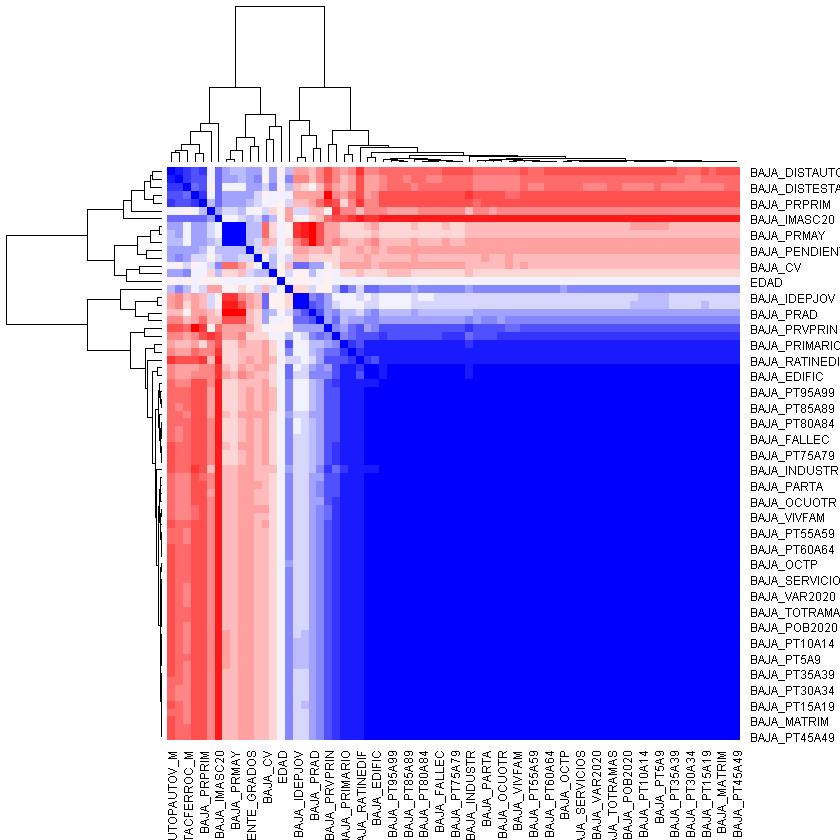

In [16]:
xCorr <- cor(db.num[-1], method = "spearman")
col <- colorRampPalette(c("red", "white", "blue"))(20)
heatmap(x = xCorr, col = col, symm = TRUE)

Correlación entre los predictores numéricos y la variable objetivo:

[1] 55

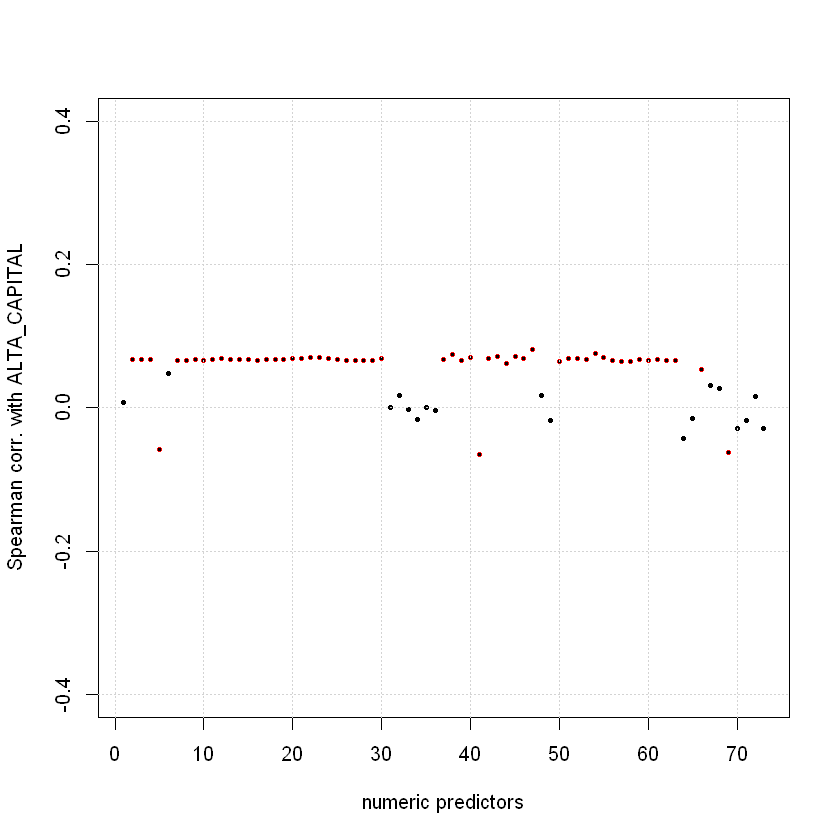

In [21]:
x = db.num[-1]
y = as.numeric(unlist(db.num[1]))

r.xy = c()

for (ivar in 1:ncol(x)) {
  r.xy[ivar] = cor(y, x[,ivar], method = "spearman")
}

plot(r.xy, ylim = c(-0.4, 0.4), pch = 19, cex = 0.5, 
     xlab = "numeric predictors", ylab = "Spearman corr. with ALTA_CAPITAL")
grid()

ind.sele = which(abs(r.xy) > 0.05)
points(ind.sele, r.xy[ind.sele], col = "red", cex = 0.5)
length(ind.sele)

Análisis de Componentes Principales para variables numéricas:

In [36]:
# aplicar PCA con normalización
pca <- prcomp(db.num[-1], center=TRUE, scale.=TRUE)

summary(pca)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6    PC7
Standard deviation     7.1590 2.8491 1.67272 1.49896 1.11479 1.04004 1.0108
Proportion of Variance 0.7021 0.1112 0.03833 0.03078 0.01702 0.01482 0.0140
Cumulative Proportion  0.7021 0.8133 0.85160 0.88238 0.89940 0.91422 0.9282
                           PC8     PC9    PC10   PC11    PC12    PC13    PC14
Standard deviation     0.97994 0.88767 0.84017 0.7688 0.68786 0.61690 0.59044
Proportion of Variance 0.01315 0.01079 0.00967 0.0081 0.00648 0.00521 0.00478
Cumulative Proportion  0.94137 0.95217 0.96184 0.9699 0.97642 0.98163 0.98640
                          PC15   PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.55993 0.4908 0.39260 0.37995 0.21685 0.16255 0.11518
Proportion of Variance 0.00429 0.0033 0.00211 0.00198 0.00064 0.00036 0.00018
Cumulative Proportion  0.99070 0.9940 0.99611 0.99809 0.99873 0.99909 0.99928
                          PC22    PC23    PC24

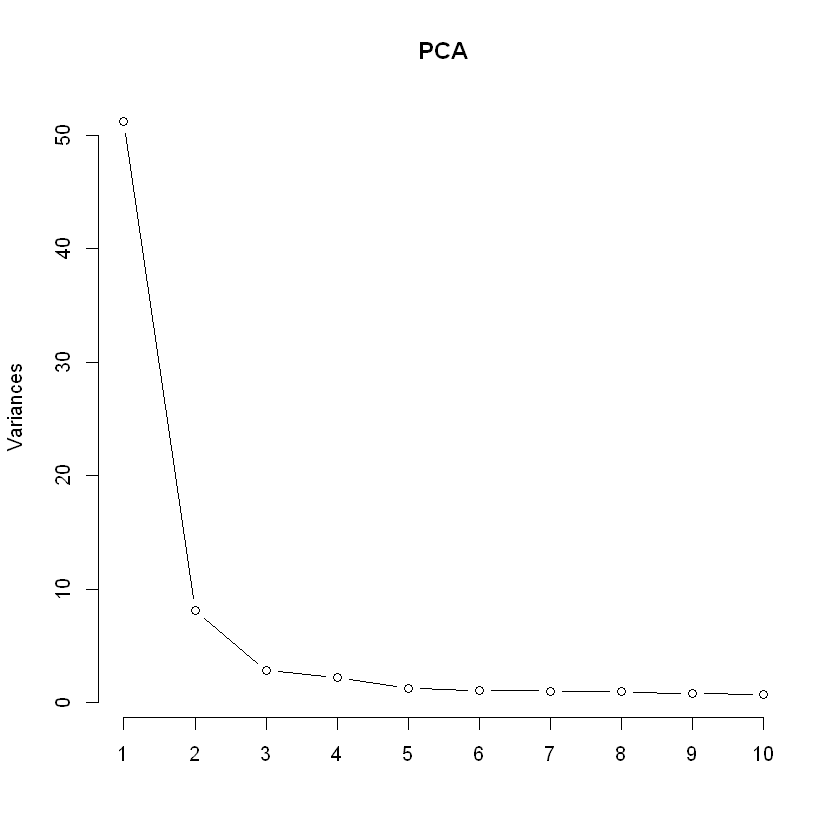

In [38]:
screeplot(pca, type="lines", main="PCA")

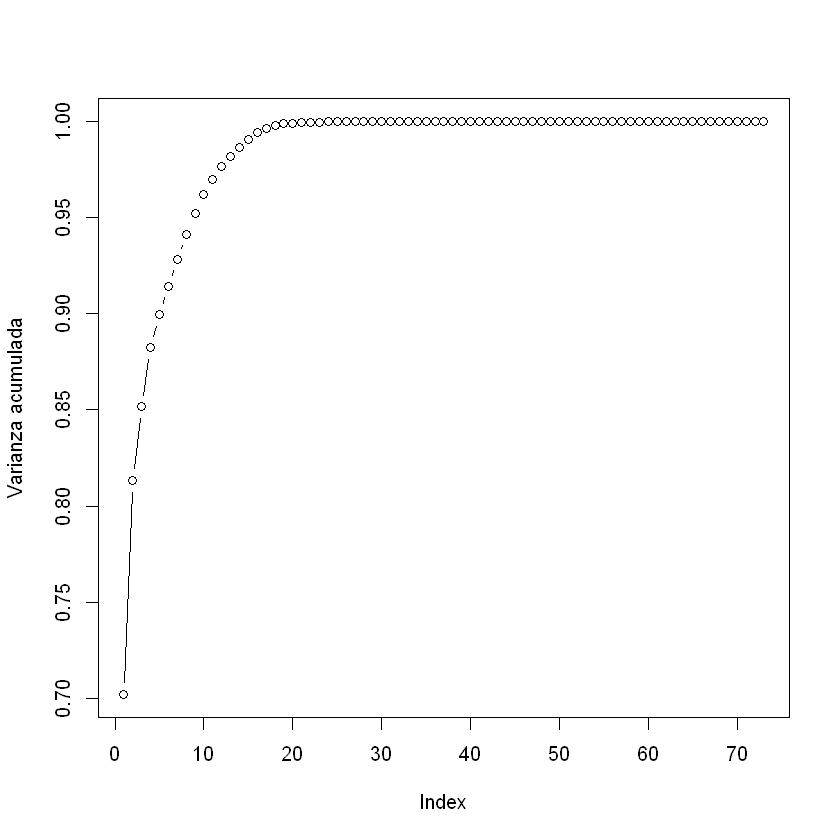

In [39]:
lambdas <- pca$sdev^2

plot(cumsum(lambdas)/sum(lambdas), type="b", ylab="Varianza acumulada")

### Crear un árbol de decisión
#### Paquete Tree

In [26]:
library(tree)

In [59]:
arbol = tree(ALTA_CAPITAL~., db.train)

In [60]:
arbol

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

1) root 8000 9032 NoCAP ( 0.252 0.748 ) *

#### Forzar el crecimiento del árbol compelto

In [62]:
arbol = tree(ALTA_CAPITAL~., db.train,
             control=tree.control(nobs=nrow(db.train), mincut = 1, mindev = 0))

In [63]:
summary(arbol)


Classification tree:
tree(formula = ALTA_CAPITAL ~ ., data = db.train, control = tree.control(nobs = nrow(db.train), 
    mincut = 1, mindev = 0))
Variables actually used in tree construction:
 [1] "BAJA_POB2020"           "BAJA_PRMAY"             "BAJA_PENDIENTE_GRADOS" 
 [4] "EDAD"                   "BAJA_INVPERM"           "BAJA_PT90A94"          
 [7] "BAJA_IMASC20"           "BAJA_DISTESTACFERROC_M" "BAJA_TC16A20"          
[10] "MESVAR"                 "BAJA_CONSTRU"           "BAJA_PT95A99"          
[13] "BAJA_PT40A44"           "CNAC"                   "BAJA_DISTCARRNAC_M"    
[16] "BAJA_PT100YM"           "BAJA_PT25A29"           "BAJA_PT75A79"          
[19] "ARRBAJA"                "BAJA_PRVPRIN"           "BAJA_VIVNOPR"          
[22] "BAJA_CV"                "BAJA_DISTNUC10KM_M"     "BAJA_IDEPJOV"          
[25] "BAJA_PT70A74"           "BAJA_MUJ2020"           "BAJA_FALLEC"           
[28] "SEXO"                   "BAJA_PT10A14"           "BAJA_AREAKM2"          
[31] "

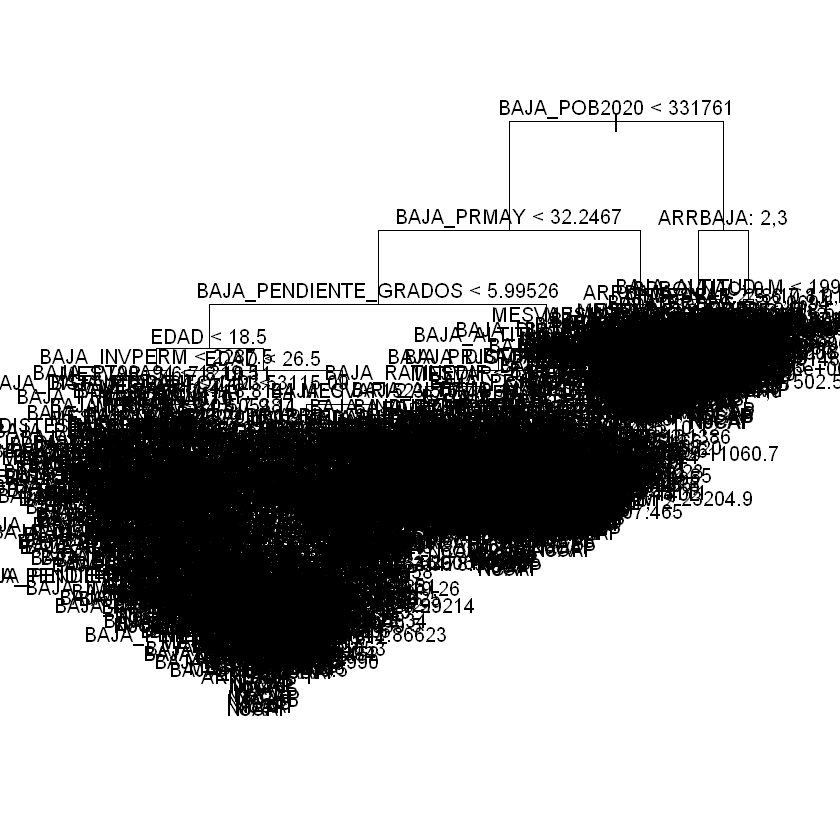

In [65]:
plot(arbol,)
text(arbol, pretty=0)

#### Predicción y Test Accuracy

In [66]:
pred <- predict(arbol, db.test, type="class")

In [68]:
table(pred, db.test$ALTA_CAPITAL)

       
pred     CAP NoCAP
  CAP    151   363
  NoCAP  380  1106

In [25]:
acc.class = function(x,y){
  stopifnot(length(x) == length(y))
  return(sum(diag(table(x,y))) / length(x))
}

In [70]:
acc.class(pred, db.test$ALTA_CAPITAL)

[1] 0.6285

#### Podar el árbol (fallido!)

In [ ]:
cv.arbol <- cv.tree(arbol, FUN = prune.misclass, k=5)

       Length Class  Mode     
size   439    -none- numeric  
dev    439    -none- numeric  
k      439    -none- numeric  
method   1    -none- character

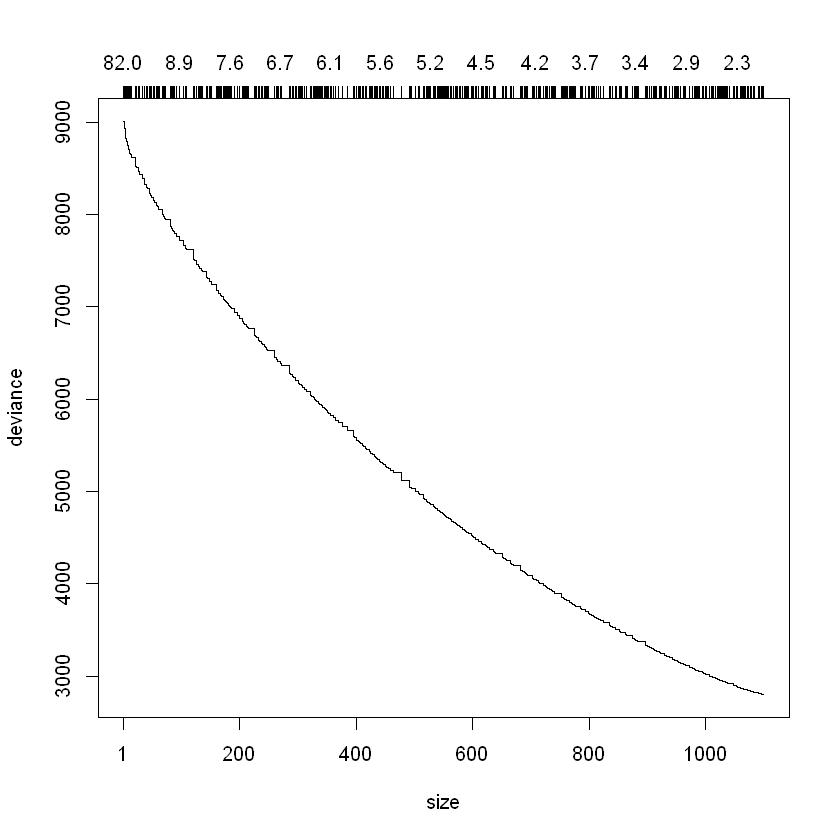

In [84]:
pt <- prune.tree(arbol)
summary(pt)
plot(pt)

#### Paquete `rpart`

In [ ]:
library(caret)
library(rpart)
library(rpart.plot)
library(RColorBrewer)
library(rattle)

#### Árbol completo

In [88]:
modelo = rpart(ALTA_CAPITAL~.,
               data = db.train,
               method = "class",
               control = rpart.control(minsplit = 2, minbucket = 1, cp = 0)
              )

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

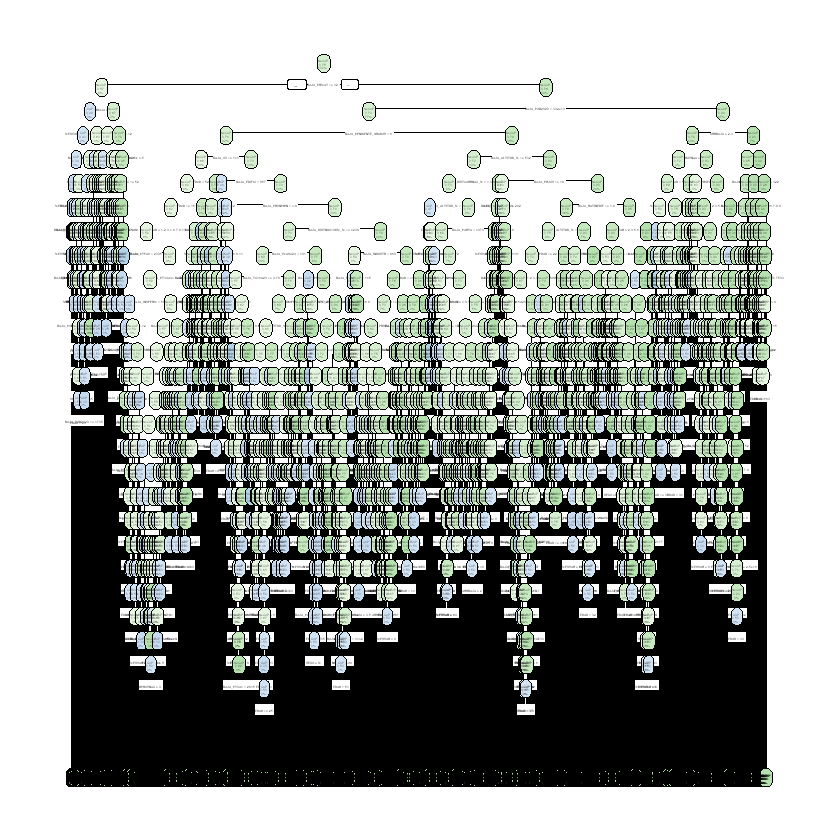

In [90]:
rpart.plot(modelo)

### Accuracy de predicción:

#### - Train

In [91]:
pred.train = predict(modelo, db.train, type = "class")

In [92]:
acc.class(pred.train, db.train$ALTA_CAPITAL)

[1] 0.998125

#### - Test

In [93]:
pred.test = predict(modelo, db.test, type = "class")

In [94]:
acc.class(pred.test, db.test$ALTA_CAPITAL)

[1] 0.634

#### Podar el árbol

In [89]:
printcp(modelo)


Classification tree:
rpart(formula = ALTA_CAPITAL ~ ., data = db.train, method = "class", 
    control = rpart.control(minsplit = 2, minbucket = 1, cp = 0))

Variables actually used in tree construction:
 [1] ARRBAJA                BAJA_ALTITUD_M         BAJA_AREAKM2          
 [4] BAJA_CONSTRU           BAJA_CV                BAJA_DISTAUTOPAUTOV_M 
 [7] BAJA_DISTCARRNAC_M     BAJA_DISTESTACFERROC_M BAJA_DISTNUC10KM_M    
[10] BAJA_EDIFIC            BAJA_FALLEC            BAJA_IDEPJOV          
[13] BAJA_IDEPMAY           BAJA_IMASC20           BAJA_INDUSTR          
[16] BAJA_INMUEB            BAJA_INVPERM           BAJA_MATRIM           
[19] BAJA_MUFET             BAJA_MUJ2020           BAJA_NACIM            
[22] BAJA_OCUOTR            BAJA_PARPE             BAJA_PARTA            
[25] BAJA_PENDIENTE_GRADOS  BAJA_POB2020           BAJA_PRAD             
[28] BAJA_PRIMARIO          BAJA_PRJOV             BAJA_PRMAY            
[31] BAJA_PRPRIM            BAJA_PRSEC             BAJA

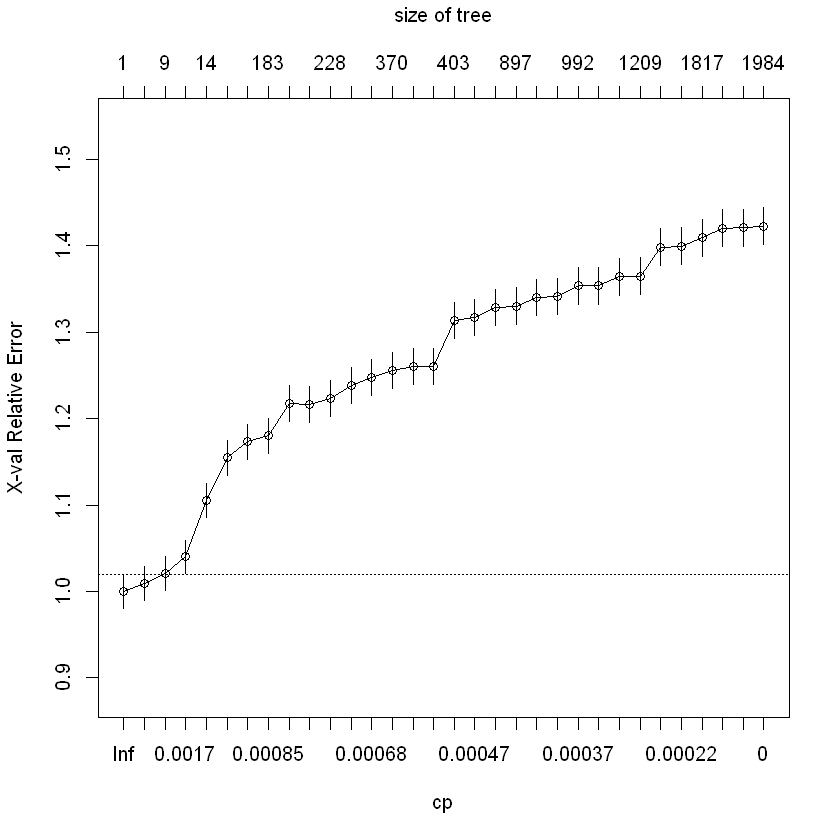

In [122]:
plotcp(modelo)

In [111]:
ptree <- prune(modelo,
               cp = modelo$cptable[which.min(modelo$cptable[,"xerror"]),"CP"])

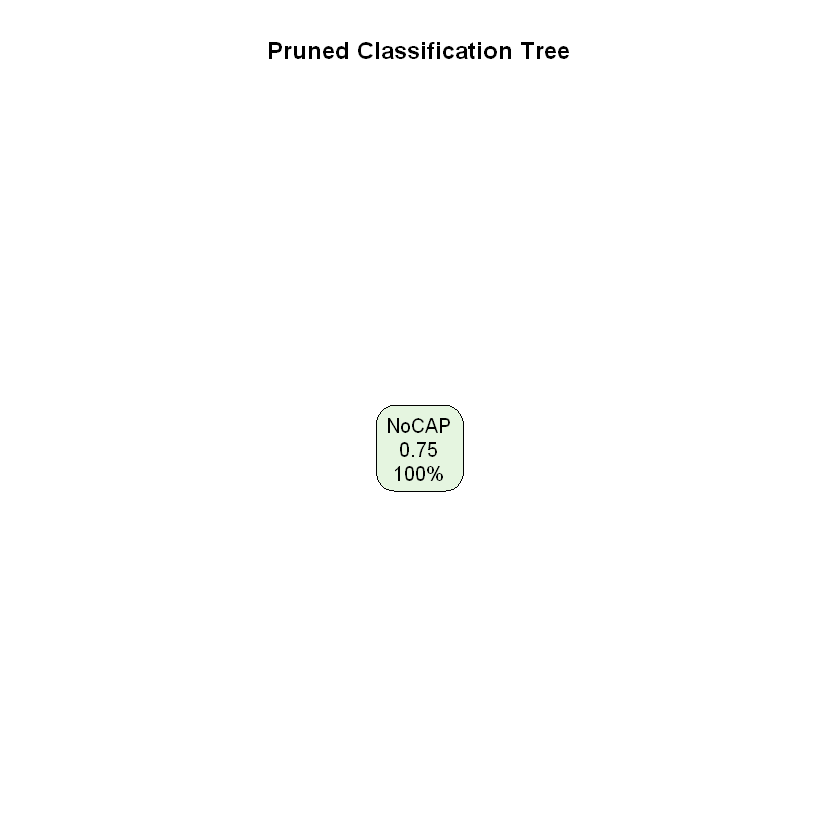

In [113]:
rpart.plot(ptree, uniform=TRUE, main="Pruned Classification Tree")

#### Probar con menos observaciones

In [116]:
mini = rpart(ALTA_CAPITAL~.,
               data = db.train[1:300,],
               method = "class",
               control = rpart.control(minsplit = 2, minbucket = 1, cp = 0)
              )

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

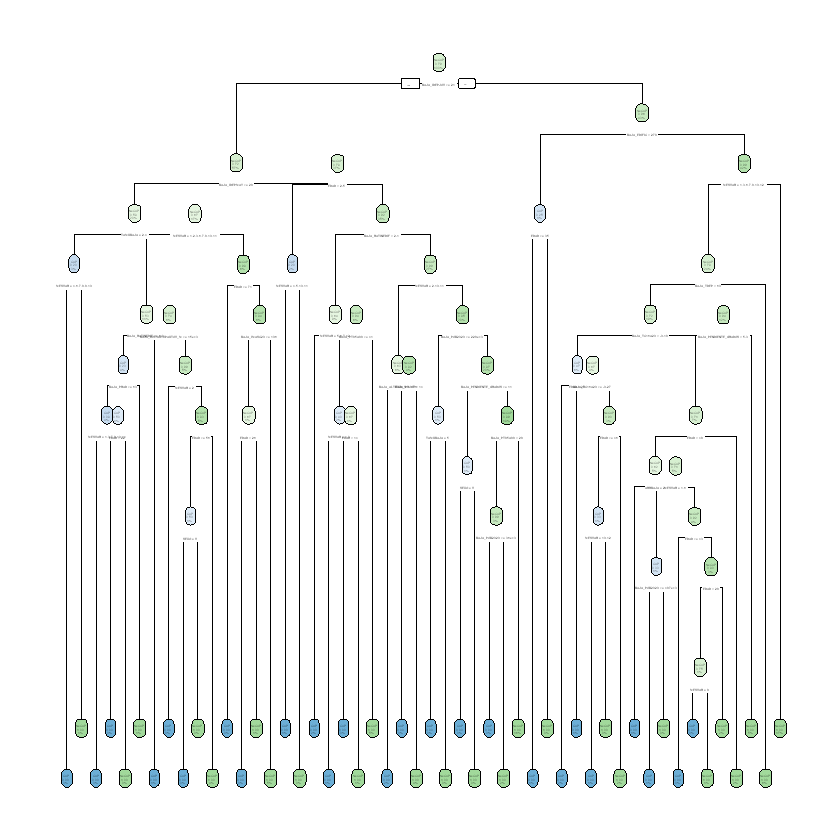

In [118]:
rpart.plot(mini, roundint=FALSE)

In [120]:
printcp(mini)


Classification tree:
rpart(formula = ALTA_CAPITAL ~ ., data = db.train[1:300, ], method = "class", 
    control = rpart.control(minsplit = 2, minbucket = 1, cp = 0))

Variables actually used in tree construction:
 [1] ARRBAJA               BAJA_ALTITUD_M        BAJA_DISTAUTOPAUTOV_M
 [4] BAJA_EDIFIC           BAJA_IDEPJOV          BAJA_IDEPMAY         
 [7] BAJA_IMASC20          BAJA_PENDIENTE_GRADOS BAJA_POB2020         
[10] BAJA_PRAD             BAJA_PRJOV            BAJA_PT95A99         
[13] BAJA_RATINEDIF        BAJA_TC16A20          BAJA_TDEP            
[16] EDAD                  MESVAR                SEXO                 
[19] TAMUBAJA             

Root node error: 66/300 = 0.22

n= 300 

         CP nsplit rel error xerror    xstd
1 0.0397727      0   1.00000 1.0000 0.10871
2 0.0303030     11   0.53030 1.1970 0.11559
3 0.0189394     14   0.43939 1.5000 0.12340
4 0.0151515     19   0.33333 1.5000 0.12340
5 0.0101010     29   0.18182 1.6212 0.12571
6 0.0075758     35   0.1060

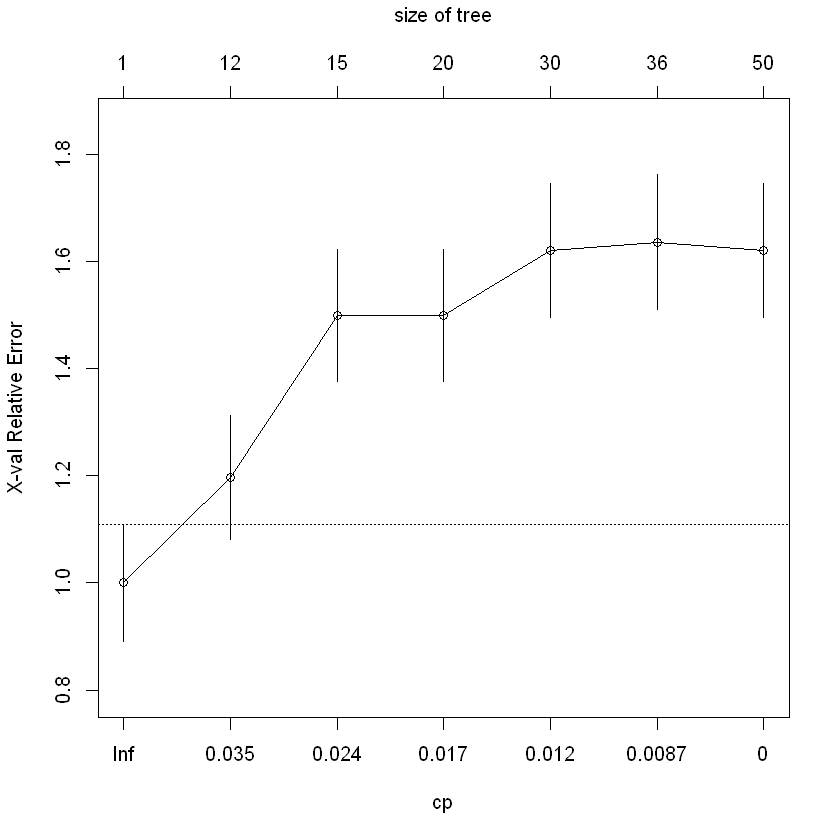

In [121]:
plotcp(mini)

#### Probar con un cp concreto

In [145]:
aux = rpart(ALTA_CAPITAL~.,
               data = db.train,
               method = "class",
               control = rpart.control(minsplit = 2, minbucket = 1, cp = 0.002)
              )

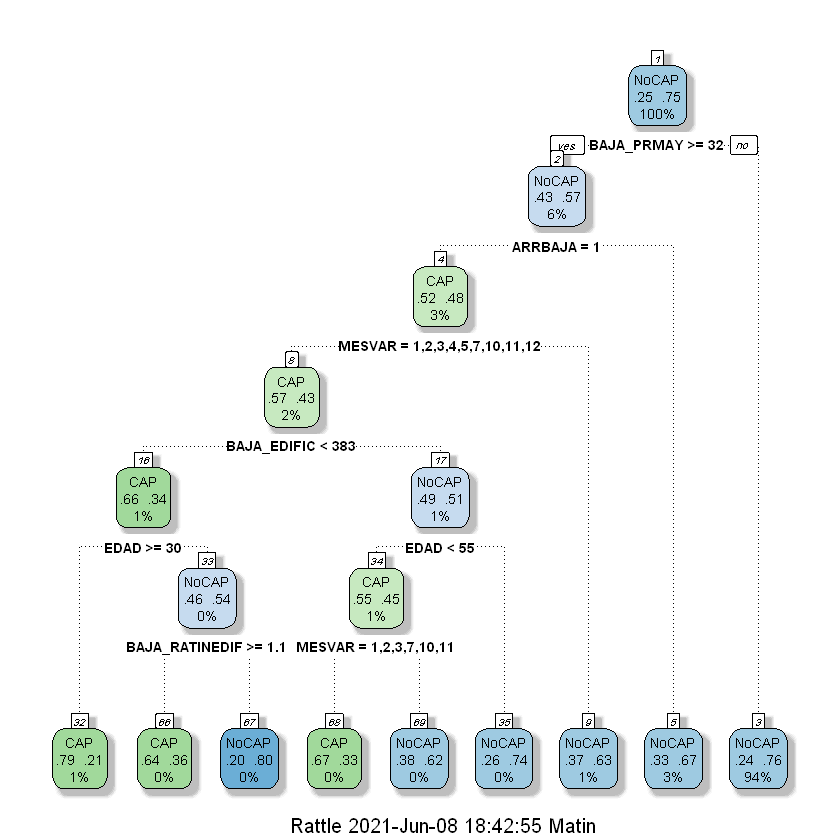

In [146]:
fancyRpartPlot(aux)

### Probar con TAMUALTA multiclase
(Hay que volver a cargar la versión `db_joined` del dataset)

In [5]:
# db_joined <- read.csv(choose.files())

# db_joined$MESVAR <- as.factor(db_joined$MESVAR)
# db_joined$CNAC <- as.factor(db_joined$CNAC)
# db_joined$BPROVNAC <- as.factor(db_joined$BPROVNAC)
# db_joined$TAMUBAJA <- as.factor(db_joined$TAMUBAJA)
# db_joined$ARRBAJA <- as.factor(db_joined$ARRBAJA)
# db_joined$TAMUALTA <- as.factor(db_joined$TAMUALTA)

# baja <- grepl("BAJA", names(db_joined), fixed = TRUE)

# baja_ind <- names(db_joined)[baja][-c(1,2,3)]

# selection <- c("SEXO","EDAD","MESVAR","CNAC","BPROVNAC","ARRALTA", # variables personales
#                baja_ind, # variables municipales de BAJA 
#                "TAMUALTA" # variable objetivo
#                 )
# db_joined <- db_joined[selection]

In [6]:
rows = sample(1:nrow(db_joined), 10000)
db.mcat <- db_joined[rows,]
rownames(db.mcat) <- NULL

#rm(db_joined)
dim(db.mcat)

[1] 10000    80

In [7]:
n = nrow(db.mcat)

indtrain = sample(1:n, 0.8*n)     # 80% para train
indtest = setdiff(1:n, indtrain)  # 20% para test

mcat.train = db.mcat[indtrain,]
rownames(mcat.train) <- NULL

mcat.test = db.mcat[indtest,]
rownames(mcat.test) <- NULL

In [21]:
aux = rpart(TAMUALTA~.,
               data = mcat.train,
               method = "class",
               control = rpart.control(minsplit = 2, minbucket = 1, cp = 0))

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

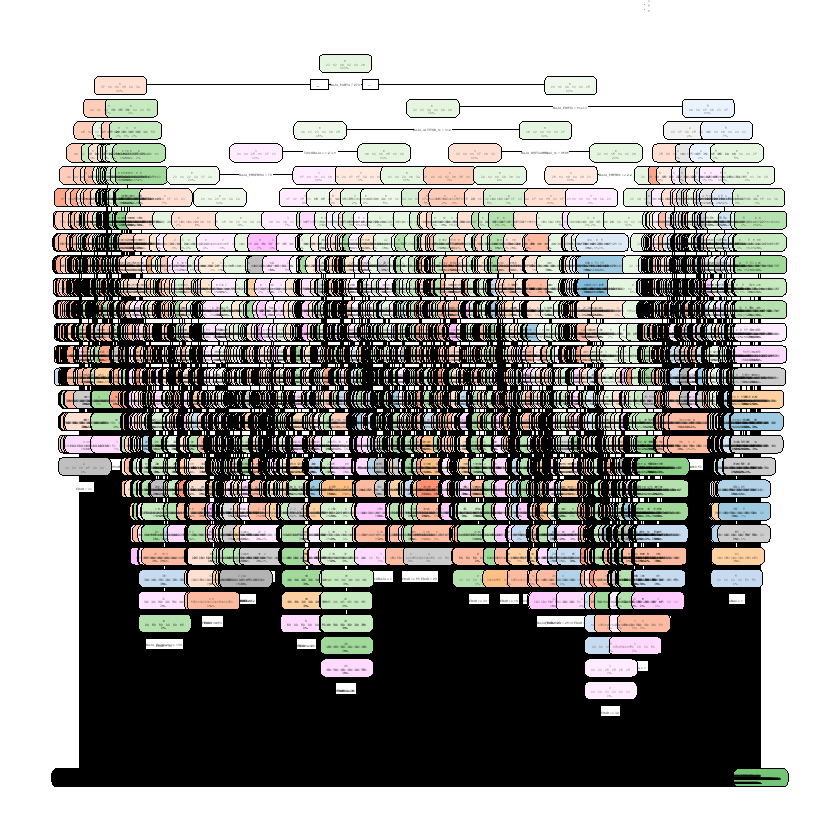

In [22]:
rpart.plot(aux)

In [23]:
printcp(aux)


Classification tree:
rpart(formula = TAMUALTA ~ ., data = mcat.train, method = "class", 
    control = rpart.control(minsplit = 2, minbucket = 1, cp = 0))

Variables actually used in tree construction:
 [1] ARRBAJA                BAJA_ALTITUD_M         BAJA_AREAKM2          
 [4] BAJA_CONSTRU           BAJA_CV                BAJA_DISTAUTOPAUTOV_M 
 [7] BAJA_DISTCARRNAC_M     BAJA_DISTESTACFERROC_M BAJA_DISTNUC10KM_M    
[10] BAJA_EDIFIC            BAJA_IDEPJOV           BAJA_IMASC20          
[13] BAJA_INDUSTR           BAJA_INMUEB            BAJA_INVPERM          
[16] BAJA_MATRIM            BAJA_MUFET             BAJA_MUJ2020          
[19] BAJA_NACIM             BAJA_OCTC              BAJA_OCTP             
[22] BAJA_OCUOTR            BAJA_PARPE             BAJA_PARTA            
[25] BAJA_PENDIENTE_GRADOS  BAJA_POB2020           BAJA_PRAD             
[28] BAJA_PRIMARIO          BAJA_PRJOV             BAJA_PRMAY            
[31] BAJA_PRPRIM            BAJA_PRSEC             BAJA_P

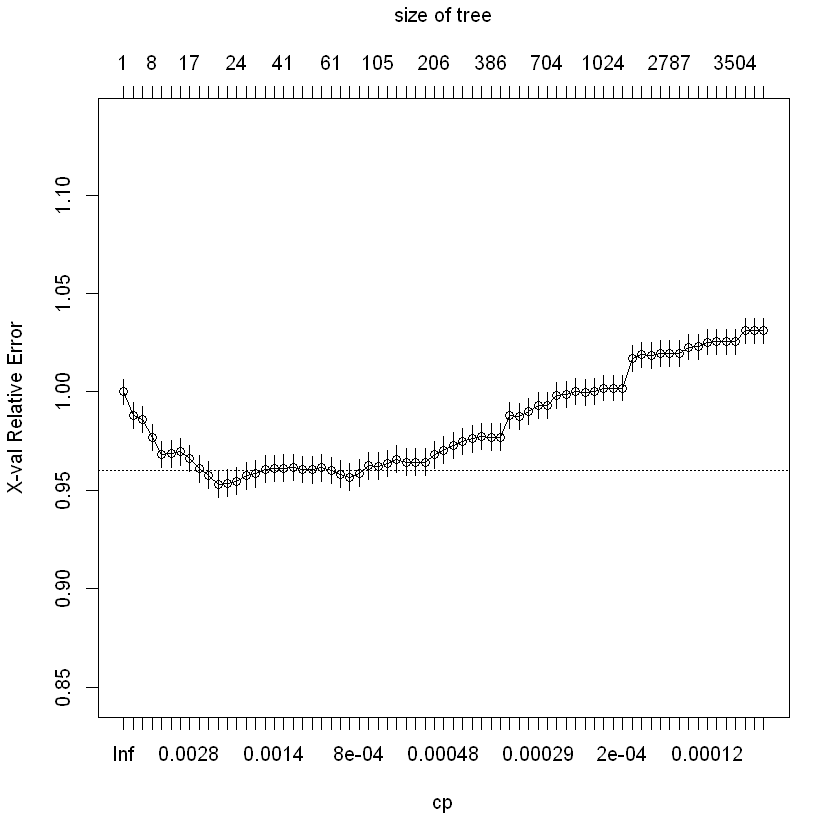

In [24]:
plotcp(aux)

In [25]:
ptree <- prune(aux,
               cp = aux$cptable[which.min(aux$cptable[,"xerror"]),"CP"])

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

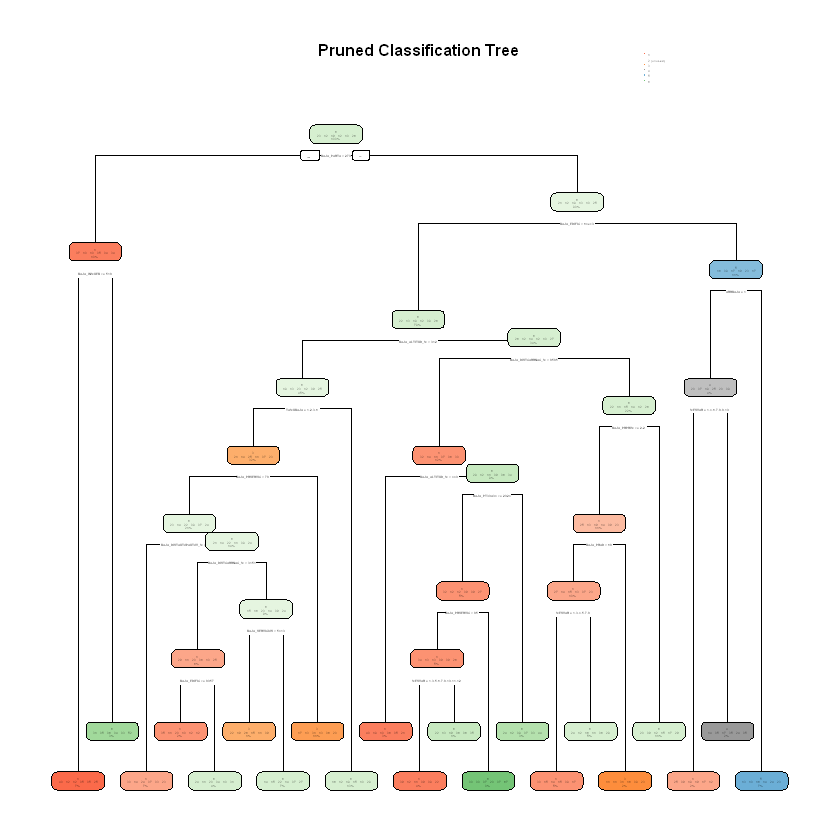

In [26]:
rpart.plot(ptree, main="Pruned Classification Tree")

### Accuracy de Train y Test

In [27]:
pred.train = predict(ptree, mcat.train, type = "class")

In [30]:
acc.class(pred.train, mcat.train$TAMUALTA)

[1] 0.318875

In [31]:
pred.test = predict(aux, mcat.test, type = "class")

In [33]:
acc.class(pred.test, mcat.test$TAMUALTA)

[1] 0.2495

### Chequear la distribución visual de las variables (en CAP vs. NoCAP):

In [18]:
# Para poder dibujar histograma, solo escogemos las variables numéricas:

cap <- subset(db.num, ALTA_CAPITAL == "CAP")
nocap <- subset(db.num, ALTA_CAPITAL == "NoCAP")

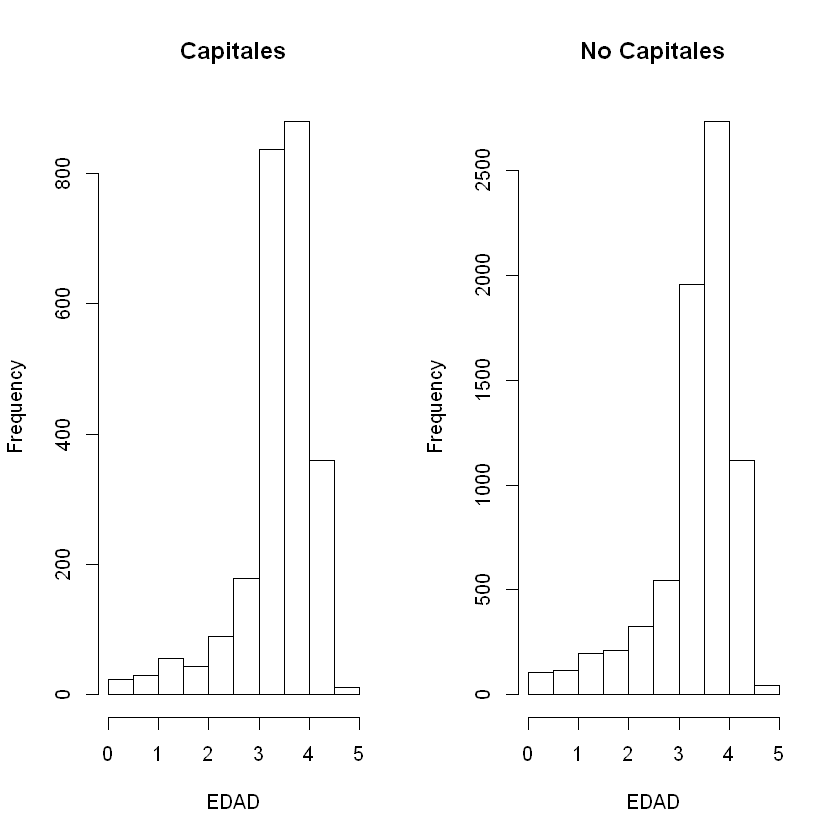

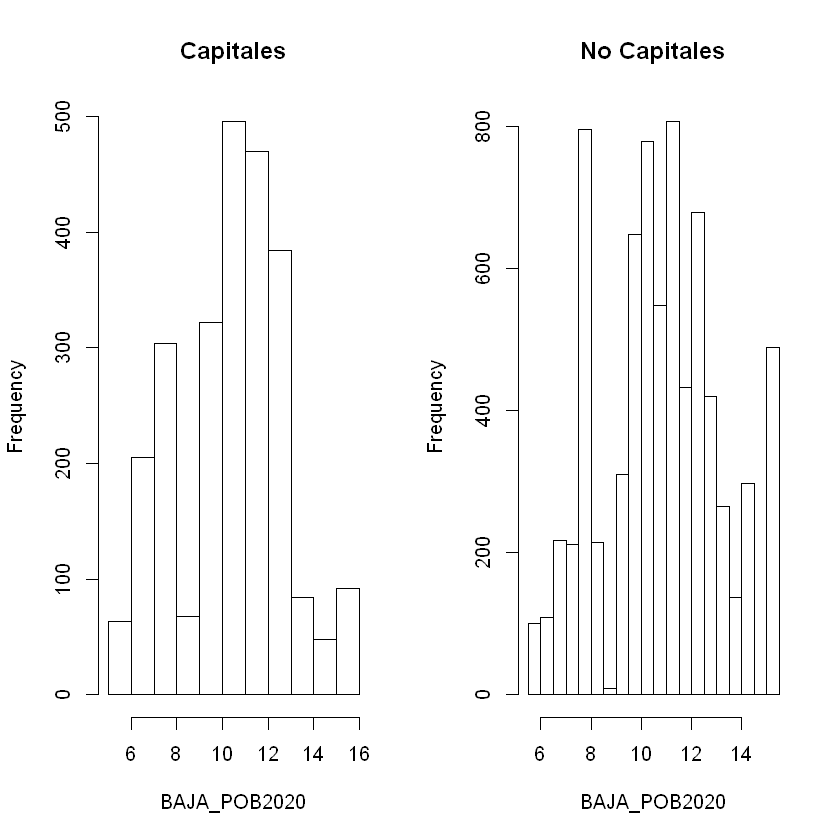

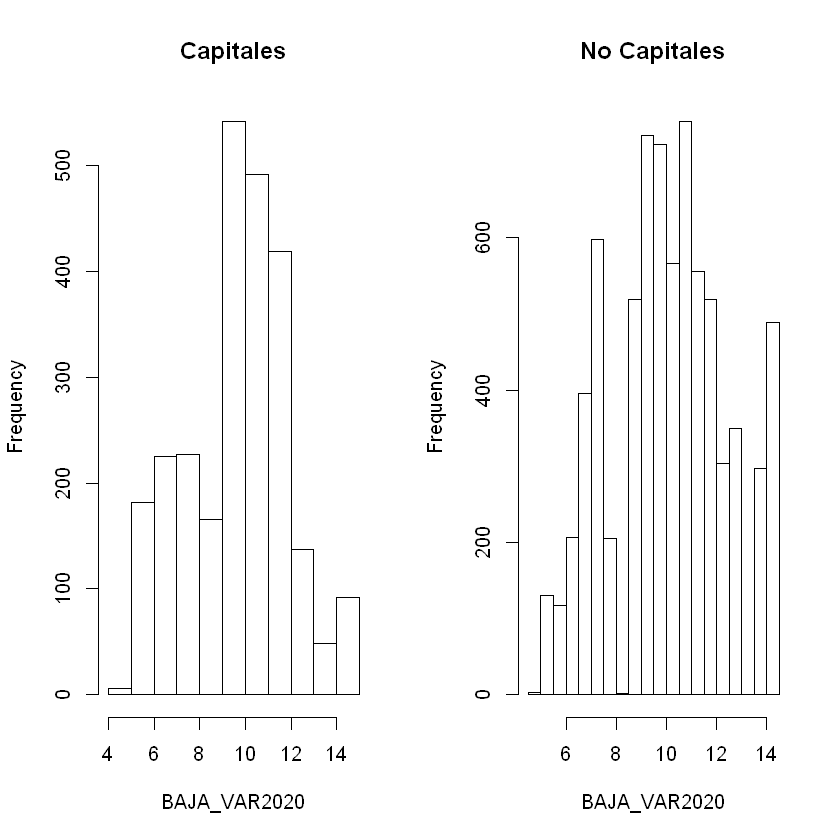

Warning message in log(unlist(cap[i])):
"NaNs produced"

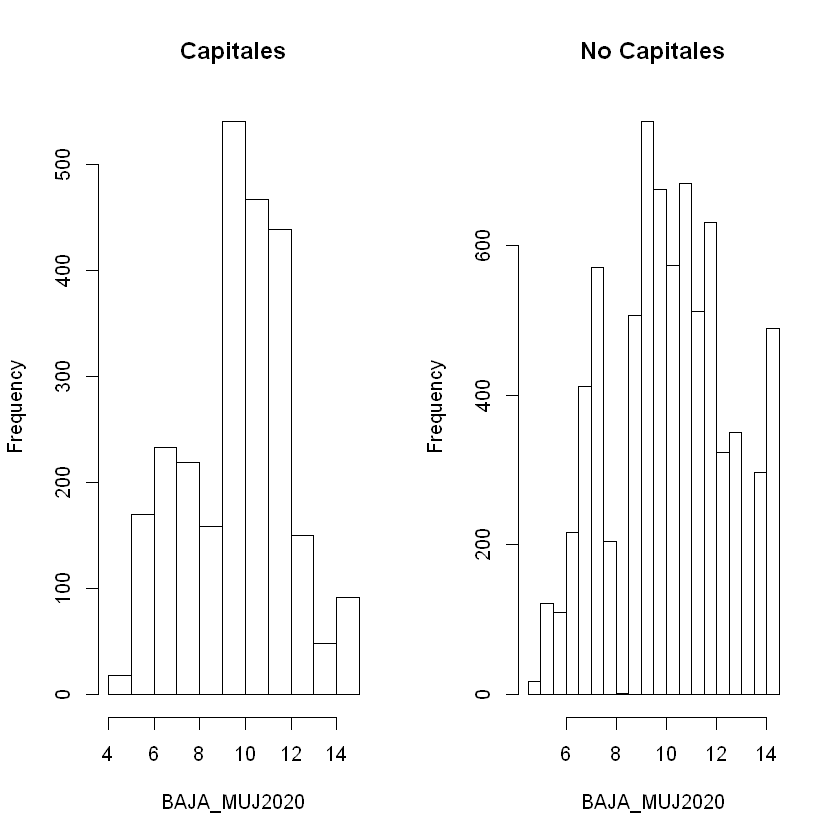

Warning message in log(unlist(nocap[i])):
"NaNs produced"

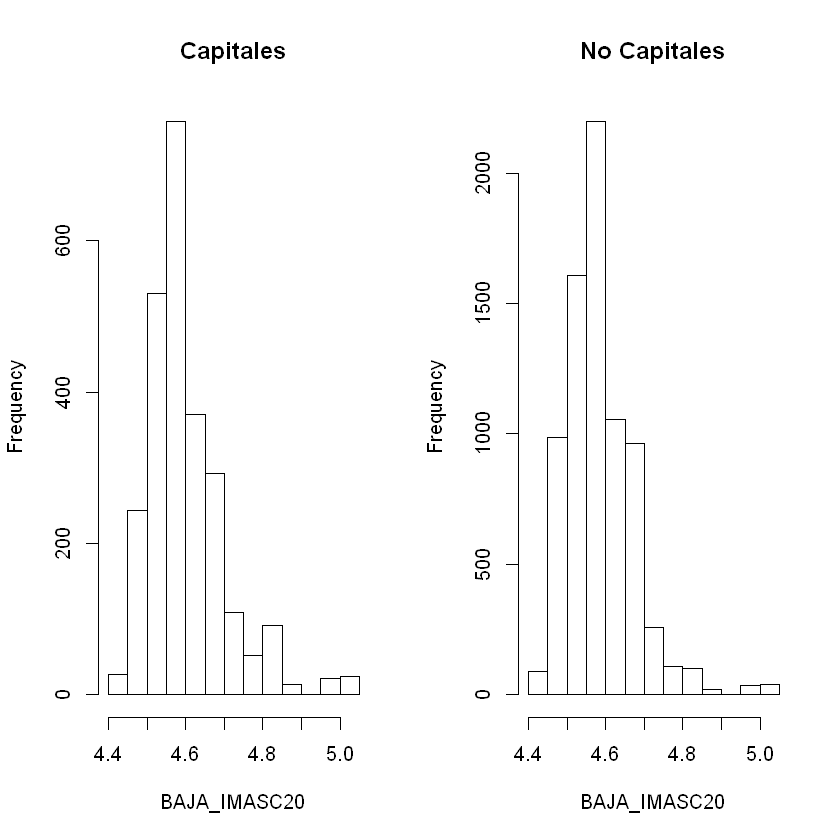

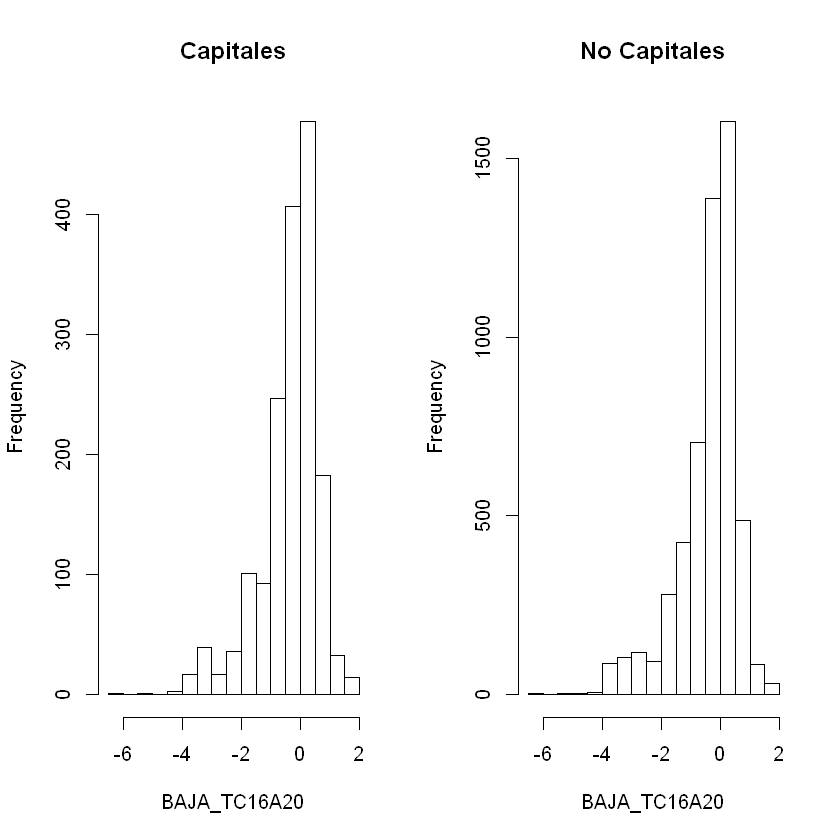

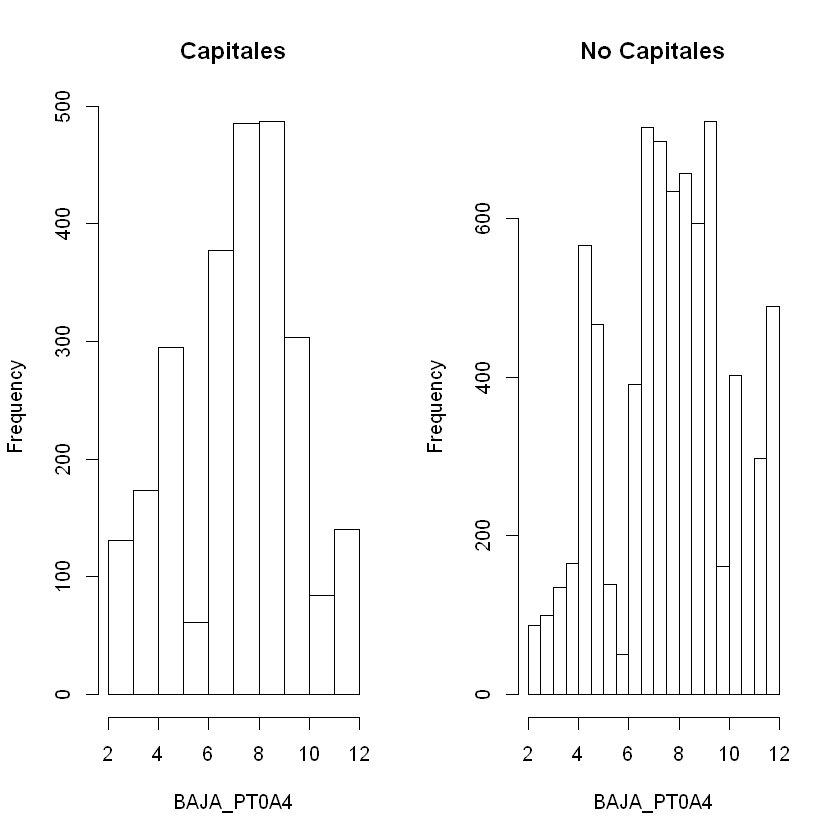

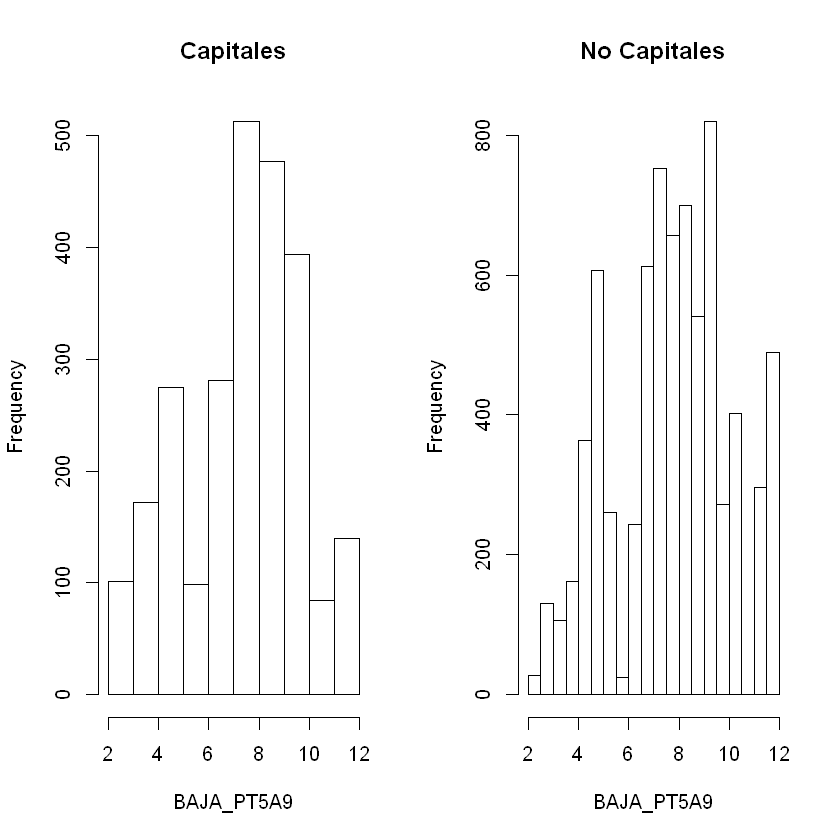

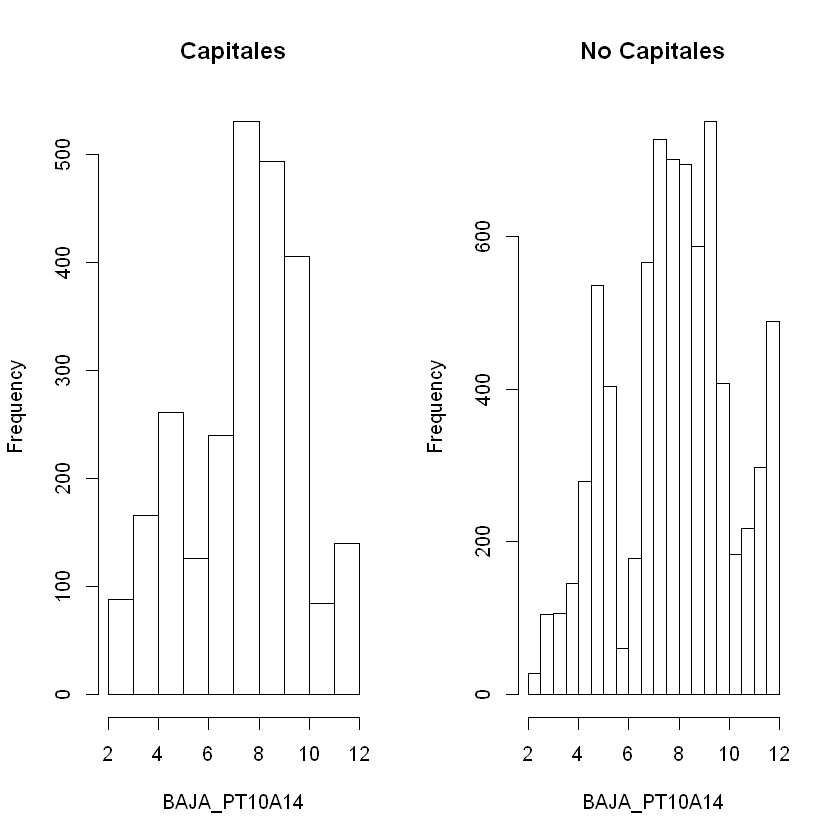

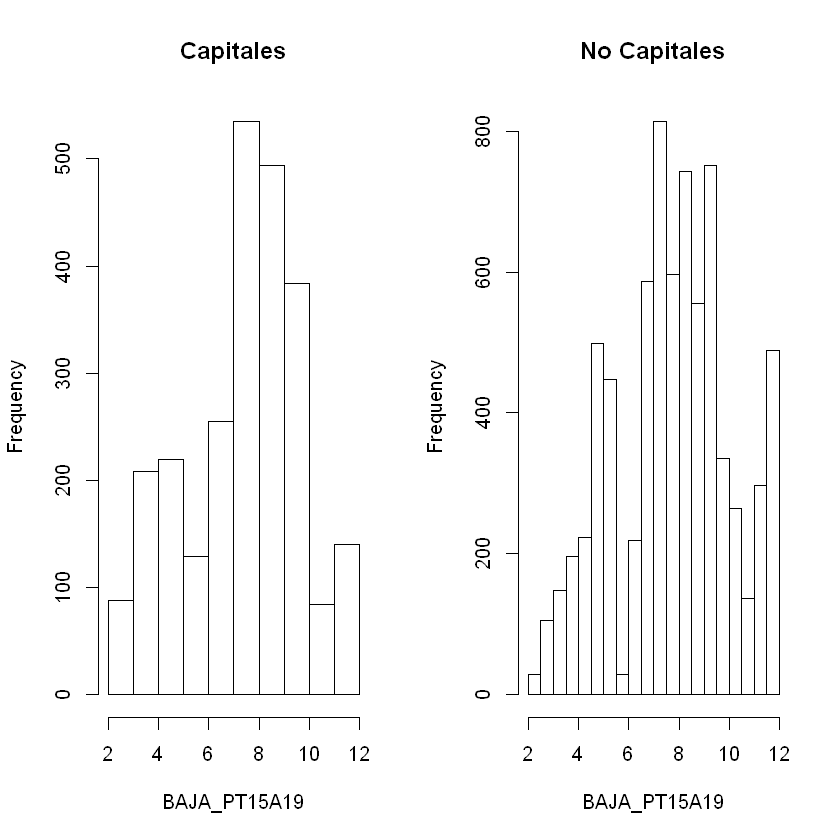

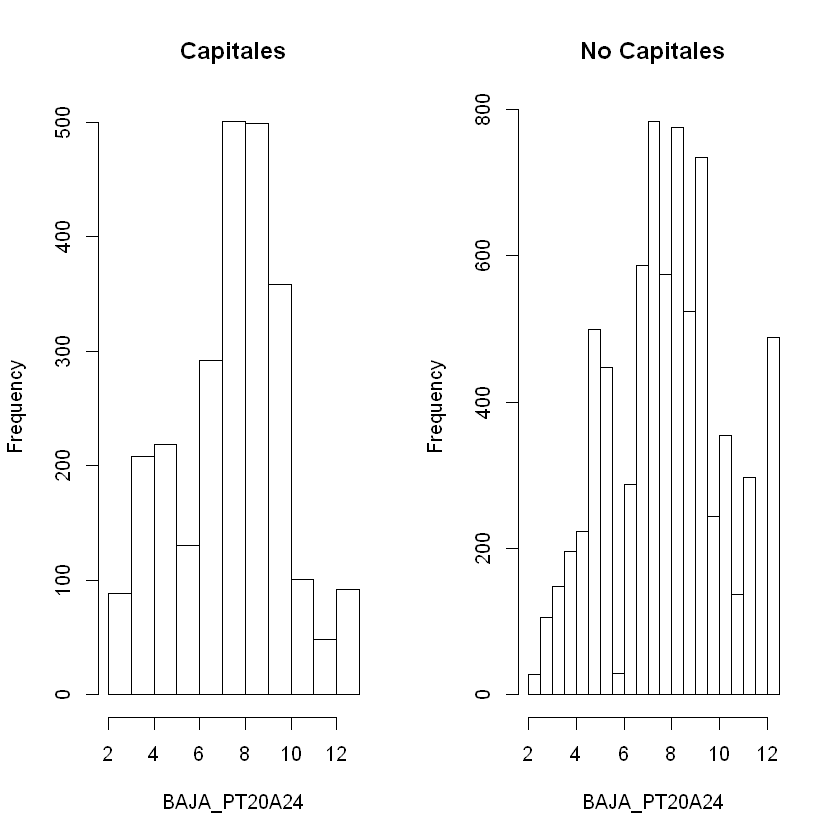

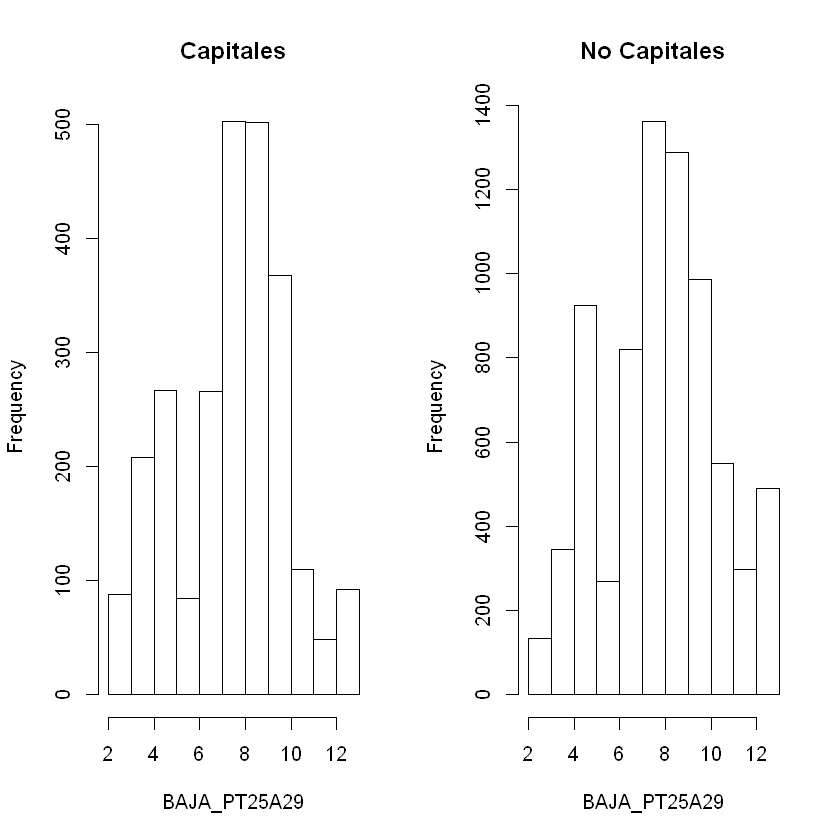

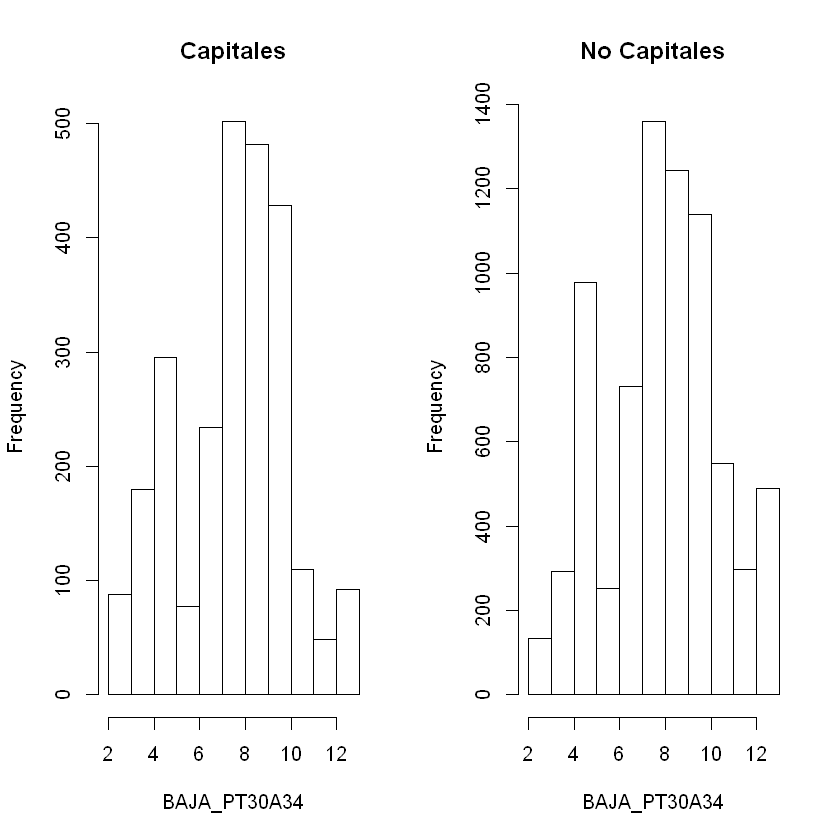

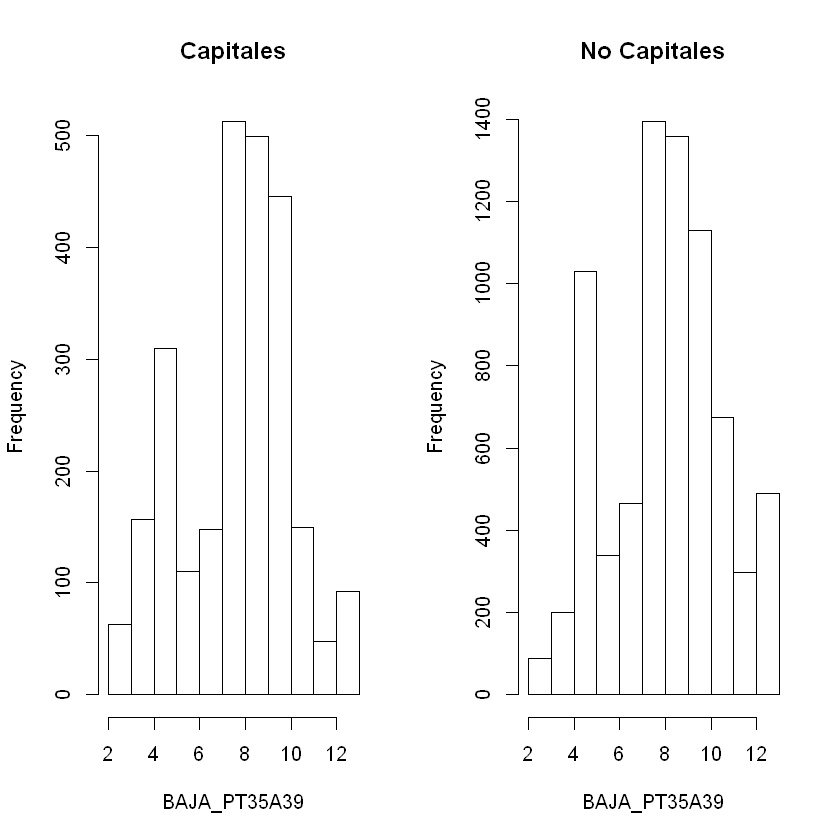

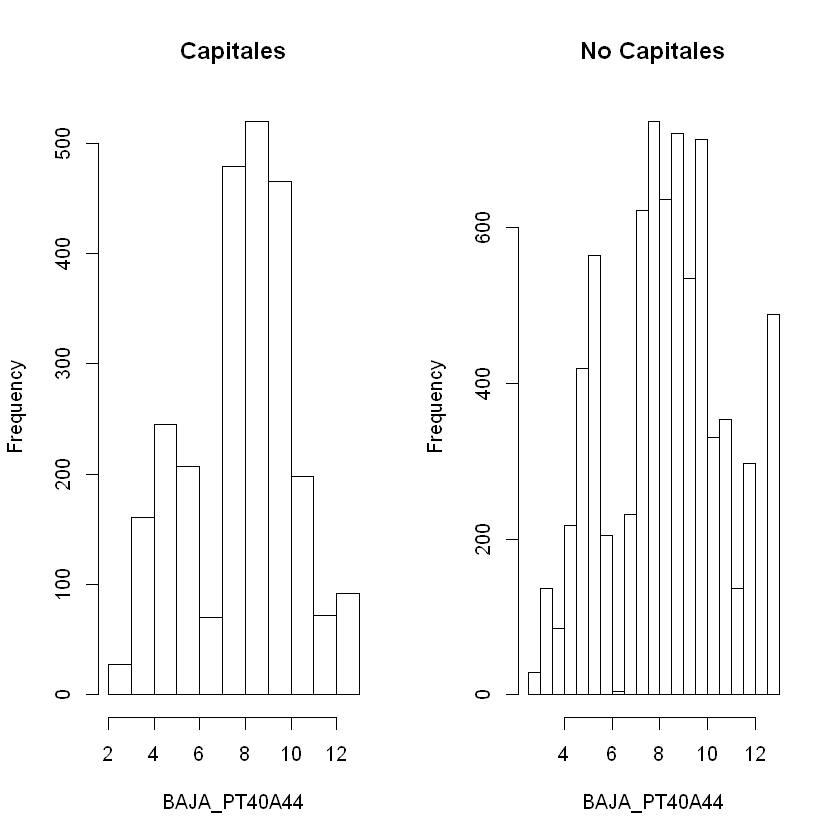

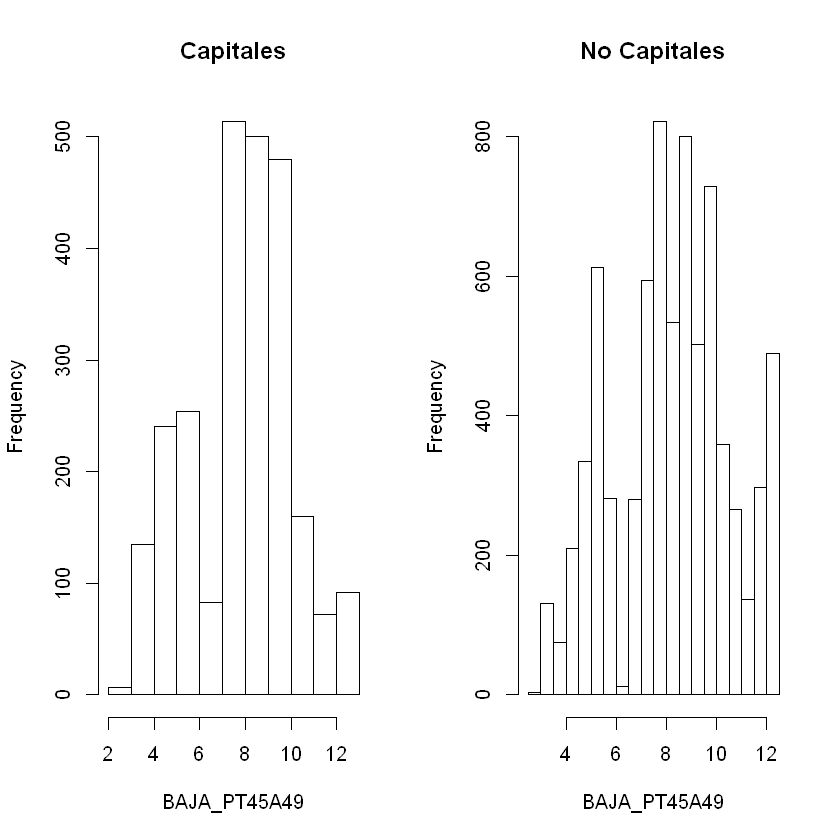

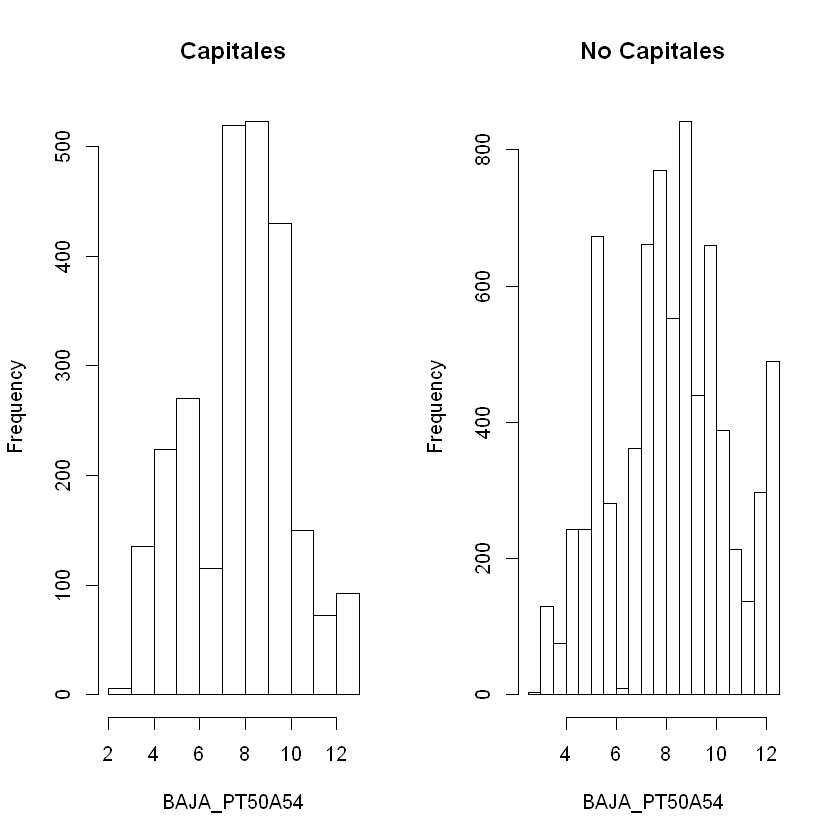

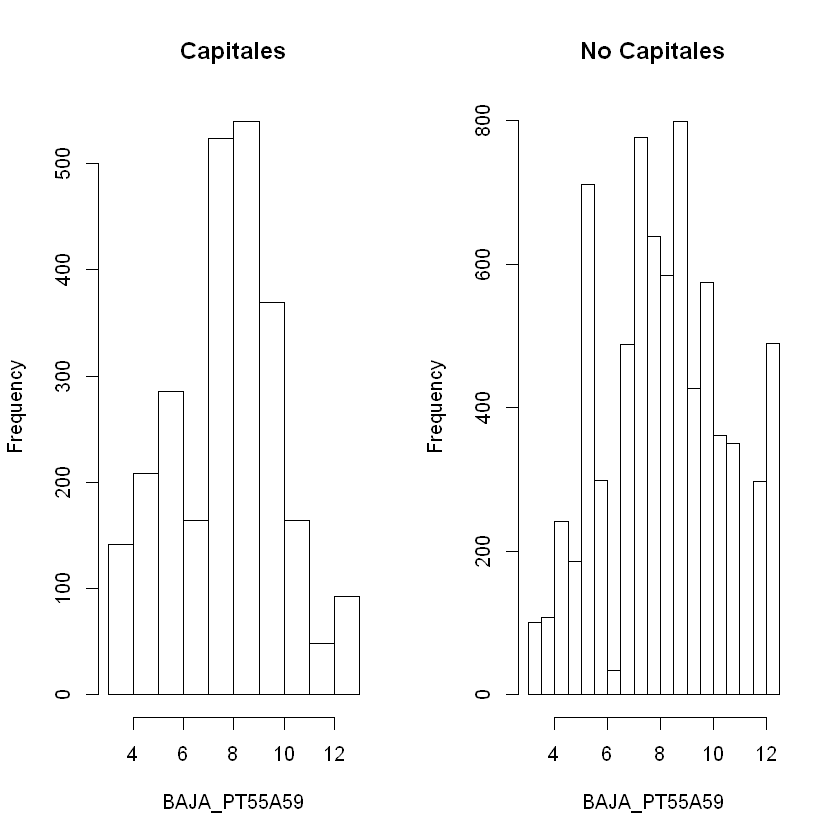

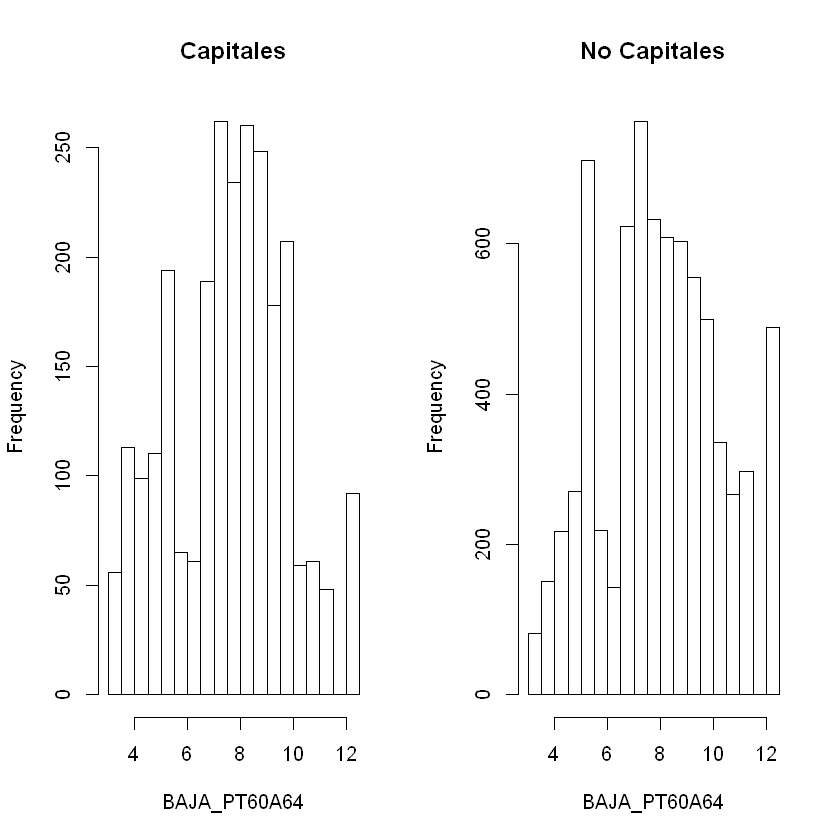

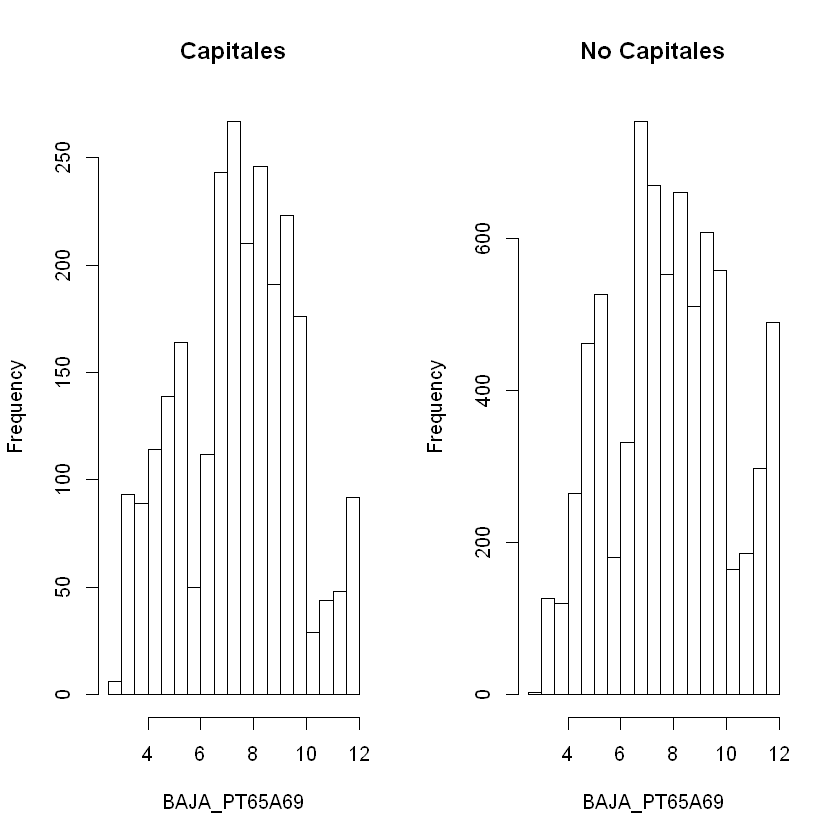

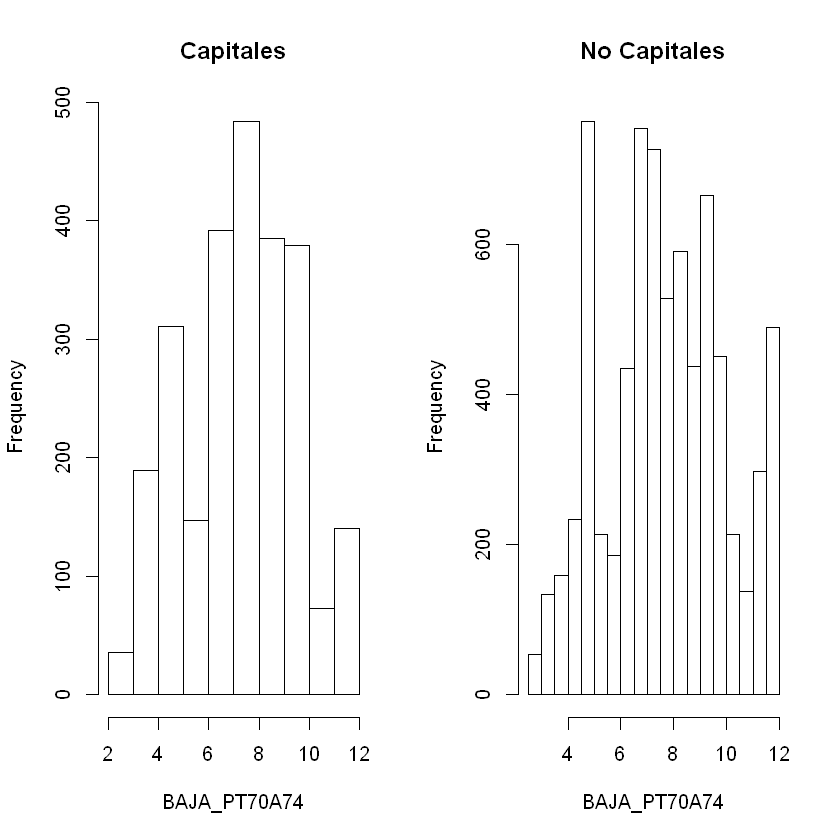

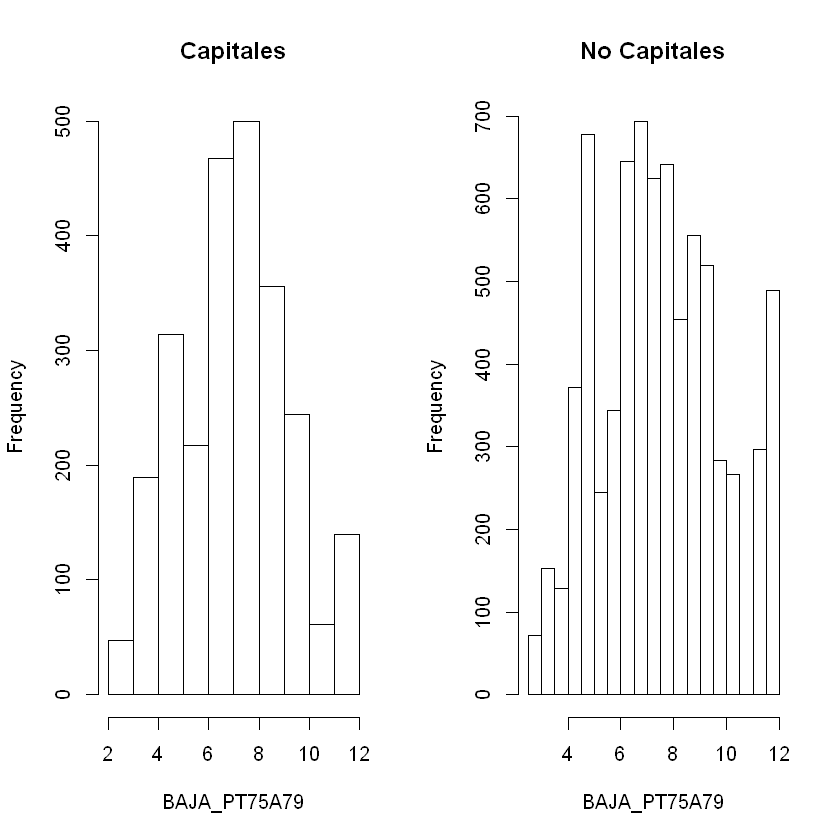

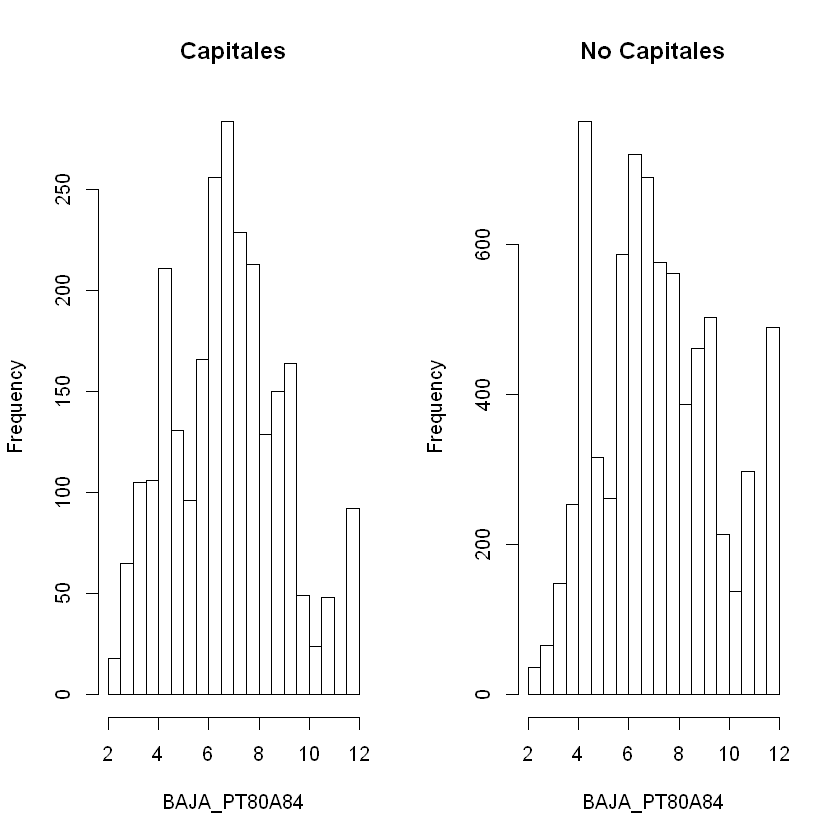

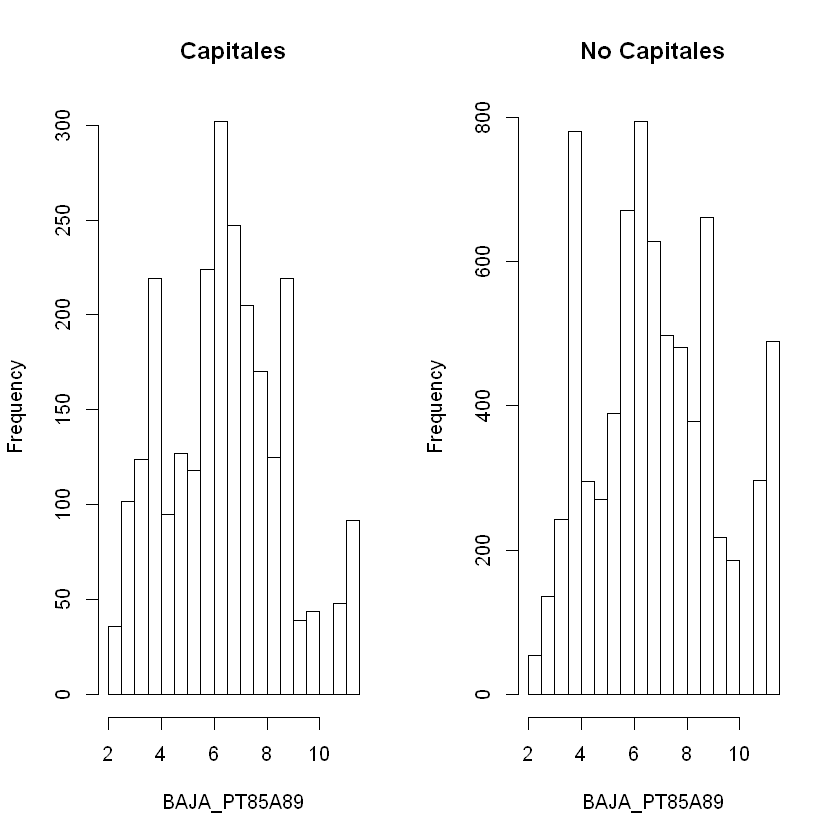

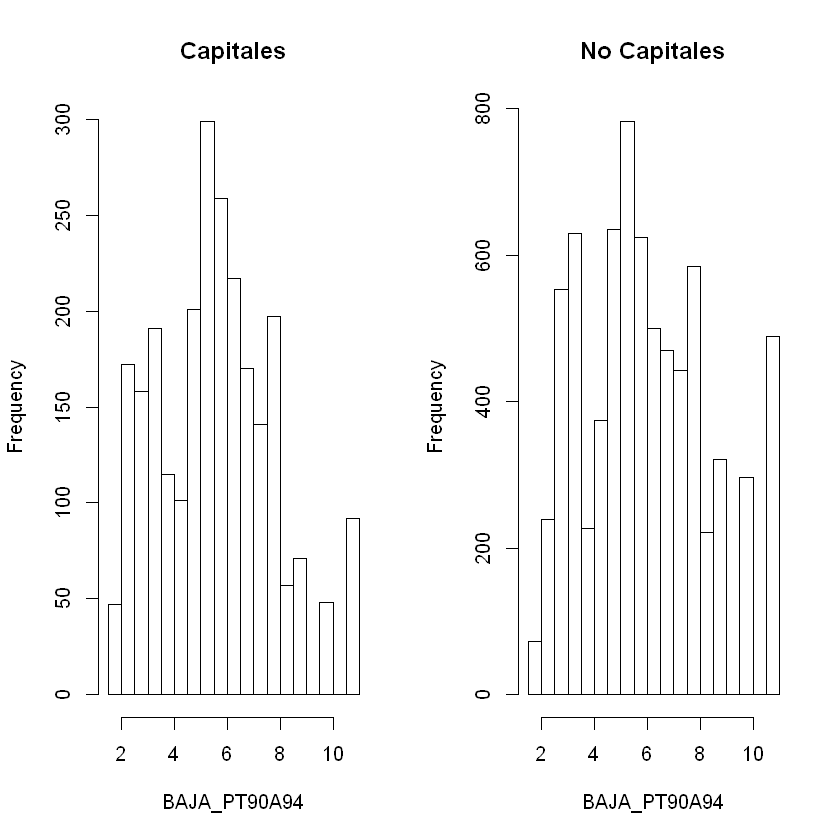

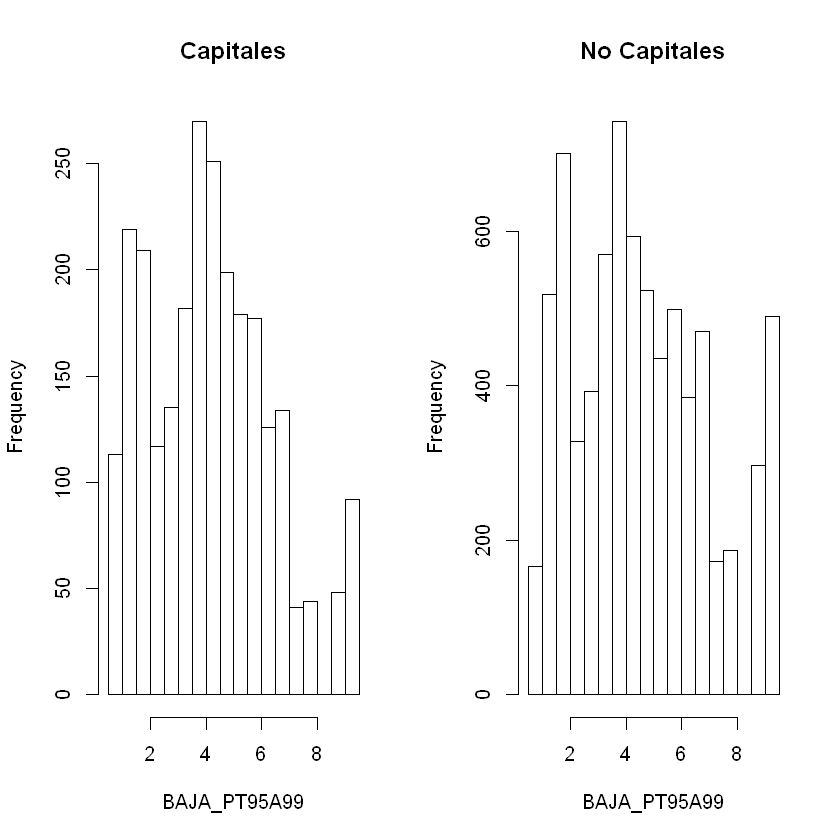

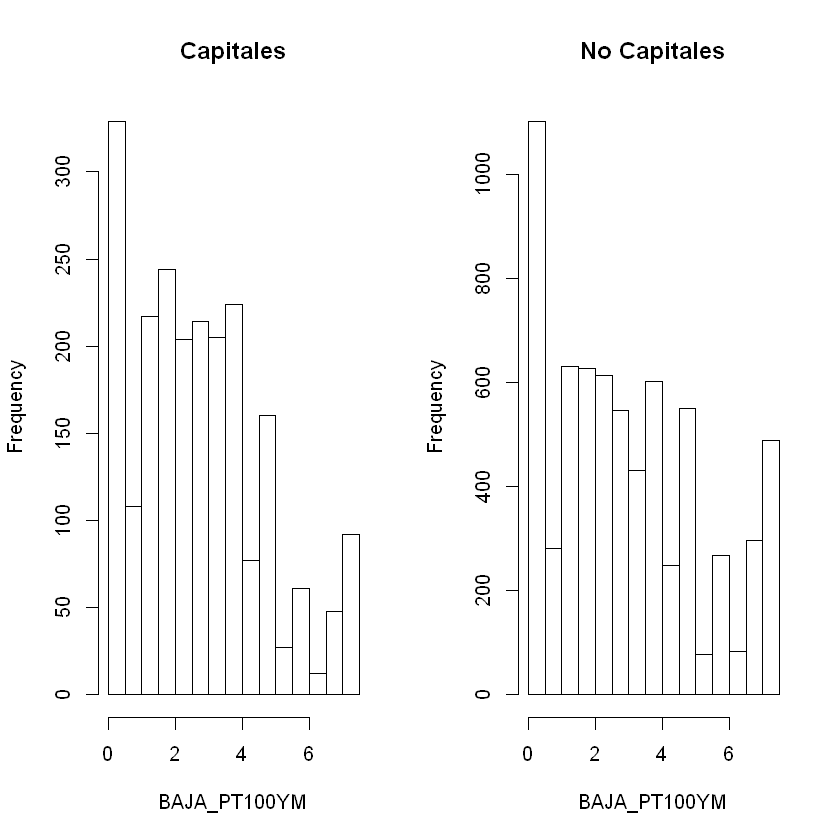

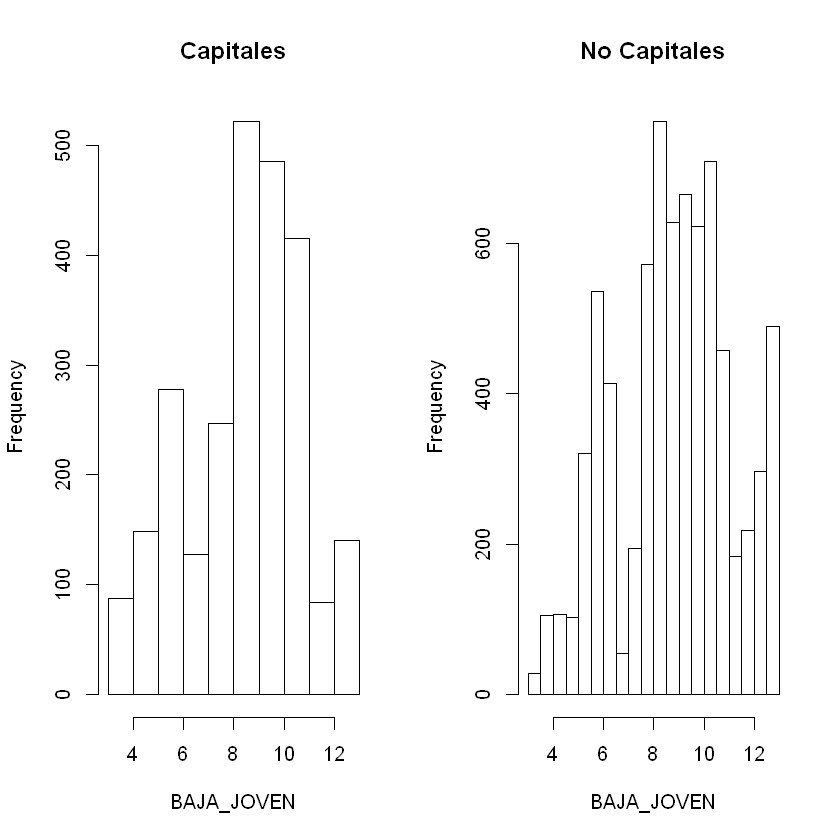

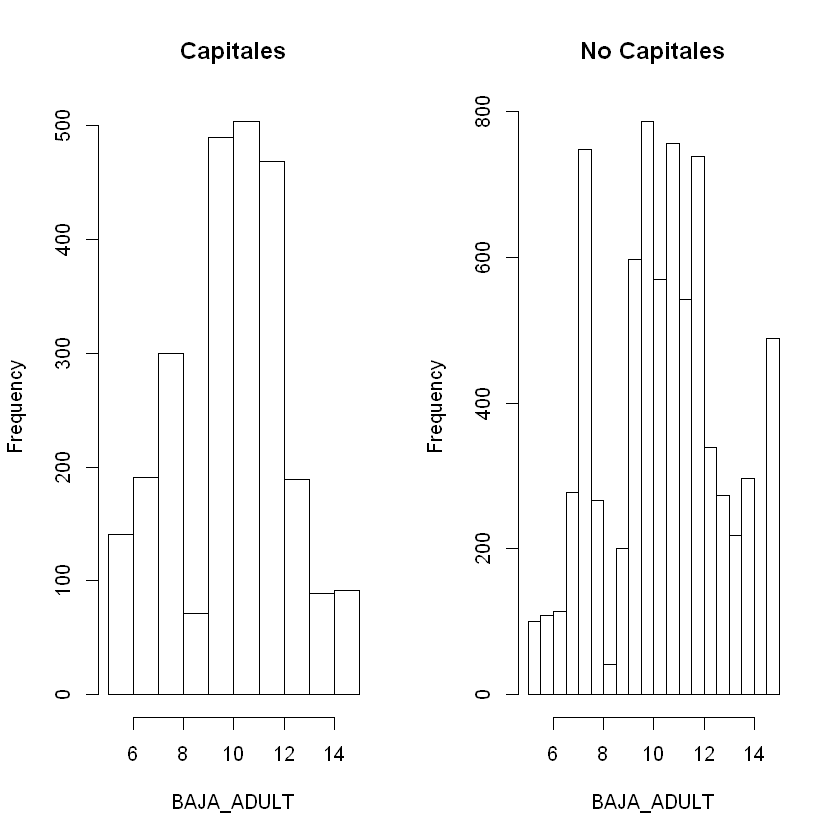

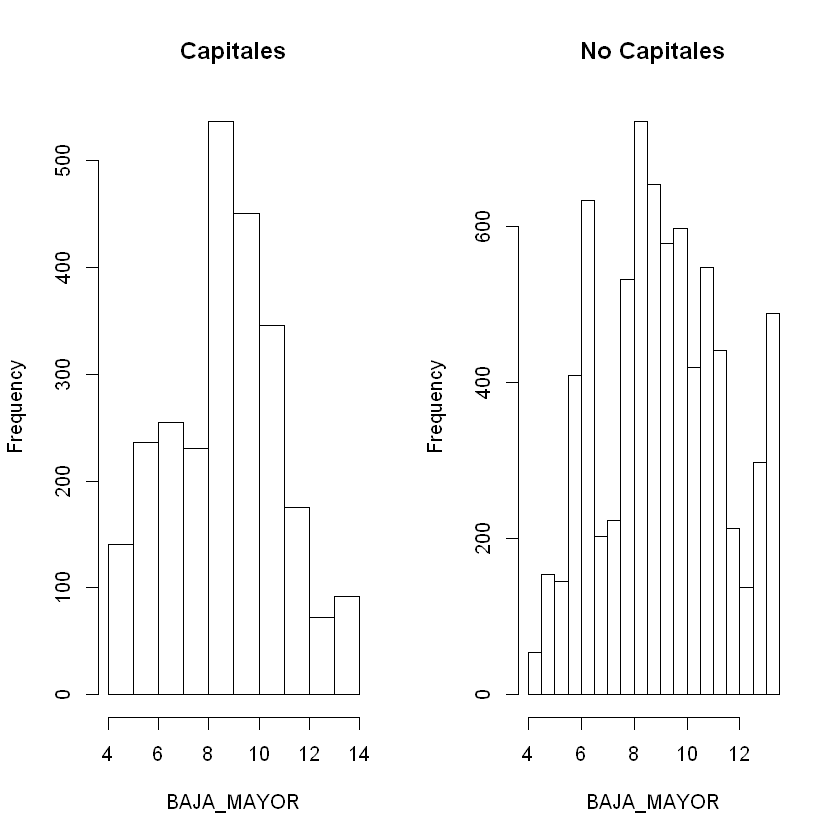

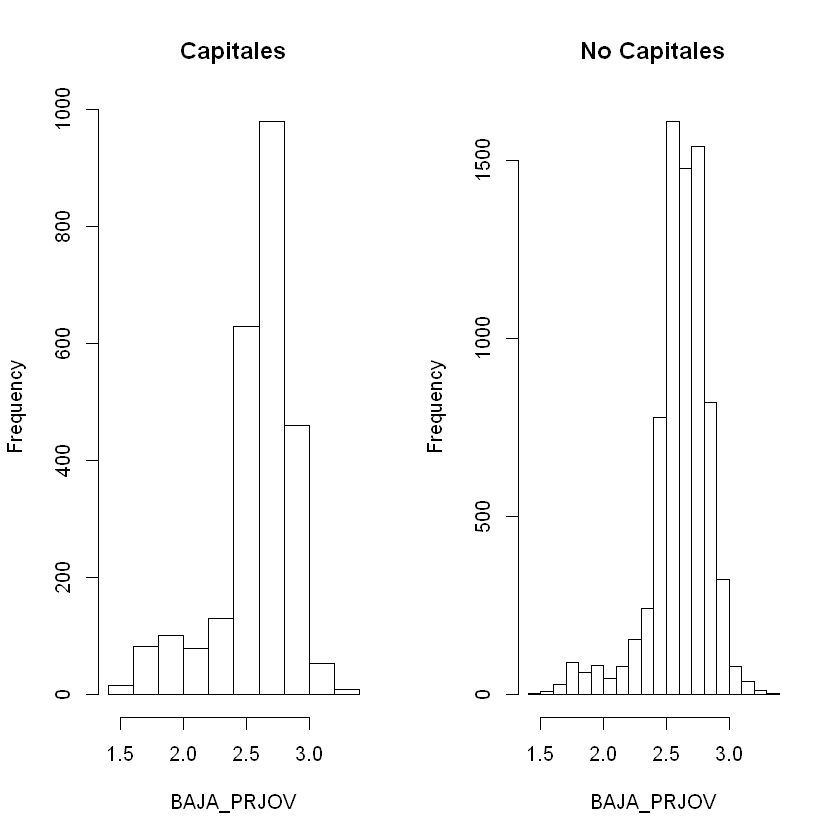

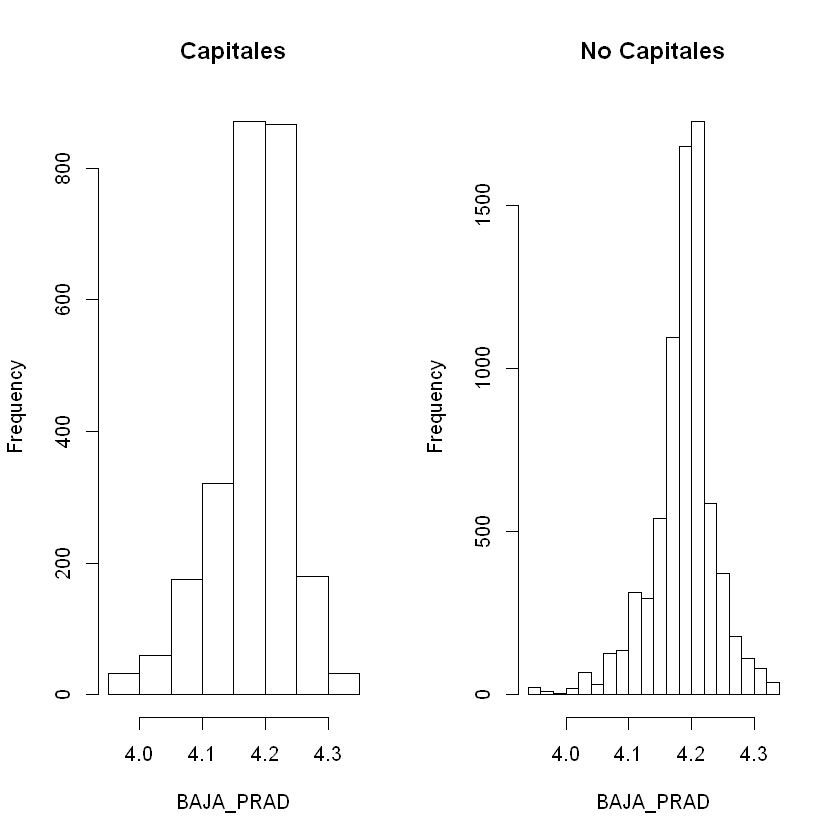

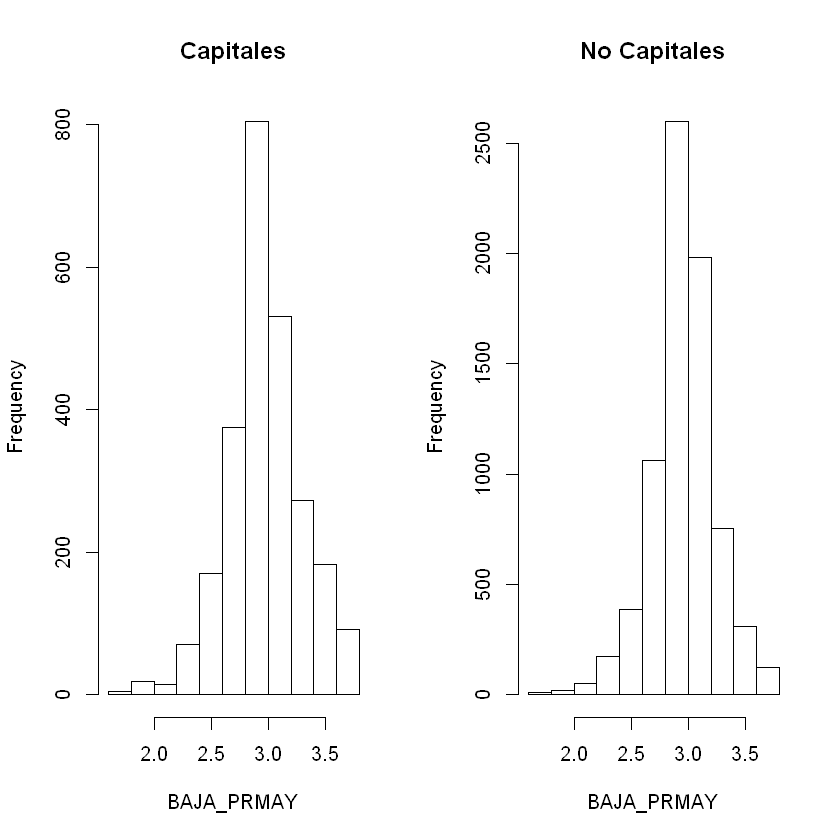

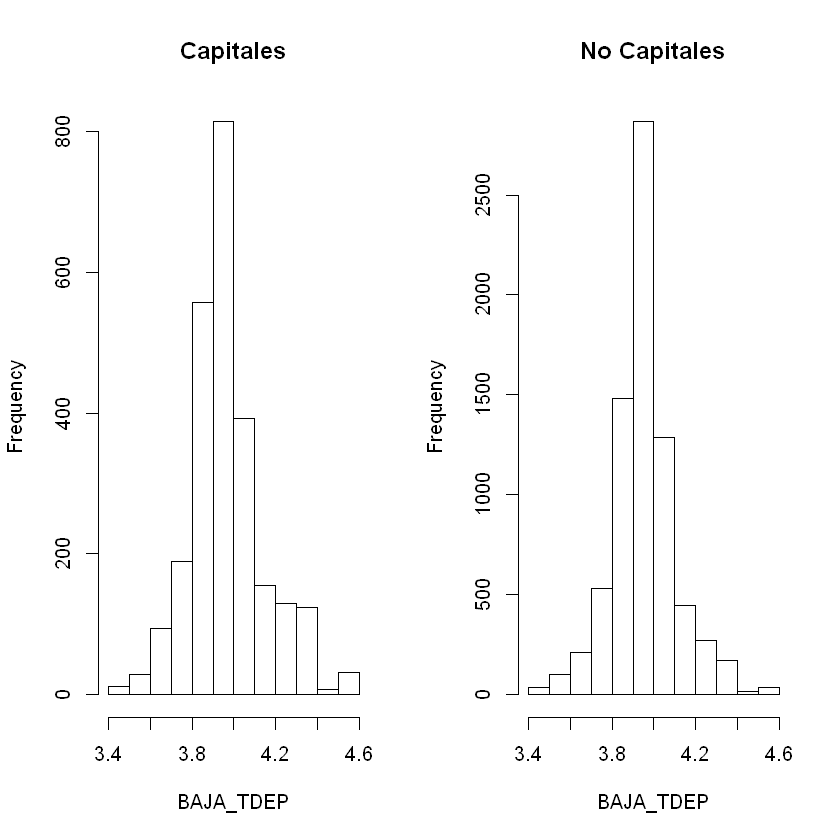

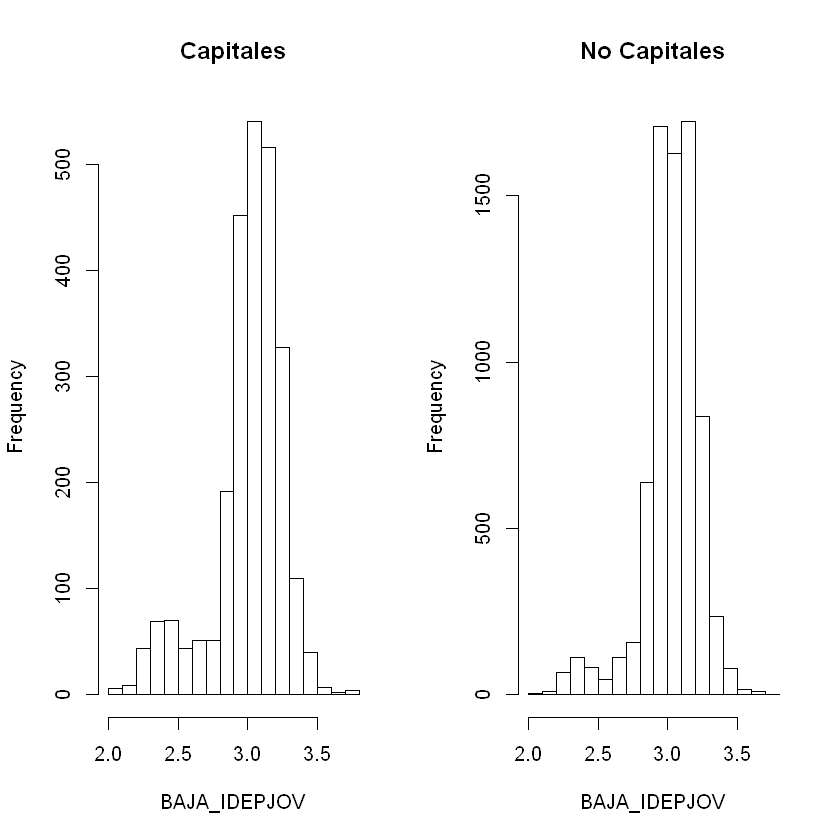

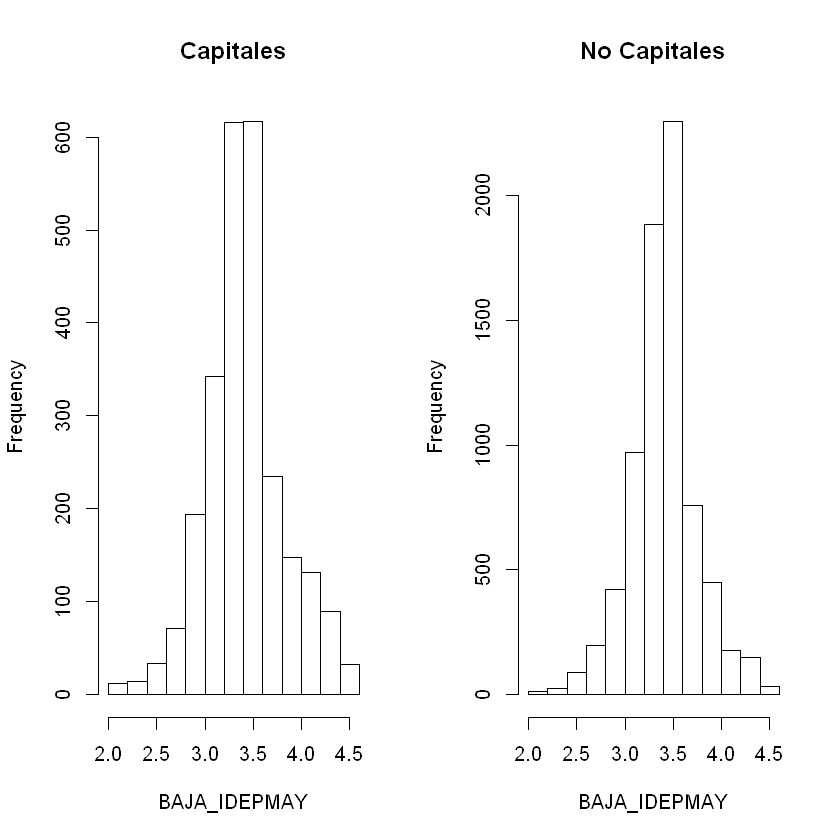

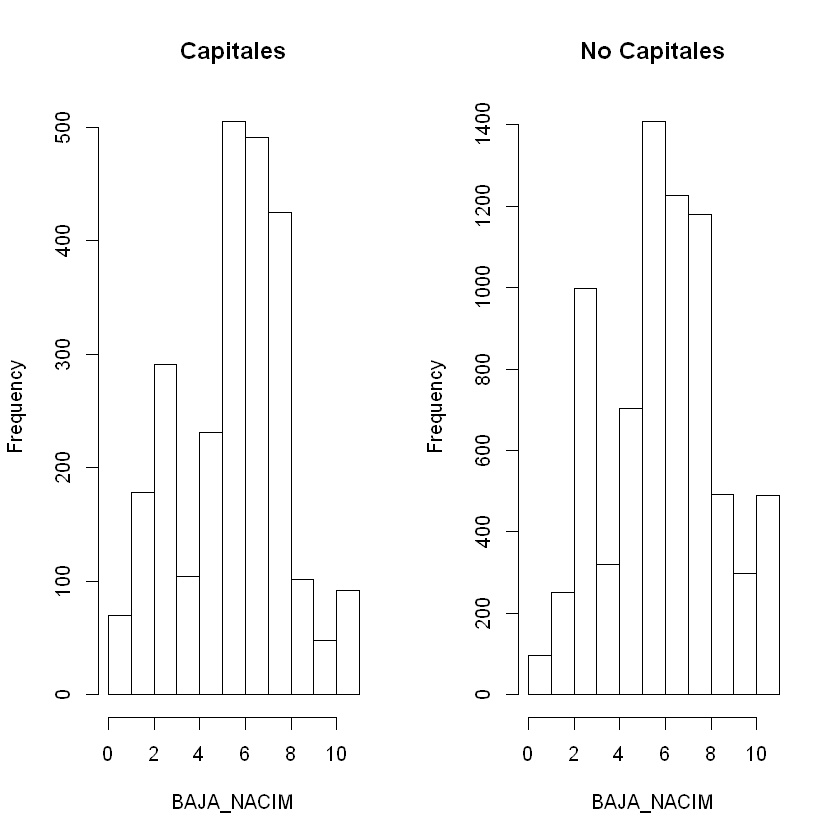

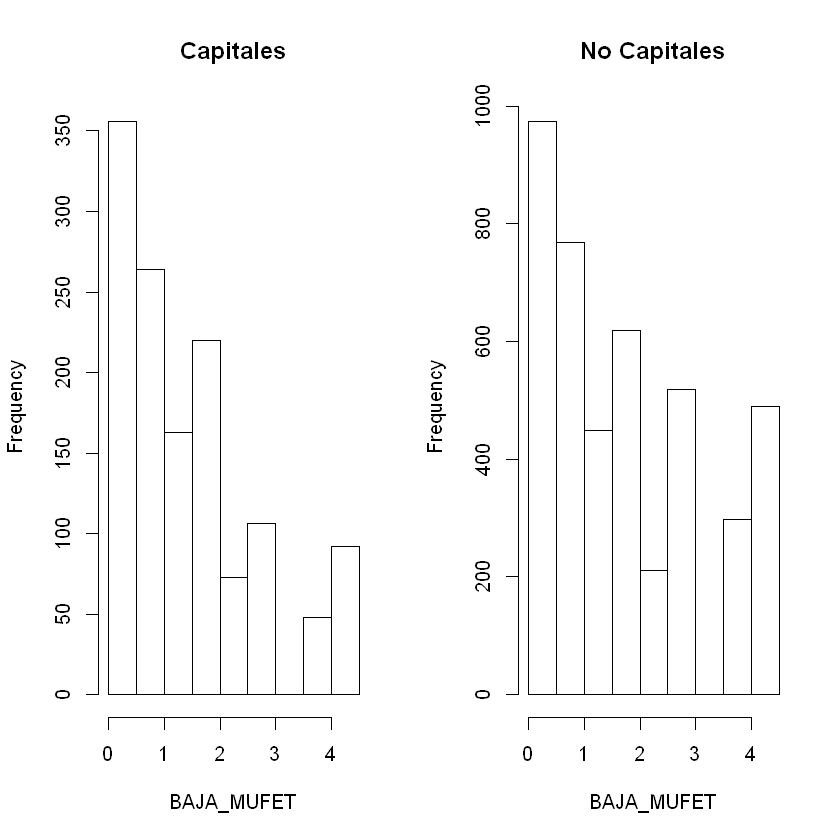

Warning message in log(unlist(cap[i])):
"NaNs produced"

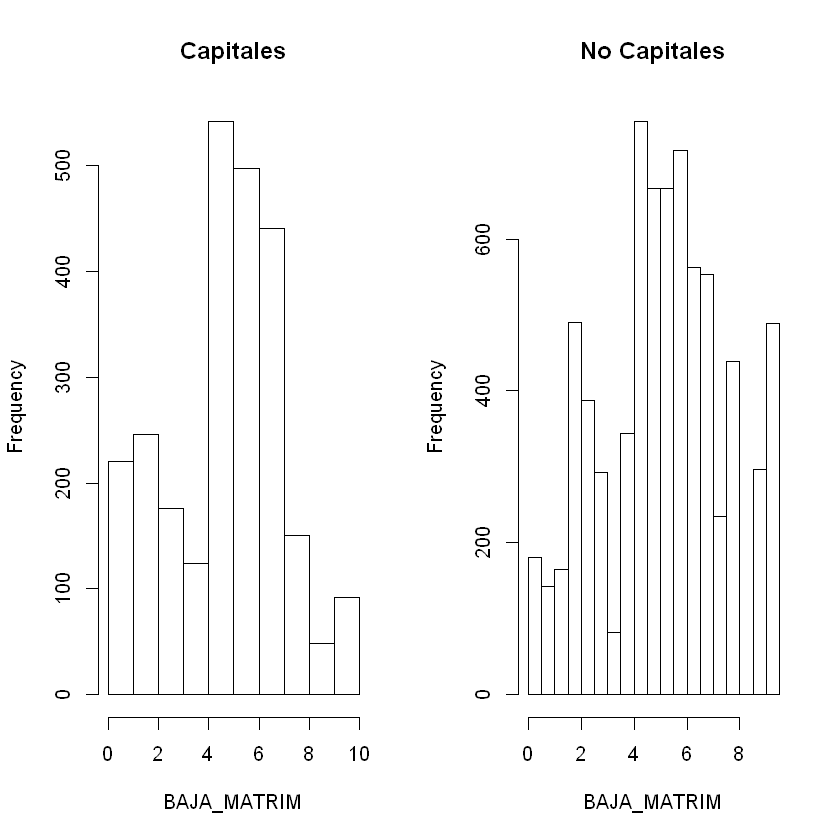

Warning message in log(unlist(nocap[i])):
"NaNs produced"

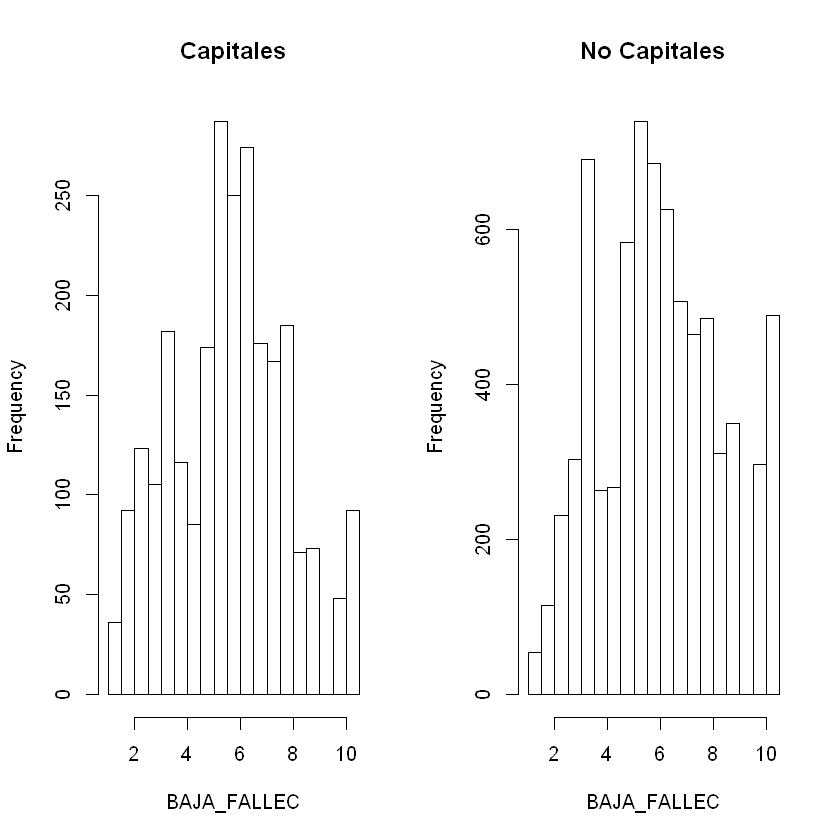

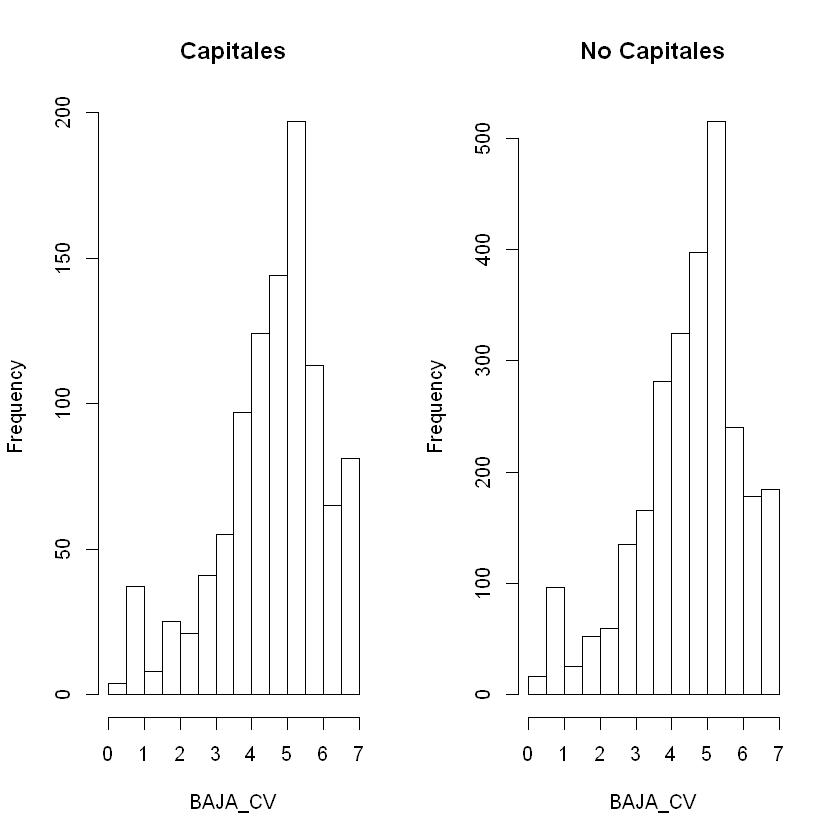

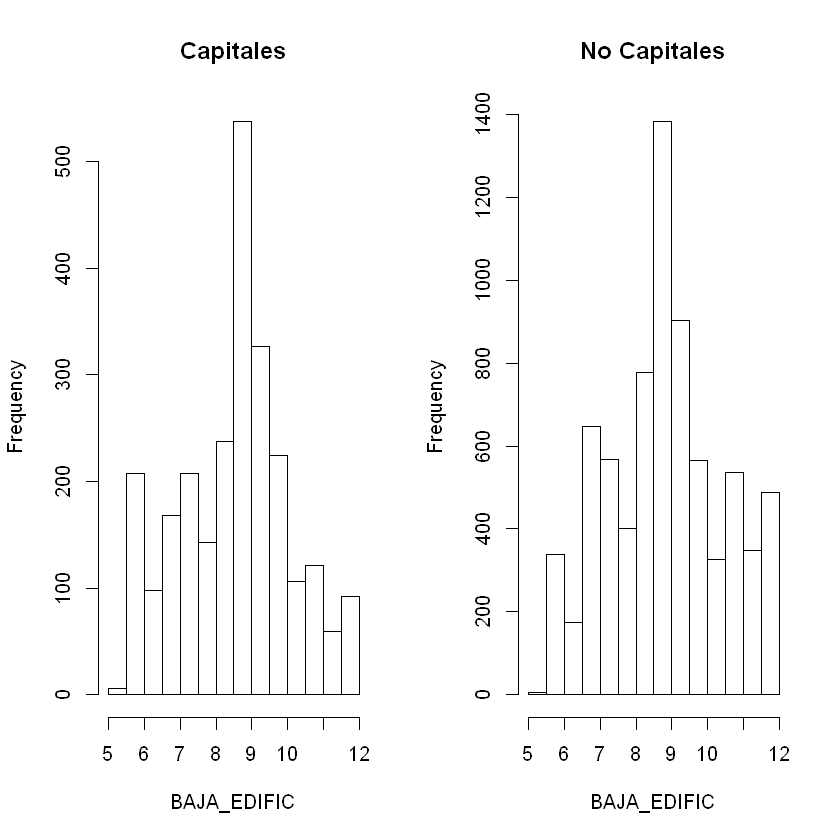

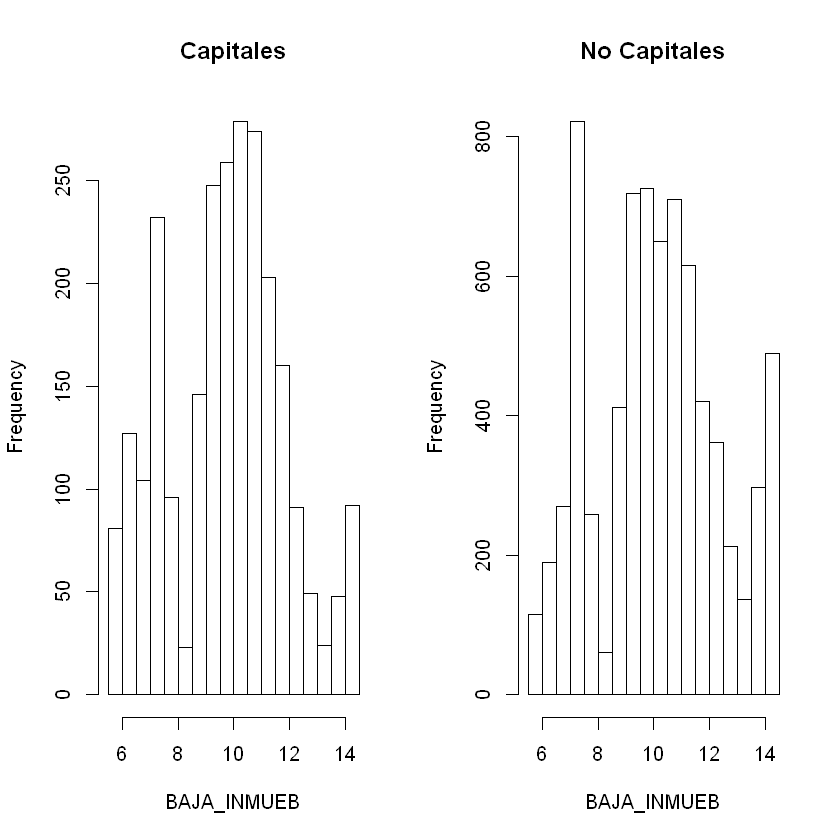

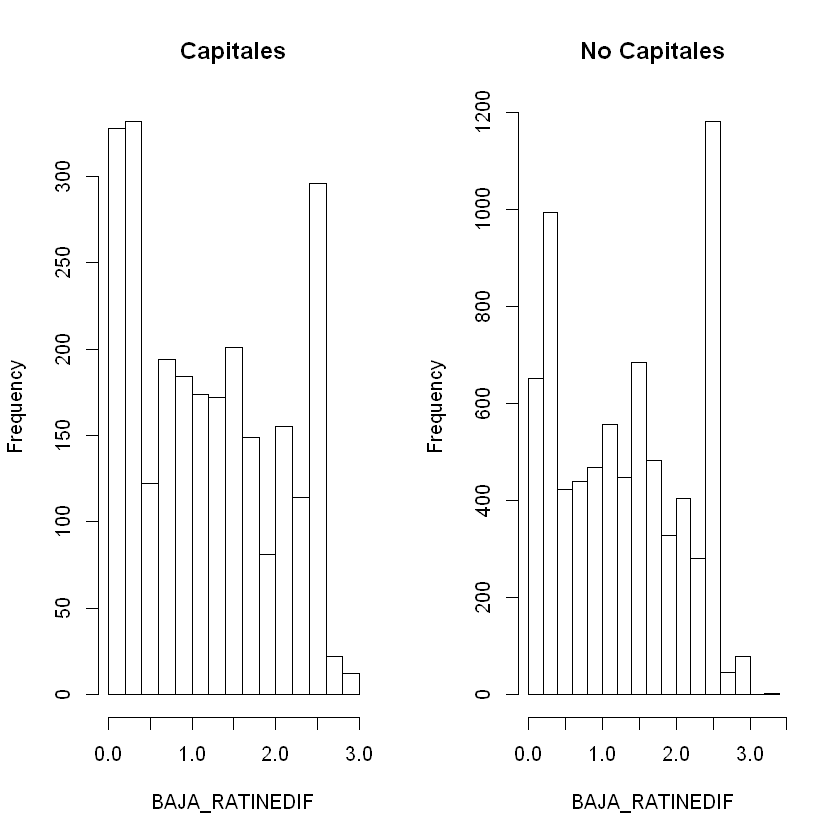

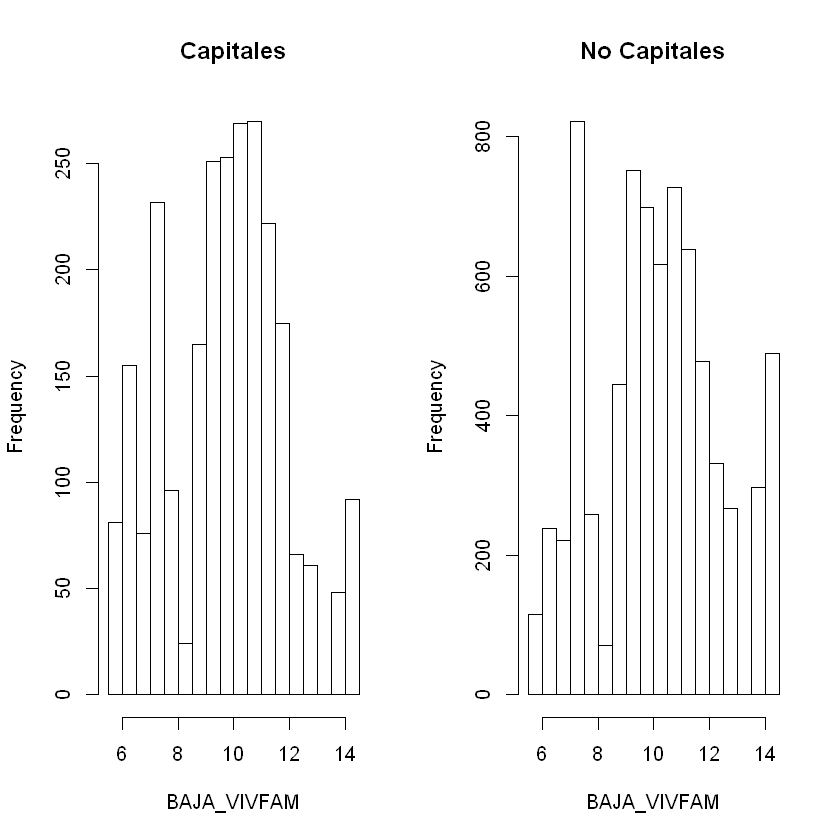

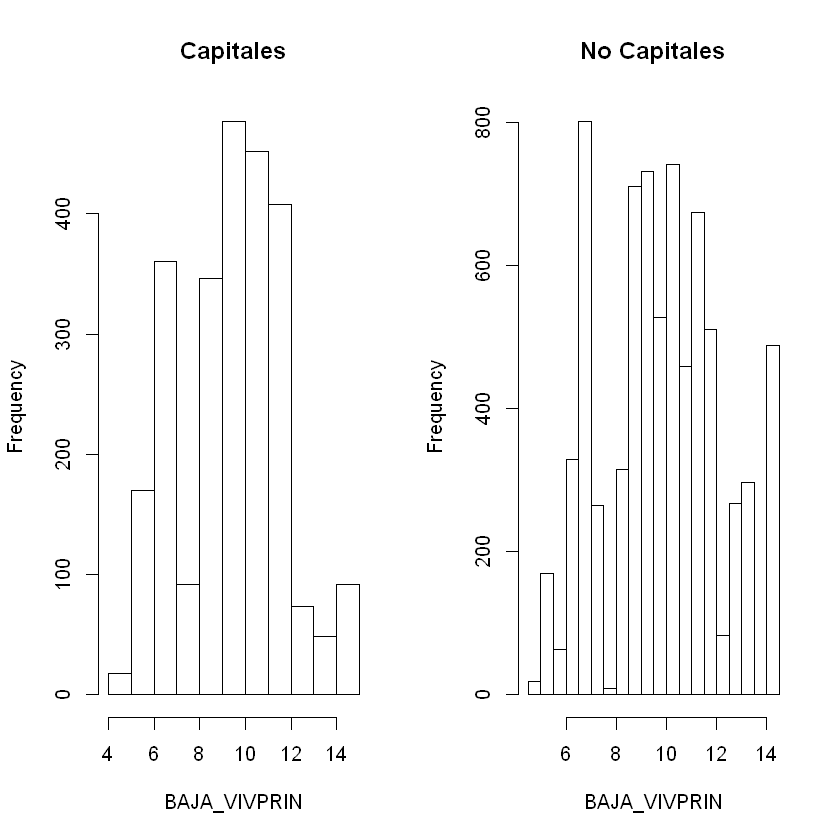

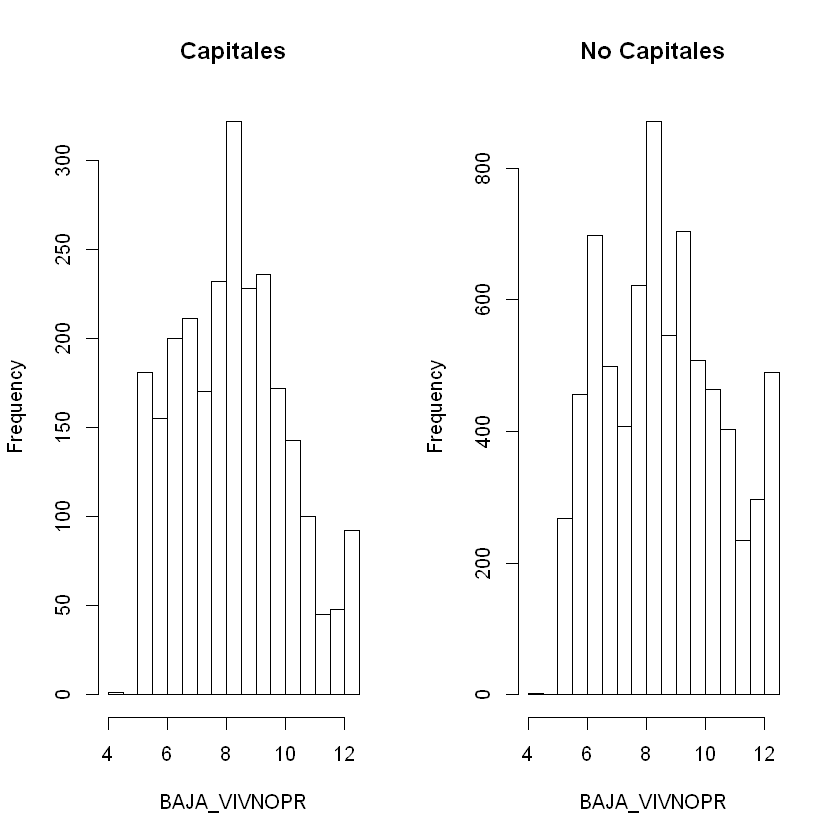

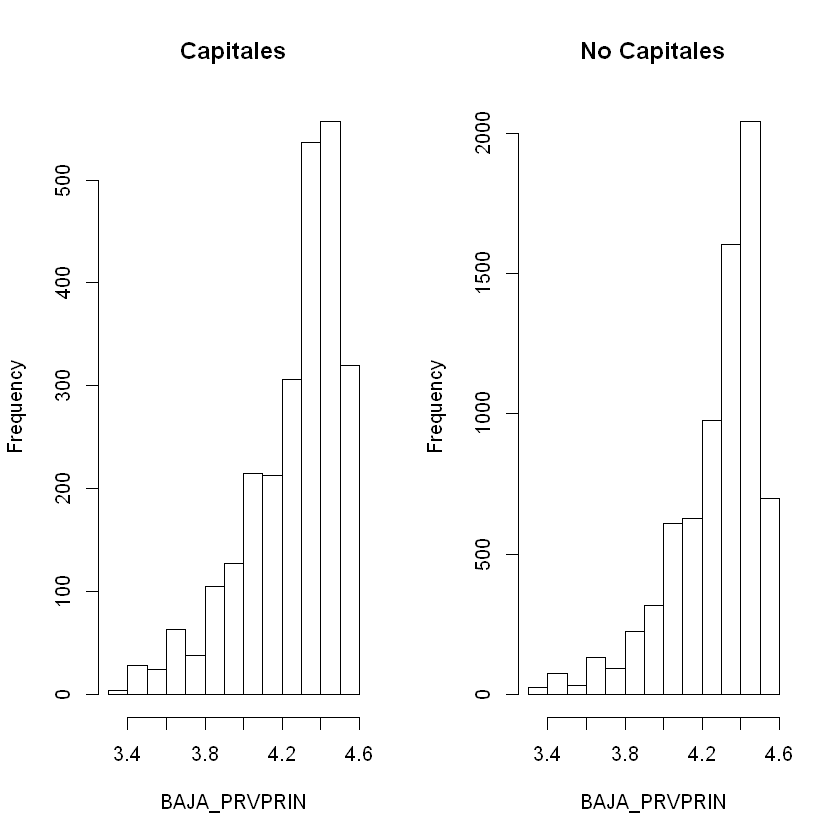

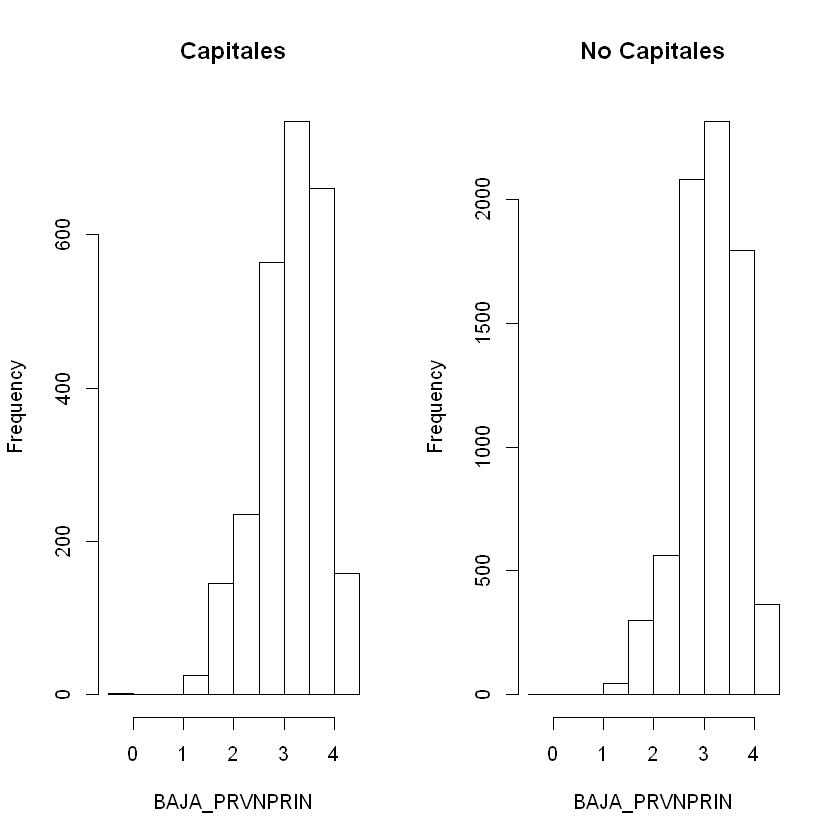

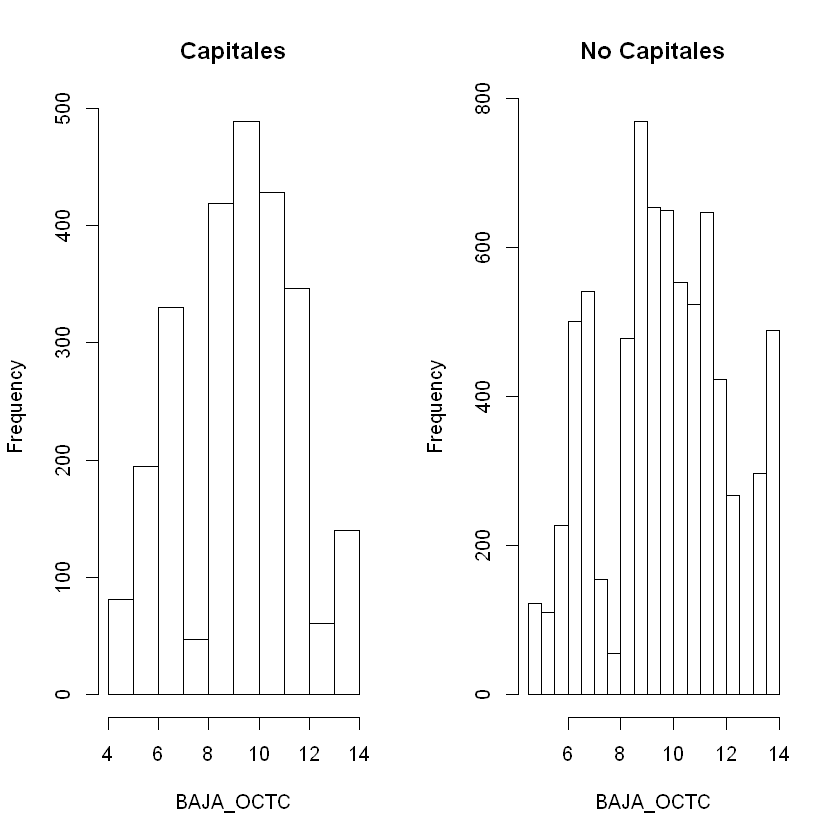

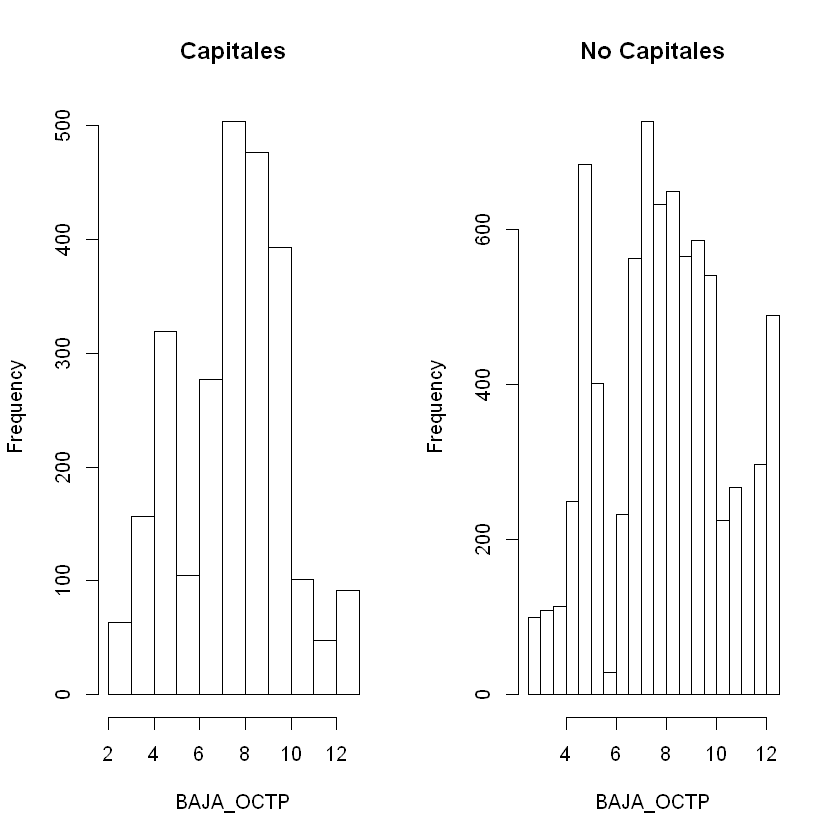

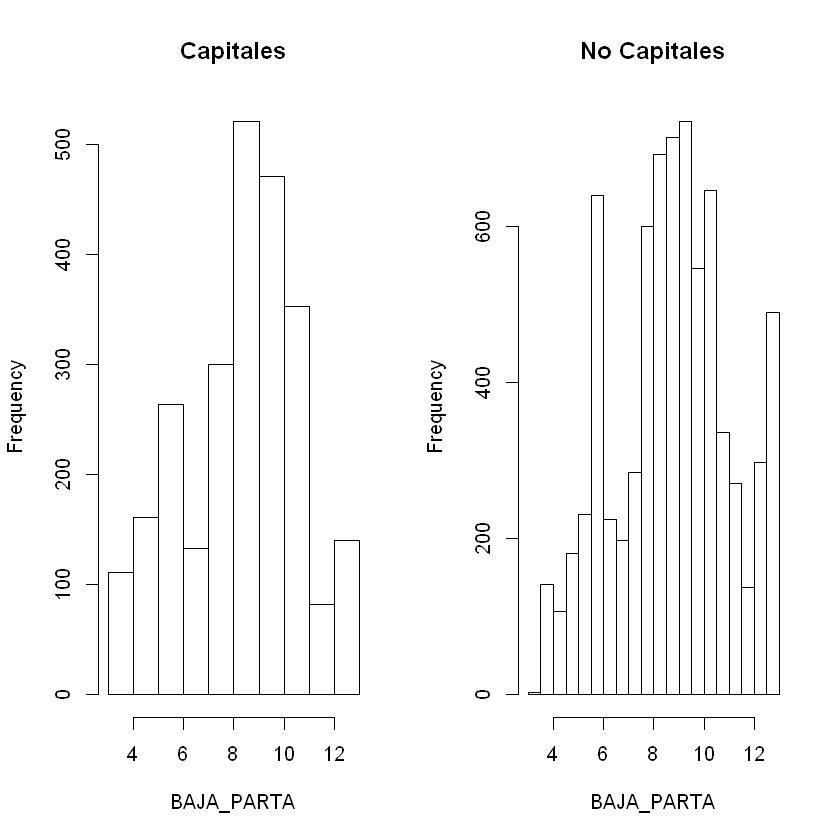

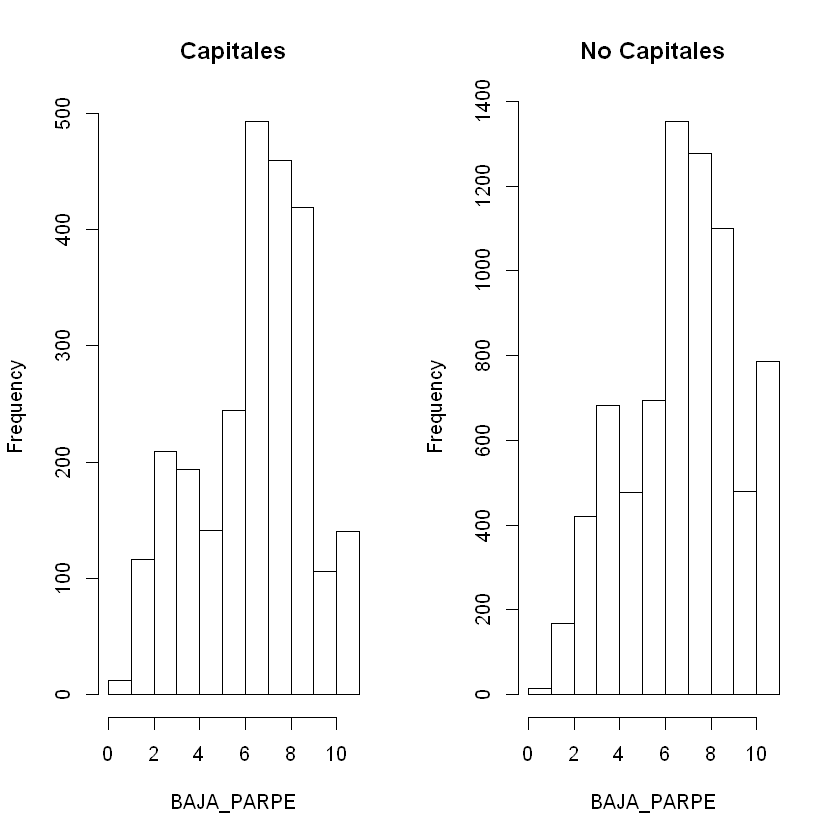

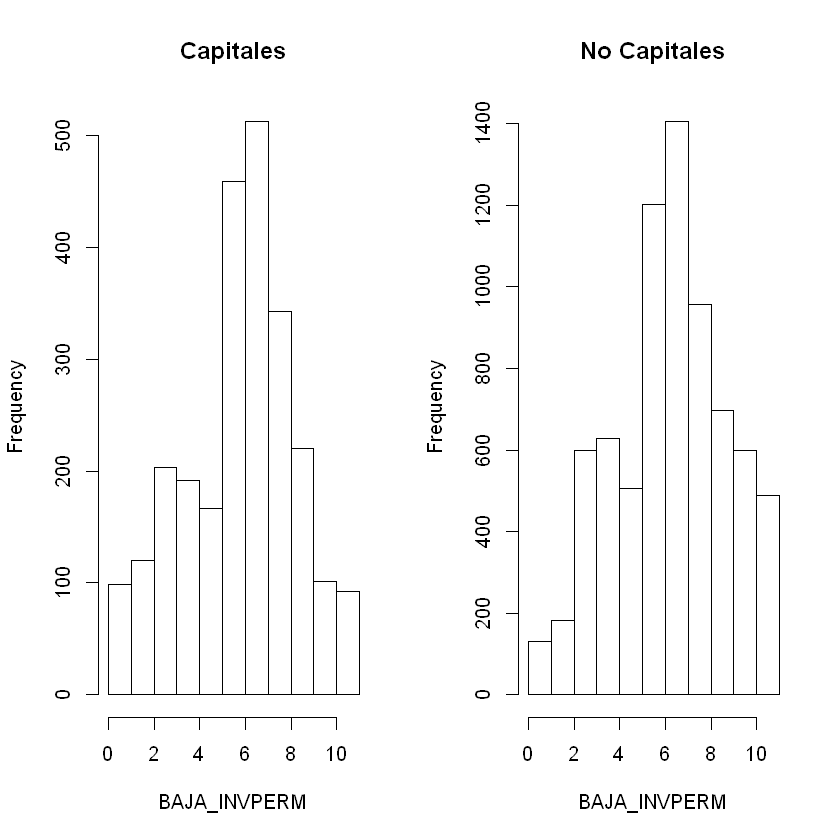

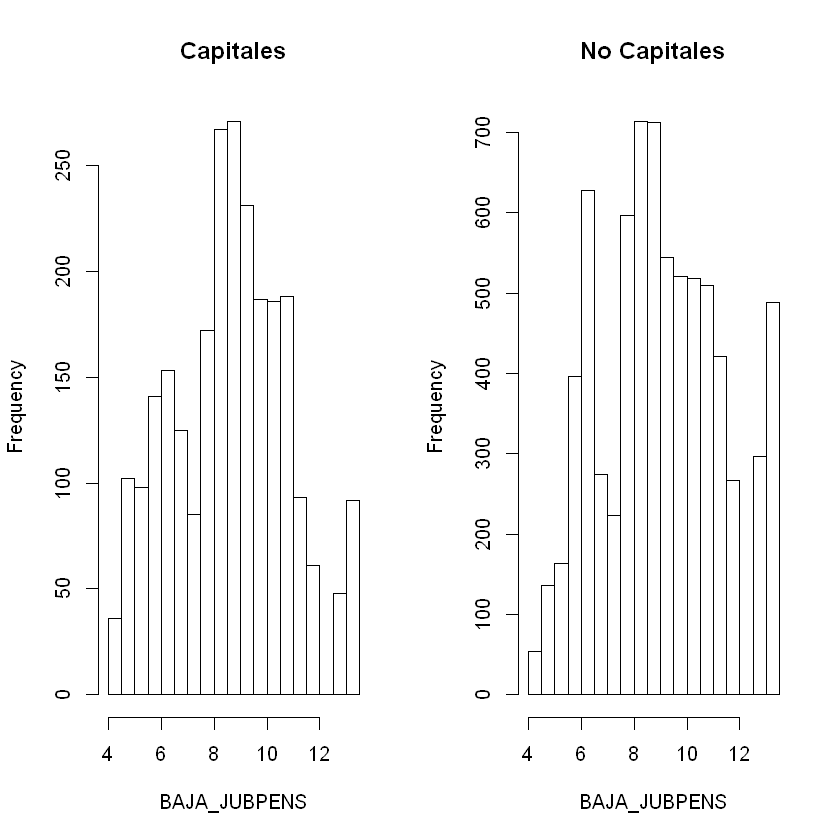

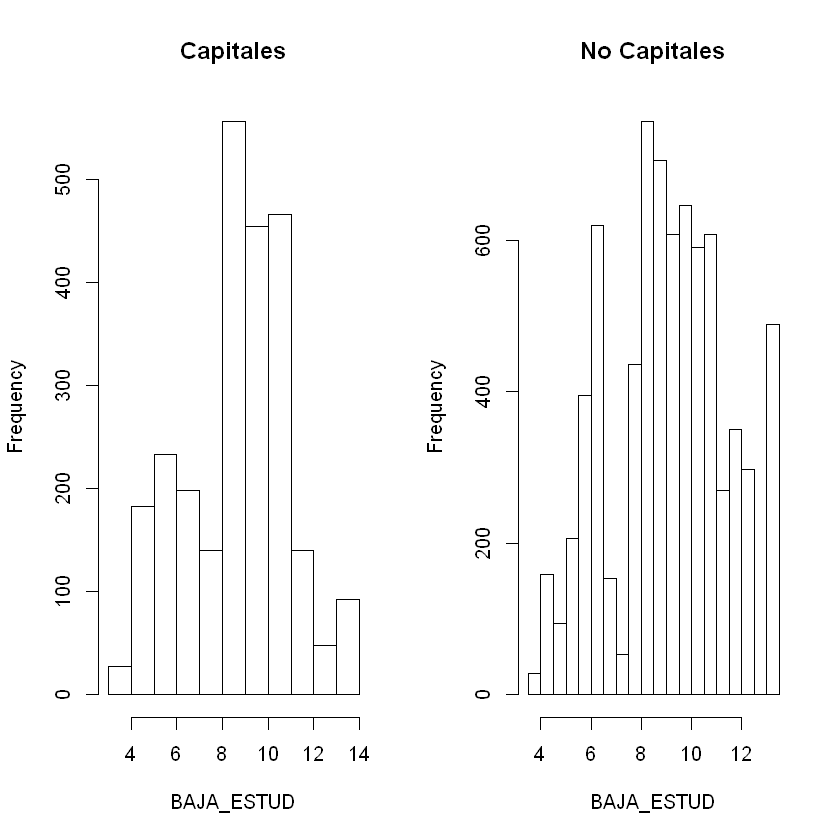

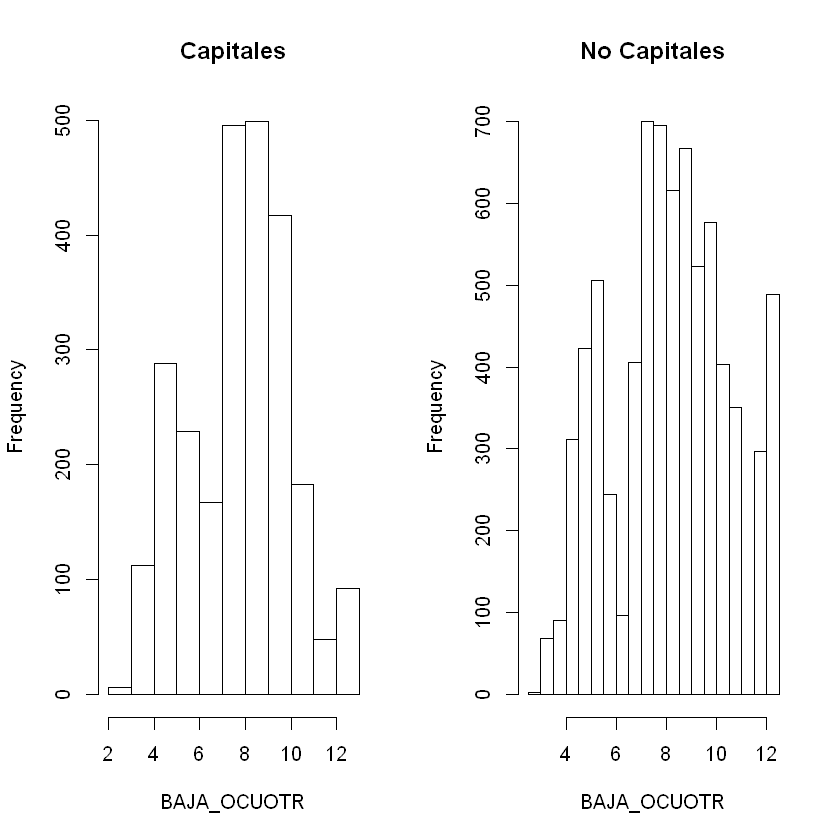

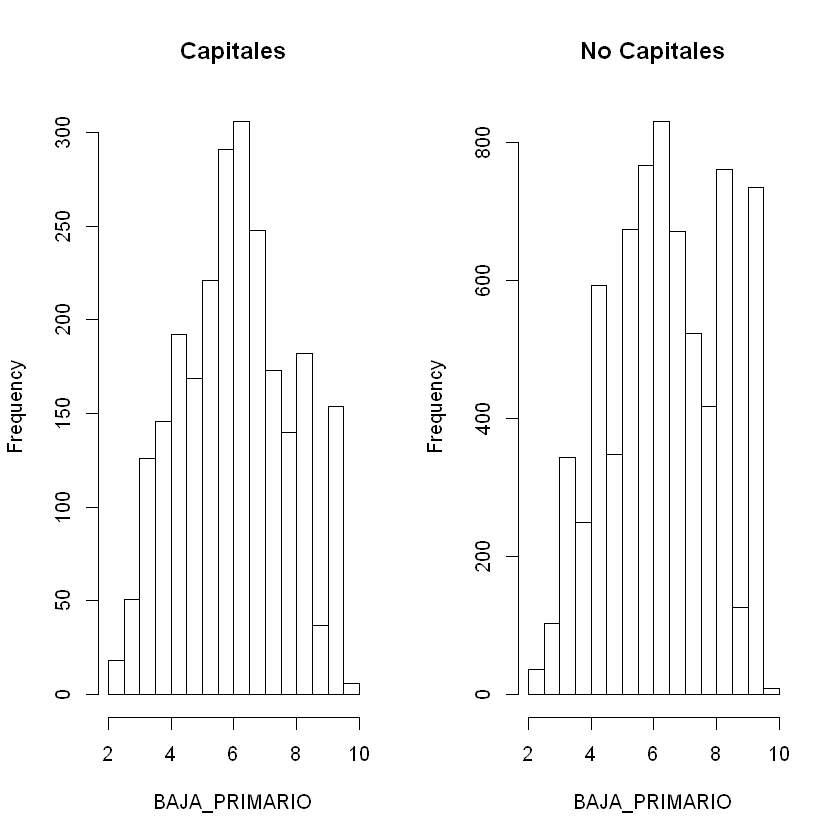

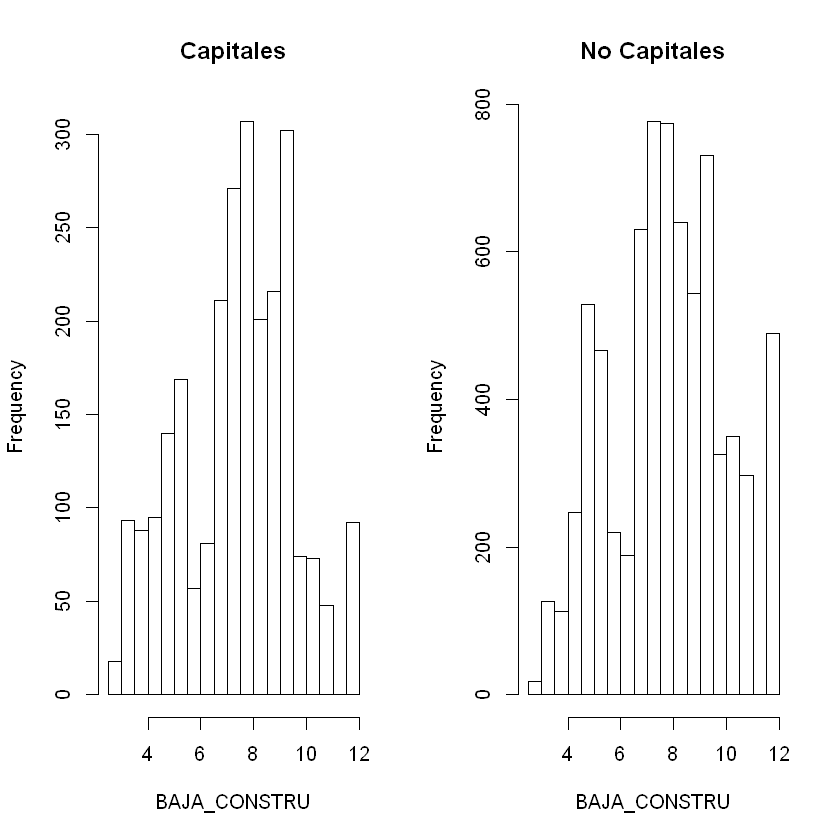

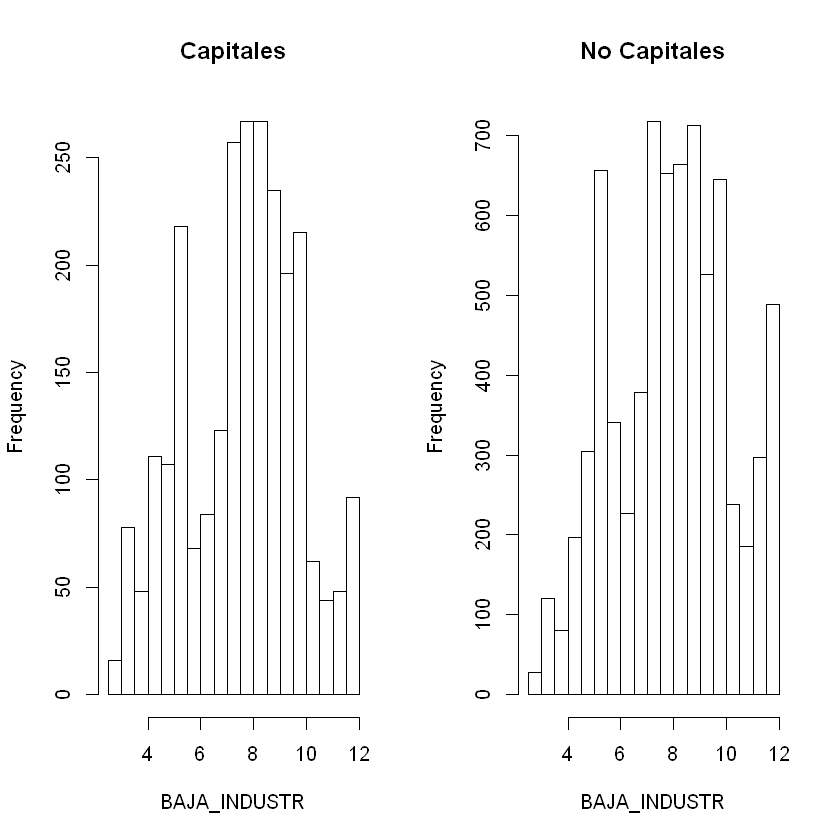

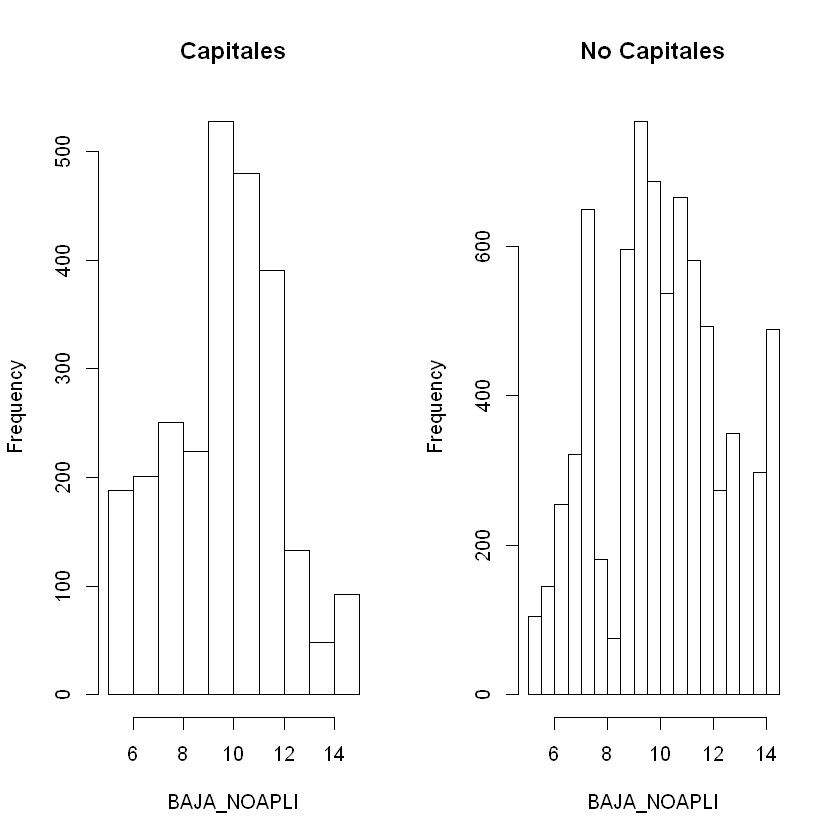

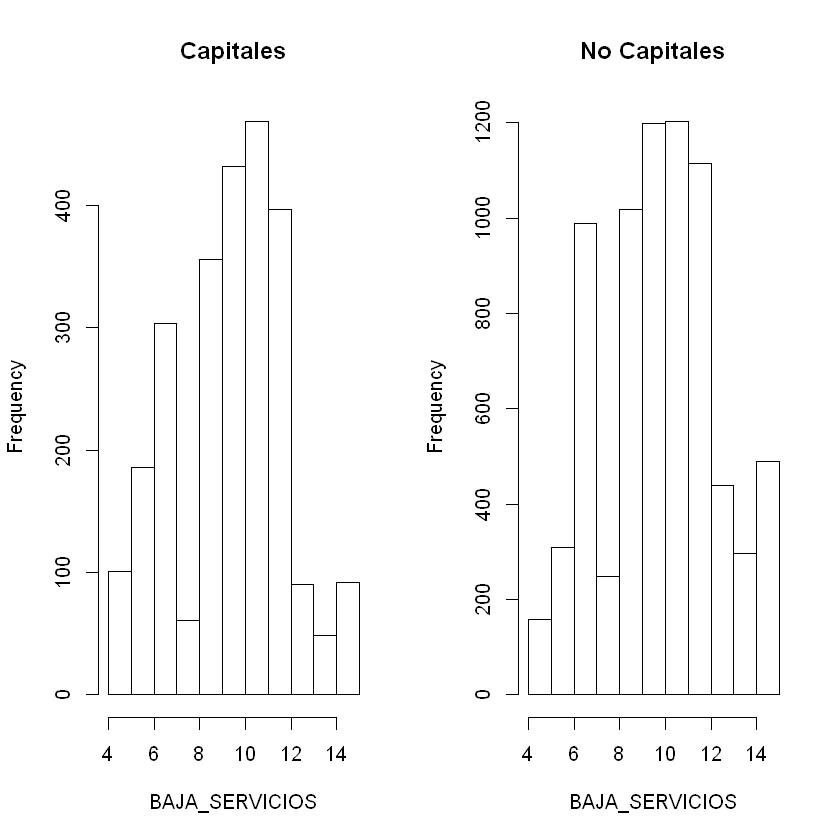

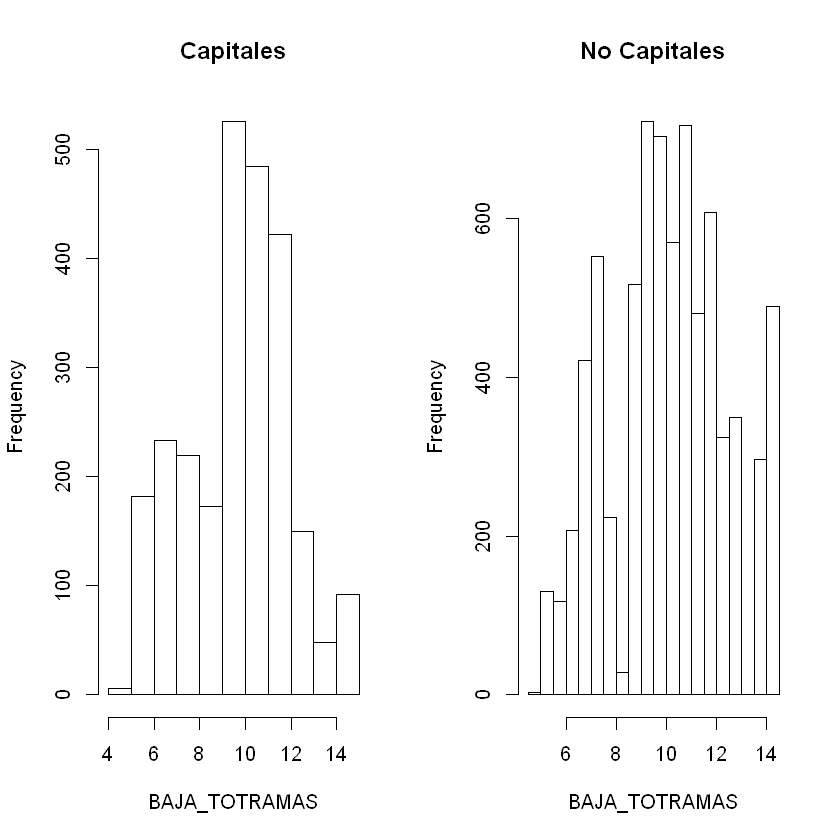

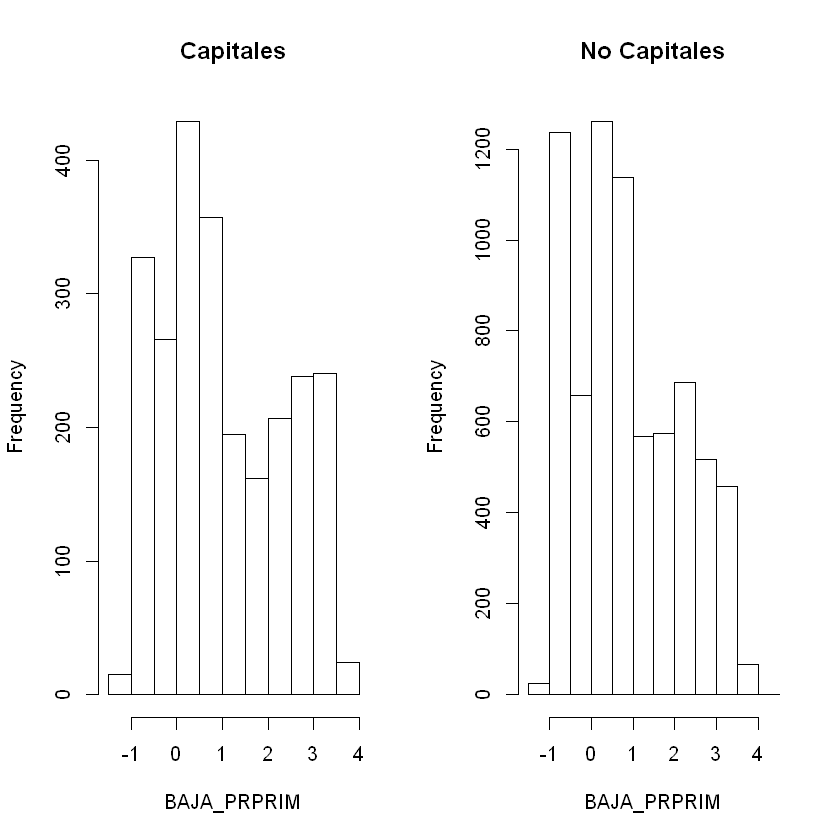

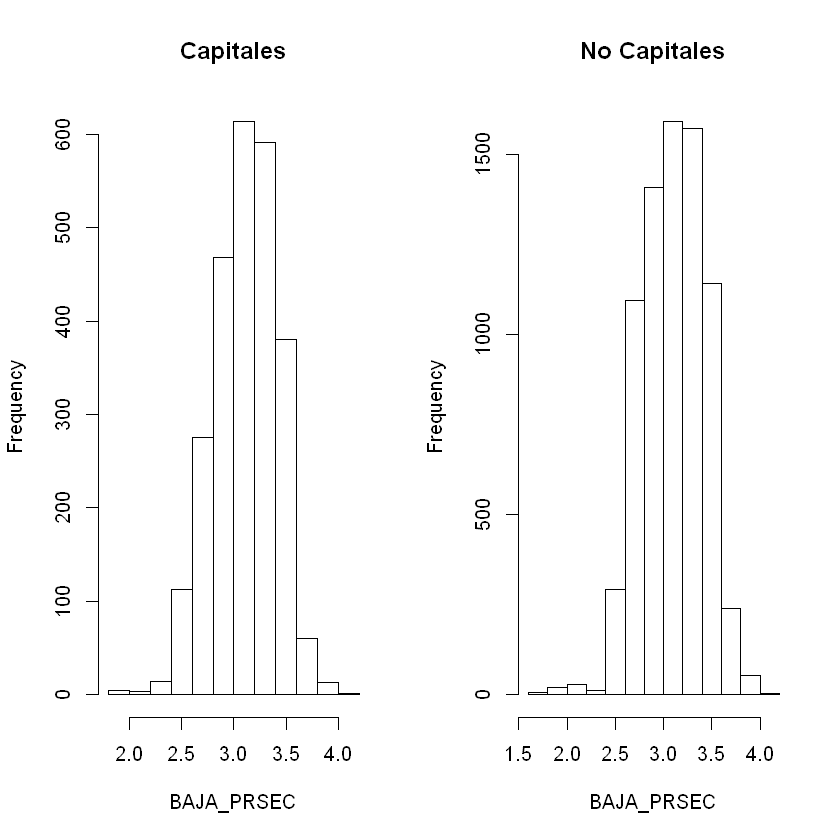

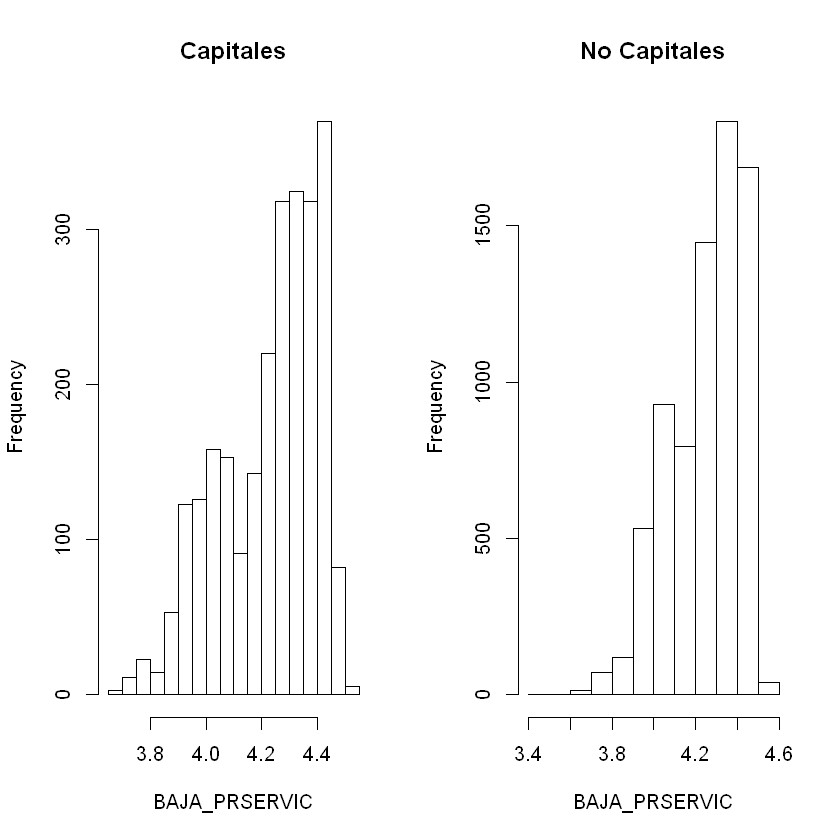

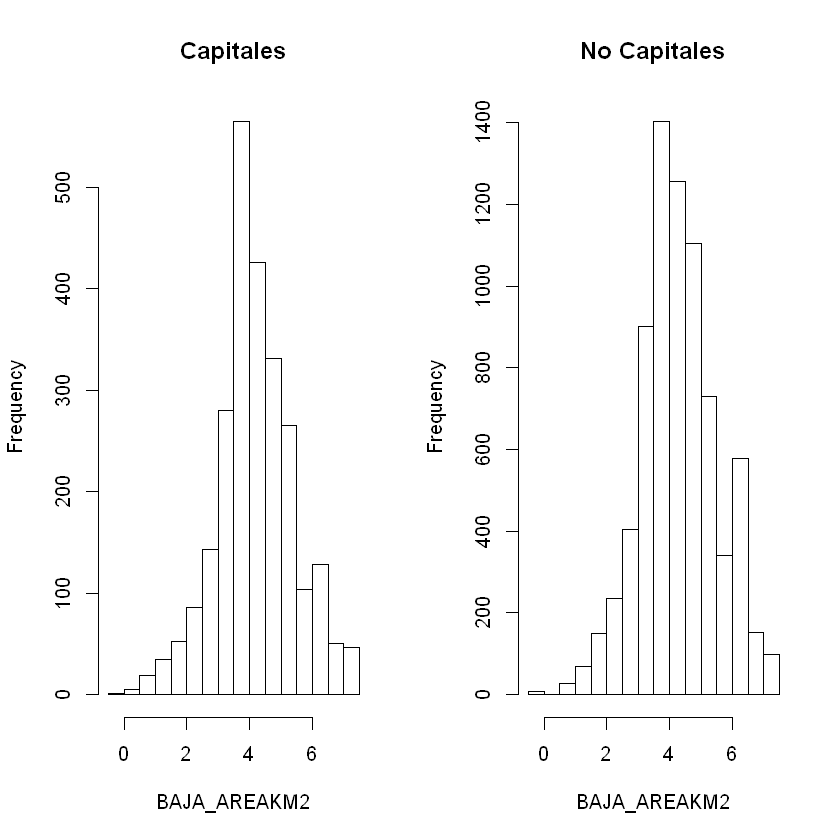

Warning message in log(unlist(nocap[i])):
"NaNs produced"

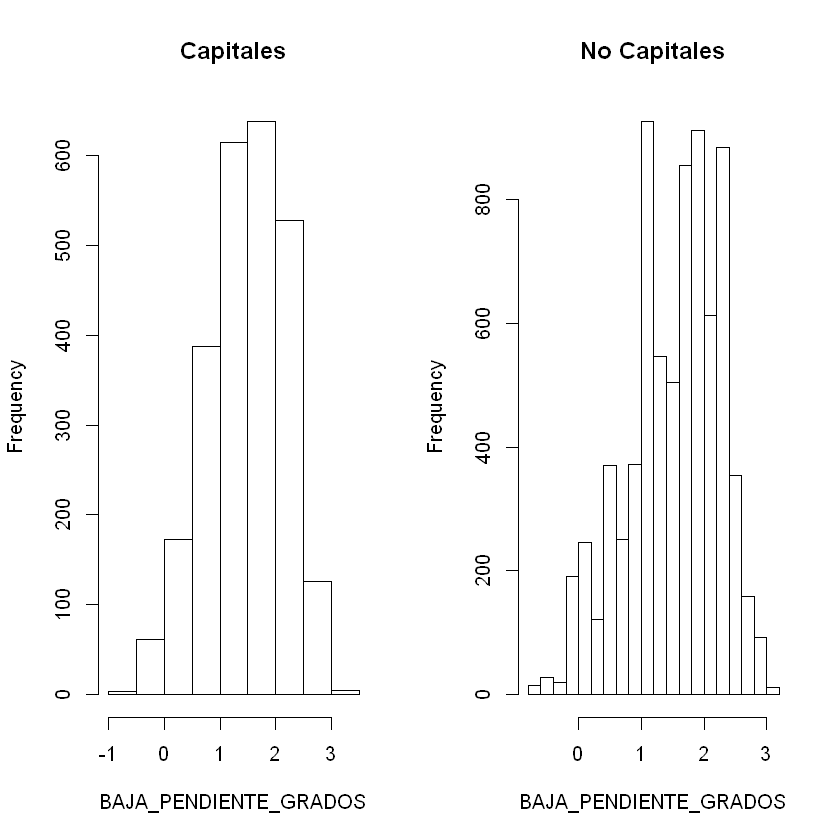

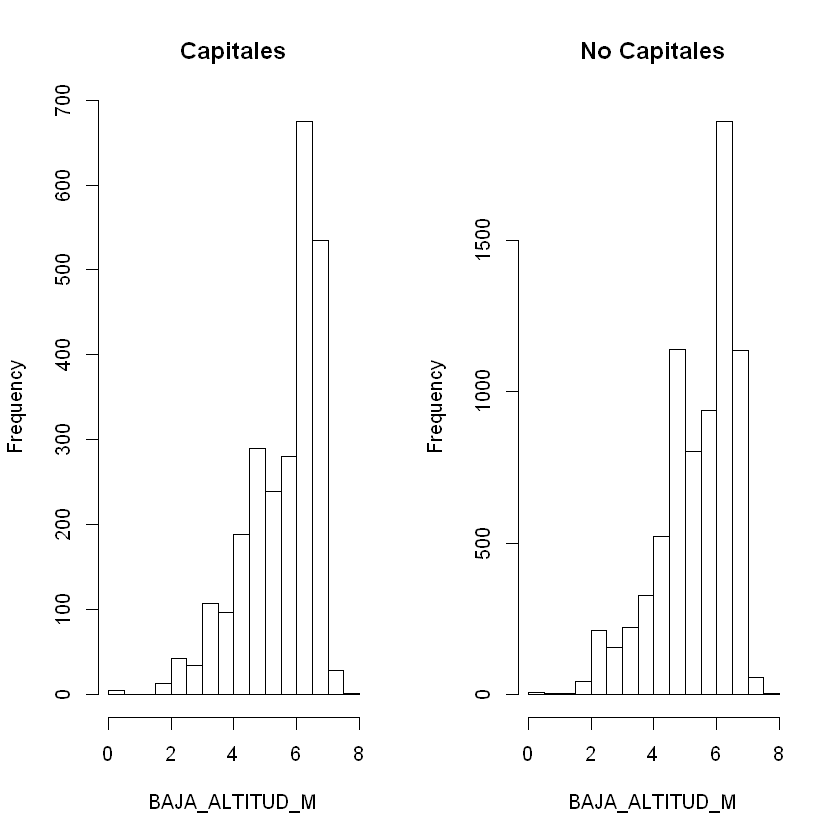

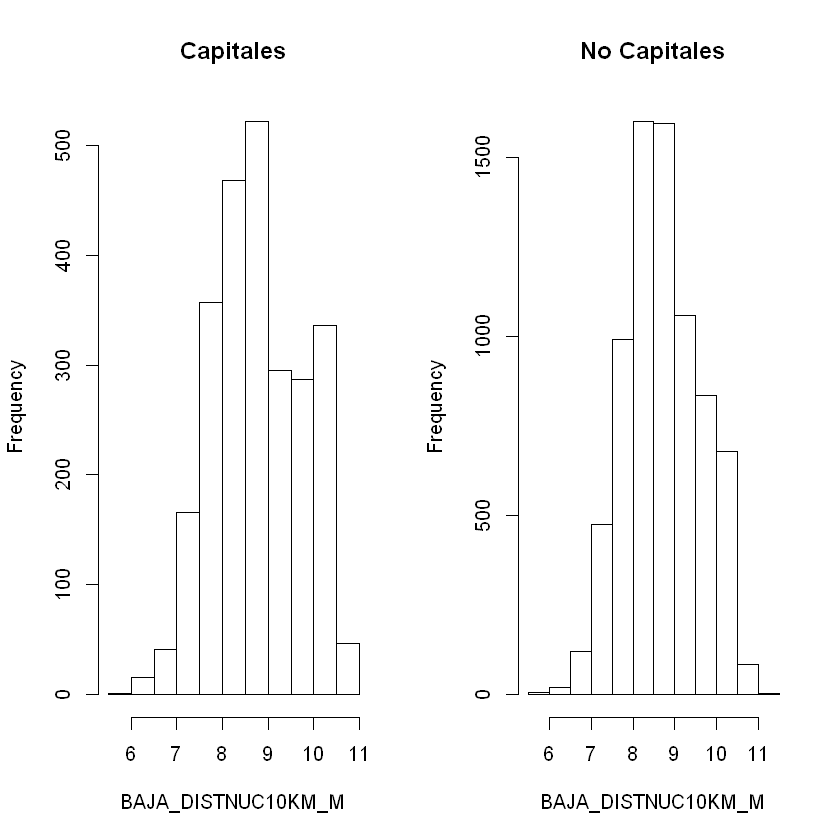

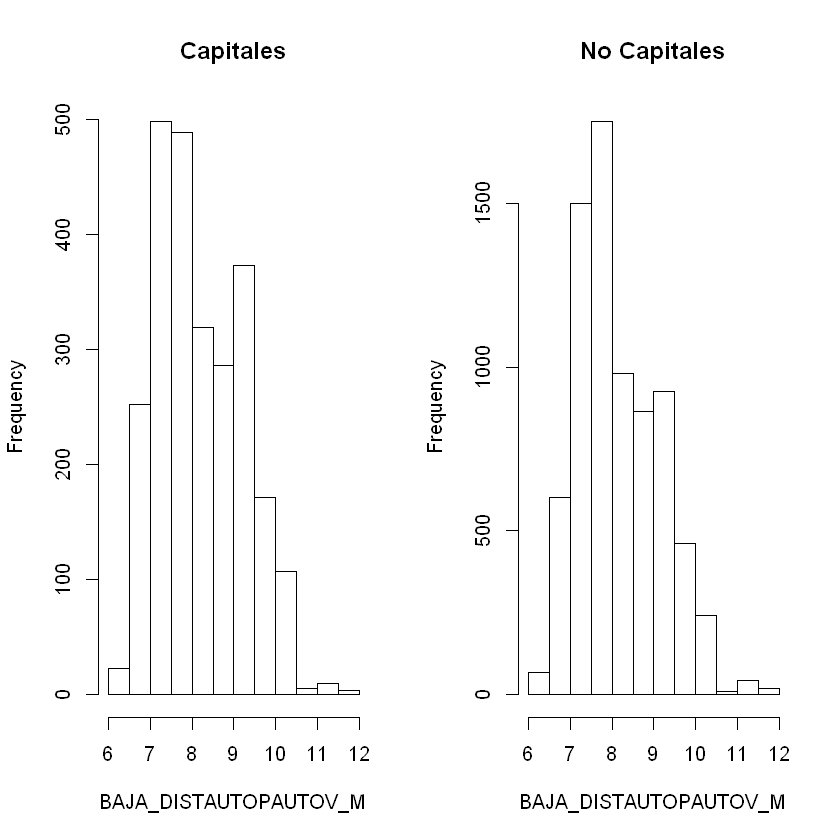

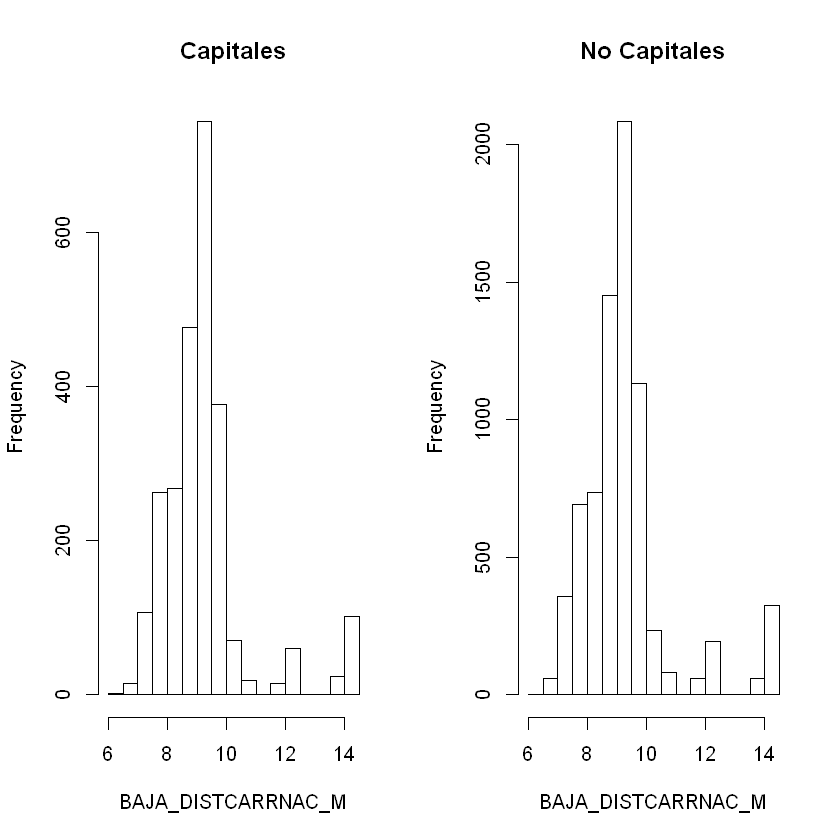

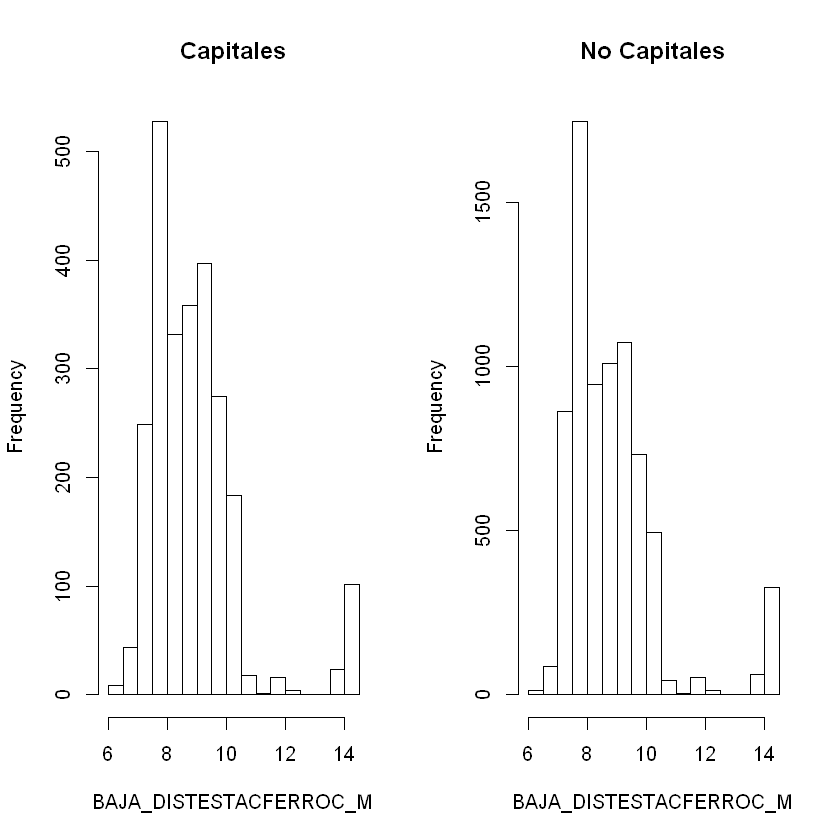

In [19]:
for(i in 2:ncol(db.num)){
    par(mfrow =c(1,2))
    hist(log(unlist(cap[i])), main="Capitales", xlab=names(cap[i]))
    hist(log(unlist(nocap[i])), main="No Capitales", xlab=names(nocap[i]))
}

<br></br>
### Kolmogorov-Smirnov test sobre semejanza de distribuciones:

In [20]:
pvalues <- c()
distance <- c()
names <- c()

for(i in 2:ncol(db.num)){

    a = sample(unlist(cap[i]), size=100)
    b = sample(unlist(nocap[i]), size=100)
    
    res <- suppressWarnings(ks.test(a,b))
    
    pvalues[i-1] <- res$p.value
    distance[i-1] <- res$statistic
    names[i-1] <- paste(names(cap[i]),"&",names(nocap[i]))
    }

res <- data.frame(names,pvalues,distance)
print(res)

                                             names      pvalues distance
1                                      EDAD & EDAD 0.9062063896     0.08
2                      BAJA_POB2020 & BAJA_POB2020 0.0366310527     0.20
3                      BAJA_VAR2020 & BAJA_VAR2020 0.5806177649     0.11
4                      BAJA_MUJ2020 & BAJA_MUJ2020 0.9062063896     0.08
5                      BAJA_IMASC20 & BAJA_IMASC20 0.4675585921     0.12
6                      BAJA_TC16A20 & BAJA_TC16A20 0.0366310527     0.20
7                          BAJA_PT0A4 & BAJA_PT0A4 0.3667264439     0.13
8                          BAJA_PT5A9 & BAJA_PT5A9 0.4675585921     0.12
9                      BAJA_PT10A14 & BAJA_PT10A14 0.3667264439     0.13
10                     BAJA_PT15A19 & BAJA_PT15A19 0.3667264439     0.13
11                     BAJA_PT20A24 & BAJA_PT20A24 0.0158141003     0.22
12                     BAJA_PT25A29 & BAJA_PT25A29 0.6993741999     0.10
13                     BAJA_PT30A34 & BAJA_PT30A34 

### Las variables con distribuciones estadísticamente diferentes:
#### (Aun así, la `distancia` no es nada considerable)

In [21]:
res[res$pvalues <= 0.05,]

,names,pvalues,distance
2,BAJA_POB2020 & BAJA_POB2020,0.0366310527,0.20
6,BAJA_TC16A20 & BAJA_TC16A20,0.0366310527,0.20
11,BAJA_PT20A24 & BAJA_PT20A24,0.0158141003,0.22
13,BAJA_PT30A34 & BAJA_PT30A34,0.0002468196,0.30
30,BAJA_MAYOR & BAJA_MAYOR,0.0038609082,0.25
63,BAJA_TOTRAMAS & BAJA_TOTRAMAS,0.0243103130,0.21


### Crear una muestra balanceada de CAP vs. NoCAP:

In [22]:
cap <- subset(db.baja, ALTA_CAPITAL == "CAP")
nocap <- subset(db.baja, ALTA_CAPITAL == "NoCAP")

In [23]:
ind <- sample(1:nrow(nocap), size=nrow(cap))
nocap <- nocap[ind,]

db.bal <- rbind(cap, nocap)

# barajar el conjunto
db.bal <- db.bal[sample(1:nrow(db.bal)), ]  

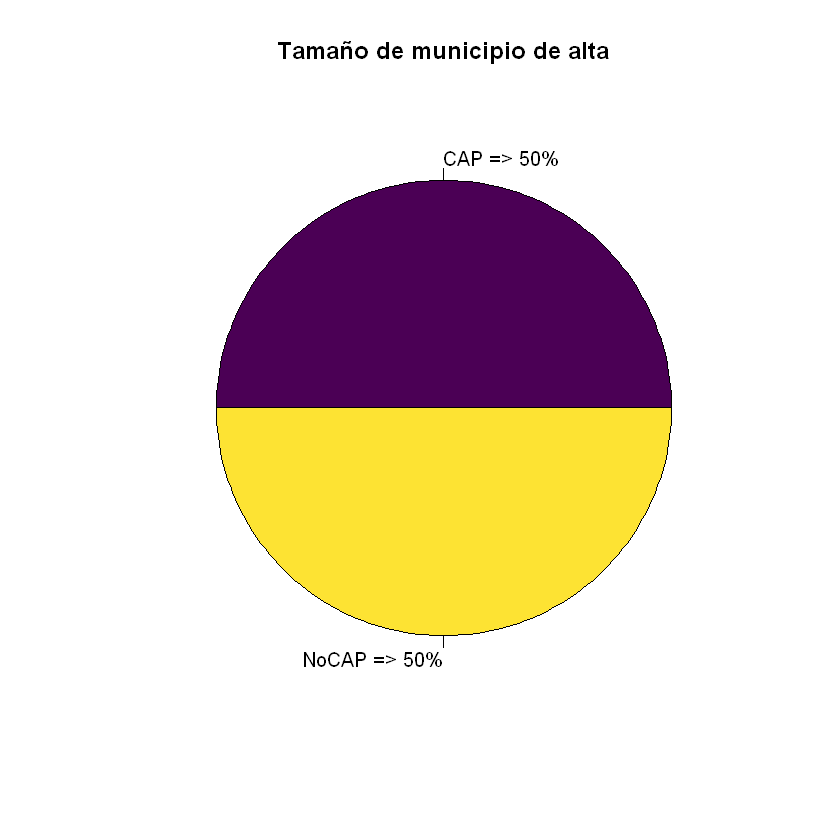

In [24]:
aux <- sort(table(db.bal$ALTA_CAPITAL))
aux <- as.data.frame(aux)

slices <- aux$Freq
lbl <- aux$Var1
pct <- round(slices/sum(slices)*100)
lbl <- paste(lbl, "=>", pct)
lbl <- paste(lbl,"%", sep="")
pie(slices, labels = lbl, col = hcl.colors(length(lbl)),
    main="Tamaño de municipio de alta")

In [25]:
n = nrow(db.bal)

indtrain = sample(1:n, 0.8*n)     # 80% para train
indtest = setdiff(1:n, indtrain)  # 20% para test

bal.train = db.bal[indtrain,]
rownames(bal.train) <- NULL

bal.test = db.bal[indtest,]
rownames(bal.test) <- NULL

### Crear un `tree` con la muestra balanceada:

In [34]:
arbol <- tree(ALTA_CAPITAL ~ ., data = bal.train,
             control=tree.control(nobs=nrow(db.bal), mincut = 1, mindev = 0))

Warning message in node * 2L:
"NAs produced by integer overflow"Warning message in node * 2L:
"NAs produced by integer overflow"

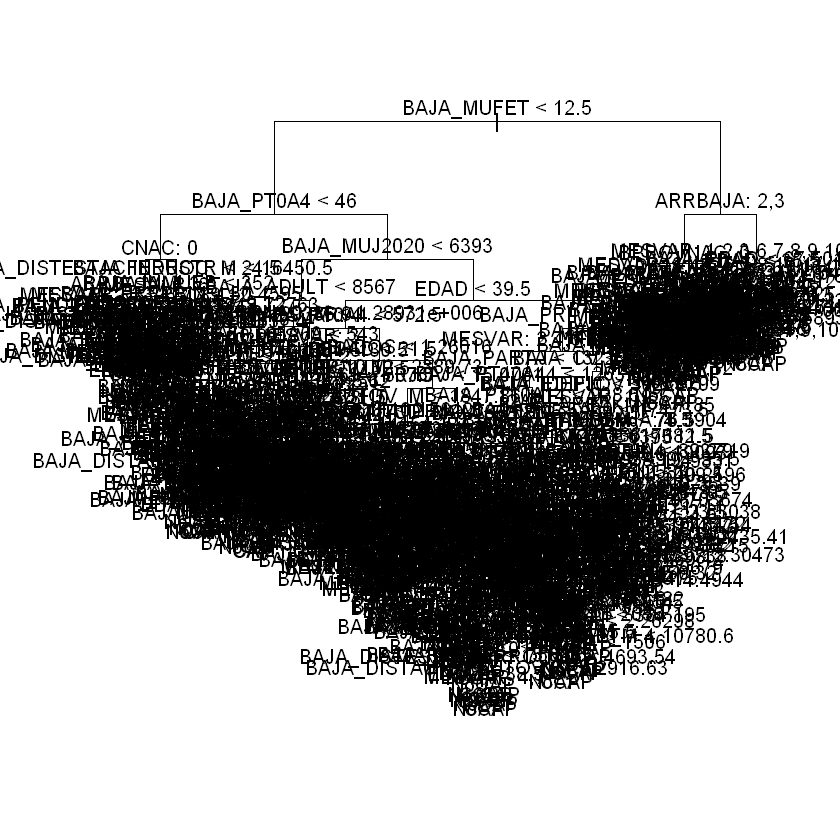

In [35]:
plot(arbol)
text(arbol, pretty=FALSE)

       Length Class  Mode     
size   287    -none- numeric  
dev    287    -none- numeric  
k      287    -none- numeric  
method   1    -none- character

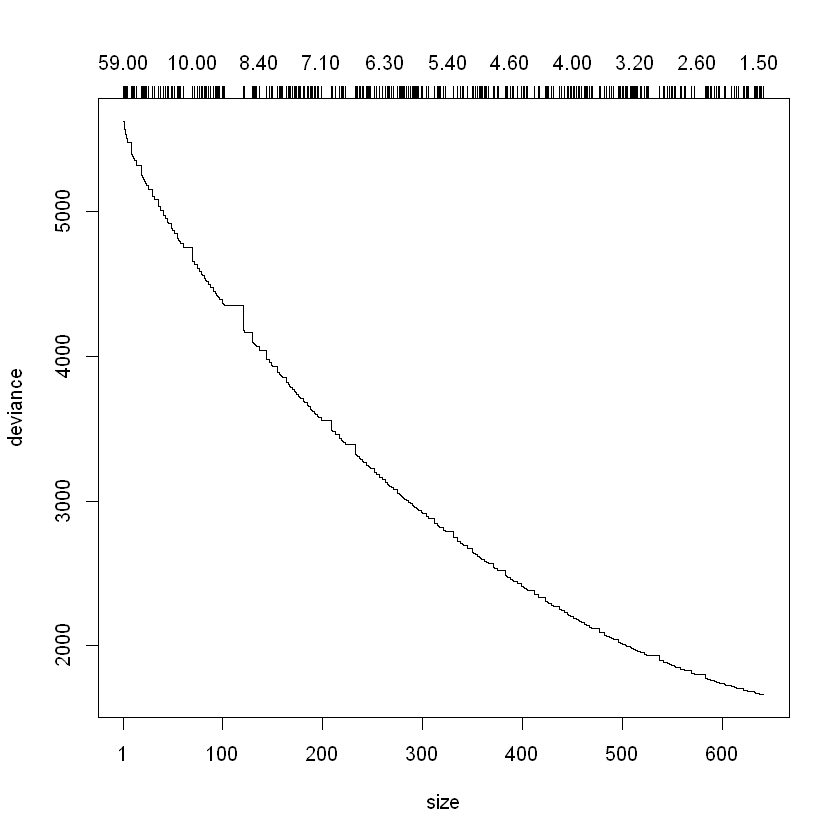

In [36]:
pt <- prune.tree(arbol)
summary(pt)
plot(pt)

### Crear el árbol completo con `rpart` y la muestra balanceada:

In [37]:
rtree = rpart(ALTA_CAPITAL~.,
               data = bal.train,
               method = "class",
               control = rpart.control(minsplit = 2, minbucket = 1, cp = 0)
              )

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

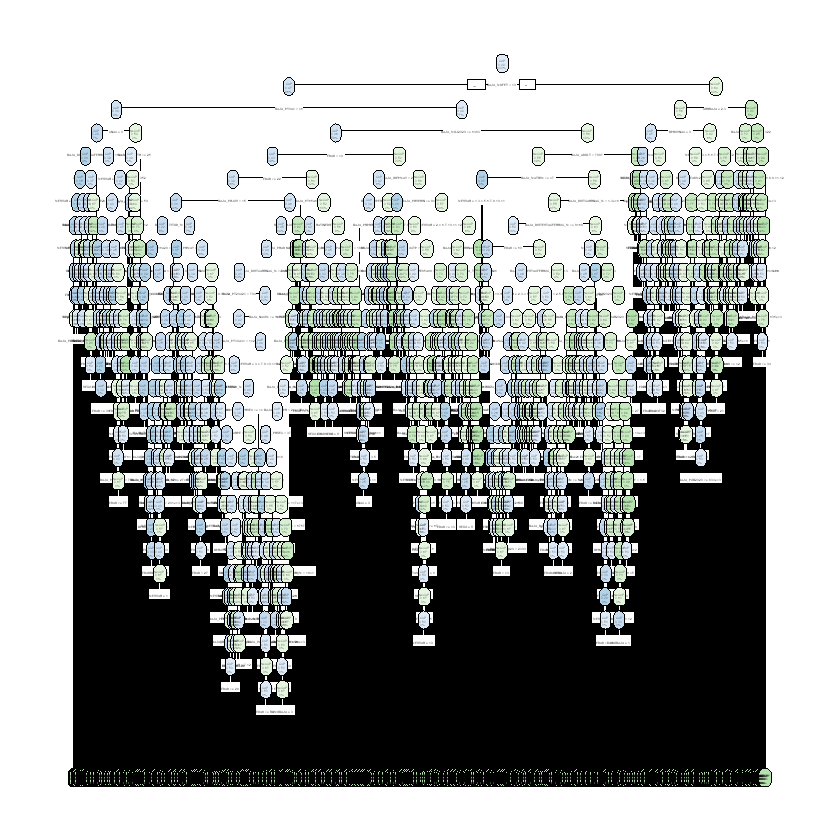

In [38]:
rpart.plot(rtree)

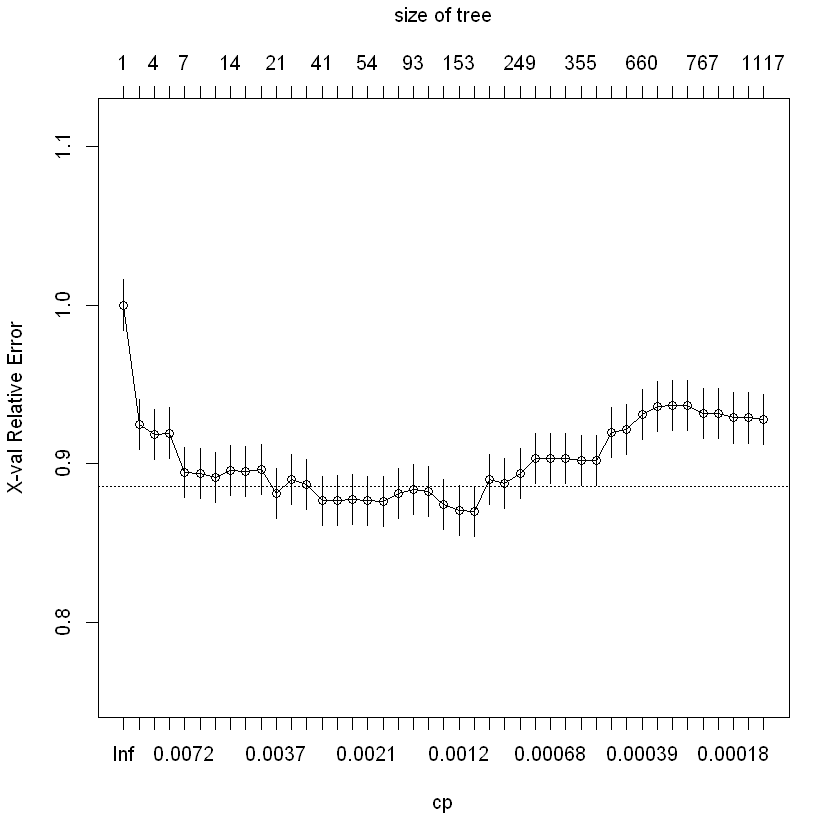

In [39]:
plotcp(rtree)

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

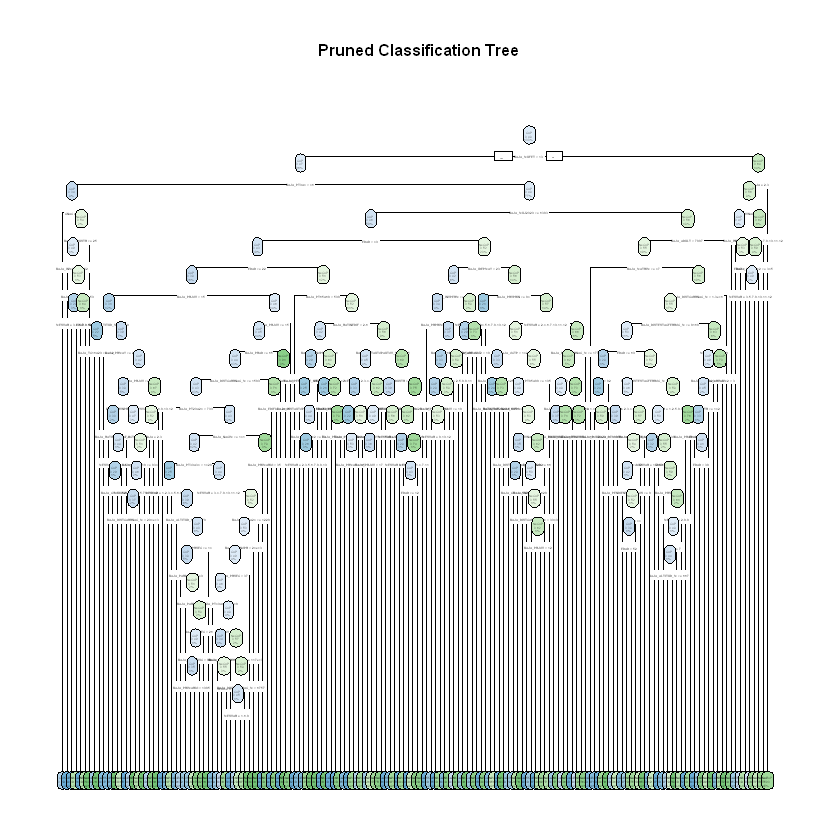

In [40]:
ptree <- prune(rtree,
               cp = rtree$cptable[which.min(rtree$cptable[,"xerror"]),"CP"])

rpart.plot(ptree, uniform=TRUE, main="Pruned Classification Tree")

In [41]:
ptree$variable.importance

MESVAR           BAJA_VAR2020           BAJA_POB2020 
            120.997980              97.786624              88.703734 
                  EDAD             BAJA_PT0A4           BAJA_MUJ2020 
             79.462877              74.572670              71.248367 
            BAJA_PRJOV             BAJA_PT5A9              BAJA_PRAD 
             62.428135              60.957082              49.668446 
            BAJA_PRMAY     BAJA_DISTCARRNAC_M              BAJA_TDEP 
             48.300234              46.338049              46.331609 
BAJA_DISTESTACFERROC_M           BAJA_AREAKM2  BAJA_DISTAUTOPAUTOV_M 
             46.215375              44.150017              43.874453 
          BAJA_IDEPJOV                BAJA_CV           BAJA_IDEPMAY 
             43.598865              43.172145              42.932382 
          BAJA_IMASC20             BAJA_MUFET             BAJA_ADULT 
             42.228523              37.378912              33.810287 
          BAJA_PRVPRIN          BAJA_PRSERVIC             BAJA_PRSEC 
             33.371641              32.749573              31.171979 
          BAJA_PT15A19     BAJA_DISTNUC10KM_M         BAJA_RATINEDIF 
             30.483391              29.993361              29.508413 
         BAJA_PRVNPRIN             BAJA_NACIM            BAJA_PRPRIM 
             28.097112              27.896543              27.891288 
            BAJA_JOVEN           BAJA_PT40A44           BAJA_PT10A14 
             26.674352              26.486973              25.991176 
        BAJA_ALTITUD_M             BAJA_MAYOR          BAJA_PRIMARIO 
             24.629000              24.393156              24.225513 
               ARRBAJA          BAJA_TOTRAMAS           BAJA_PT20A24 
             23.446565              23.106339              22.771313 
             BAJA_OCTC           BAJA_PT30A34           BAJA_VIVNOPR 
             21.983818              21.956150              21.072277 
          BAJA_PT85A89           BAJA_PT100YM           BAJA_PT35A39 
             20.727788              20.598686              19.992172 
          BAJA_TC16A20           BAJA_PT75A79           BAJA_INDUSTR 
             19.948375              19.516771              19.147023 
          BAJA_PT95A99           BAJA_PT90A94            BAJA_VIVFAM 
             18.604925              18.162274              17.489124 
              BPROVNAC           BAJA_PT25A29            BAJA_INMUEB 
             17.391942              16.482154              16.290791 
          BAJA_PT45A49            BAJA_MATRIM                   CNAC 
             16.150943              15.865166              15.542981 
            BAJA_PARPE           BAJA_PT65A69  BAJA_PENDIENTE_GRADOS 
             15.260058              15.103570              15.016428 
           BAJA_EDIFIC              BAJA_OCTP           BAJA_PT70A74 
             14.063492              14.055990              13.982796 
          BAJA_INVPERM             BAJA_PARTA           BAJA_VIVPRIN 
             13.419052              13.341910              12.288666 
          BAJA_PT80A84            BAJA_NOAPLI           BAJA_CONSTRU 
             11.926746              11.372153               8.611006 
          BAJA_JUBPENS           BAJA_PT55A59         BAJA_SERVICIOS 
              8.023306               6.554444               6.512736 
           BAJA_OCUOTR            BAJA_FALLEC               TAMUBAJA 
              6.418488               5.390618               4.523556 
          BAJA_PT60A64                   SEXO           BAJA_PT50A54 
              3.832099               3.449495               2.227807

#### Accuracy de train del árbol completo:

In [42]:
pred = predict(rtree, bal.train, type = "class")

acc.class(pred, bal.train$ALTA_CAPITAL)

[1] 0.999507

#### Accuracy de train del árbol podado:

In [43]:
pred.pruned = predict(ptree, bal.train, type = "class")

acc.class(pred.pruned, bal.train$ALTA_CAPITAL)

[1] 0.7722455

#### Accuracy de test del árbol completo:

In [44]:
pred = predict(rtree, bal.test, type = "class")

acc.class(pred, bal.test$ALTA_CAPITAL)

[1] 0.5320197

#### Accuracy de test del árbol podado:

In [45]:
pred.pruned = predict(ptree, bal.test, type = "class")

acc.class(pred.pruned, bal.test$ALTA_CAPITAL)

[1] 0.5852217

### Probar lo mismo pero solo con 3 predictores más importantes:

In [46]:
minitree = rpart(ALTA_CAPITAL~ BAJA_POB2020 + MESVAR + EDAD,
               data = bal.train,
               method = "class",
               control = rpart.control(minsplit = 2, minbucket = 1, cp = 0)
              )

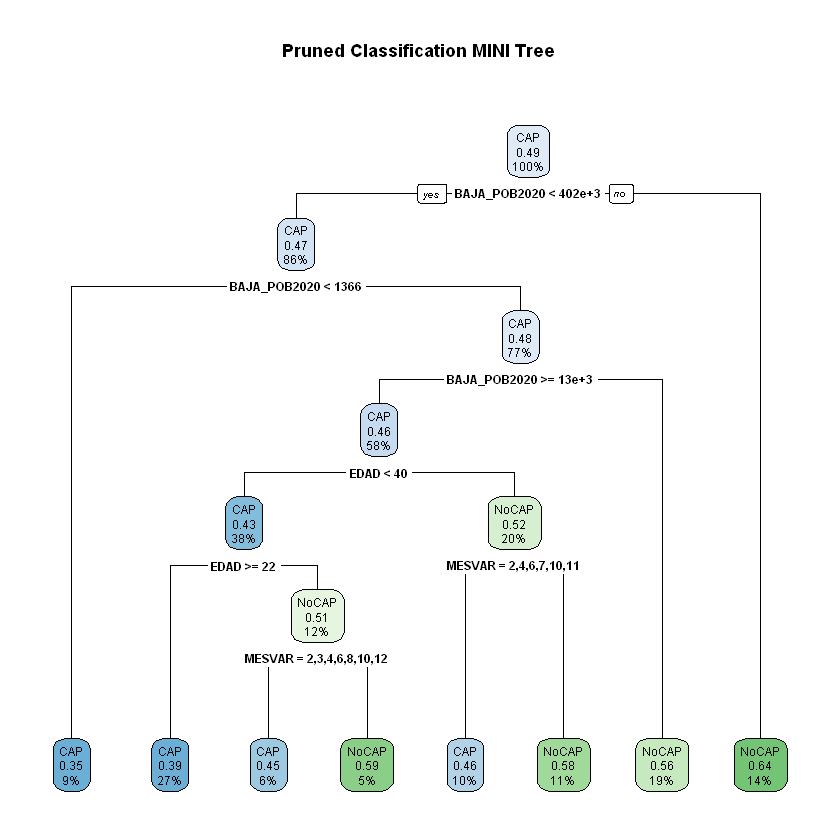

In [47]:
mini.ptree <- prune(minitree,
               cp = minitree$cptable[which.min(minitree$cptable[,"xerror"]),"CP"])

rpart.plot(mini.ptree, uniform=TRUE, main="Pruned Classification MINI Tree")

#### Accuracy en train:

In [48]:
pred.pruned = predict(mini.ptree, bal.train, type = "class")

acc.class(pred.pruned, bal.train$ALTA_CAPITAL)

[1] 0.5913236

#### Accuracy en test:

In [49]:
pred.pruned = predict(mini.ptree, bal.test, type = "class")

acc.class(pred.pruned, bal.test$ALTA_CAPITAL)

[1] 0.5566502

### Probar otro modelo multiclase (con división triple):

In [ ]:
# db_joined <- read.csv(choose.files())

# db_joined$MESVAR <- as.factor(db_joined$MESVAR)
# db_joined$CNAC <- as.factor(db_joined$CNAC)
# db_joined$BPROVNAC <- as.factor(db_joined$BPROVNAC)
# db_joined$TAMUBAJA <- as.factor(db_joined$TAMUBAJA)
# db_joined$ARRBAJA <- as.factor(db_joined$ARRBAJA)
# db_joined$TAMUALTA <- as.factor(db_joined$TAMUALTA)

# baja <- grepl("BAJA", names(db_joined), fixed = TRUE)

# baja_ind <- names(db_joined)[baja][-c(1,2,3)]

# selection <- c("SEXO","EDAD","MESVAR","CNAC","BPROVNAC","ARRALTA", # variables personales
#                baja_ind, # variables municipales de BAJA 
#                "TAMUALTA" # variable objetivo)

# db_joined <- db_joined[selection]

Convertimos:  
- Los municipios de categoría 1 y 2 a **P**equeño  
- Los municipios de categoría 3 y 4 a **M**ediano  
- Los municipios de categoría 5 y 6 a **G**rande

In [36]:
db_joined$CATALTA <- NA

db_joined[db_joined$TAMUALTA == 1,]$CATALTA <- "P"
db_joined[db_joined$TAMUALTA == 2,]$CATALTA <- "P"

db_joined[db_joined$TAMUALTA == 3,]$CATALTA <- "M"
db_joined[db_joined$TAMUALTA == 4,]$CATALTA <- "M"

db_joined[db_joined$TAMUALTA == 5,]$CATALTA <- "G"
db_joined[db_joined$TAMUALTA == 6,]$CATALTA <- "G"

db_joined$CATALTA <- as.factor(db_joined$CATALTA)

In [49]:
rows = sample(1:nrow(db_joined), 10000)
db.mcat <- db_joined[rows,]
rownames(db.mcat) <- NULL
db.mcat$TAMUALTA <- NULL
# rm(db_joined)

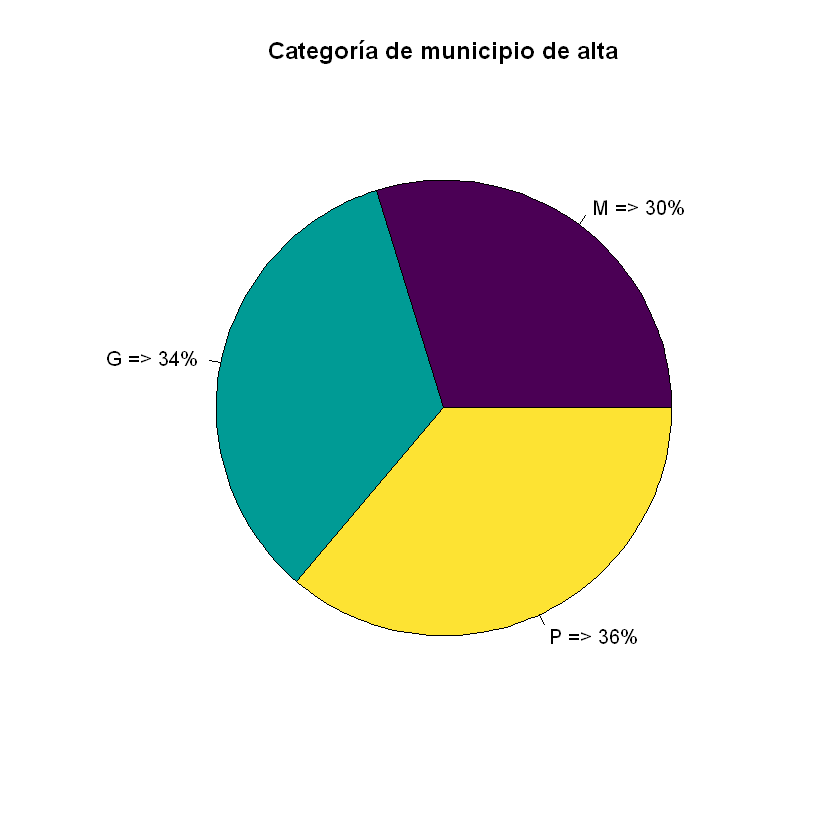

In [39]:
aux <- sort(table(db.mcat$CATALTA))
aux <- as.data.frame(aux)

slices <- aux$Freq
lbl <- aux$Var1
pct <- round(slices/sum(slices)*100)
lbl <- paste(lbl, "=>", pct)
lbl <- paste(lbl,"%", sep="")
pie(slices, labels = lbl, col = hcl.colors(length(lbl)),
    main="Categoría de municipio de alta")

In [50]:
n = nrow(db.mcat)

indtrain = sample(1:n, 0.8*n)     # 80% para train
indtest = setdiff(1:n, indtrain)  # 20% para test

mcat.train = db.mcat[indtrain,]
rownames(mcat.train) <- NULL

mcat.test = db.mcat[indtest,]
rownames(mcat.test) <- NULL

### Con `tree`

In [52]:
arbol = tree(CATALTA~., mcat.train,
             control=tree.control(nobs=nrow(mcat.train), mincut = 1, mindev = 0))

In [53]:
pred = predict(arbol, mcat.train, type = "class")

acc.class(pred, mcat.train$CATALTA)

[1] 0.77175

In [54]:
pred = predict(arbol, mcat.test, type = "class")

acc.class(pred, mcat.test$CATALTA)

[1] 0.377

### Con `rpart`

In [55]:
rtree = rpart(CATALTA~.,
               data = mcat.train,
               method = "class",
               control = rpart.control(minsplit = 2, minbucket = 1, cp = 0)
              )

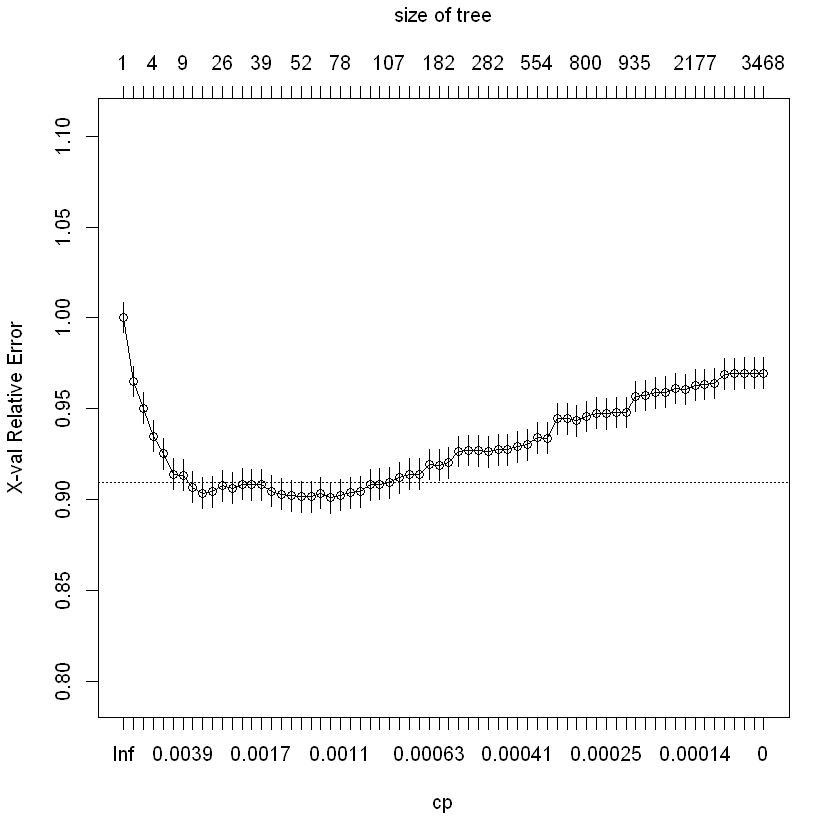

In [56]:
plotcp(rtree)

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

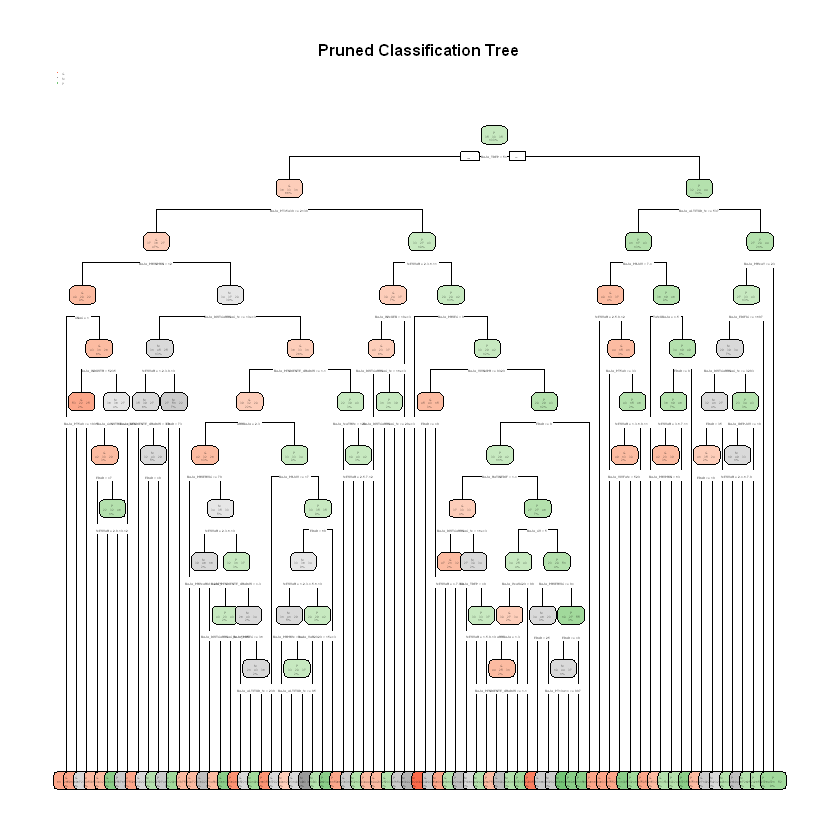

In [57]:
ptree <- prune(rtree,
               cp = rtree$cptable[which.min(rtree$cptable[,"xerror"]),"CP"])

rpart.plot(ptree, uniform=TRUE, main="Pruned Classification Tree")

In [58]:
pred.pruned = predict(ptree, mcat.train, type = "class")

acc.class(pred.pruned, mcat.train$CATALTA)

[1] 0.511375

In [59]:
pred.pruned = predict(ptree, mcat.test, type = "class")

acc.class(pred.pruned, mcat.test$CATALTA)

[1] 0.419

In [60]:
ptree$variable.importance

BAJA_IDEPMAY              BAJA_TDEP              BAJA_PRAD 
           71.11465067            70.97594734            66.18928082 
            BAJA_PRMAY                 MESVAR                   EDAD 
           62.68793984            61.61973253            59.11321597 
            BAJA_PT5A9           BAJA_VAR2020           BAJA_PT10A14 
           58.11788058            49.03764737            48.82335546 
            BAJA_PRJOV         BAJA_ALTITUD_M           BAJA_IDEPJOV 
           47.41702317            45.65118836            43.20978685 
          BAJA_PT40A44           BAJA_PRVPRIN          BAJA_PRVNPRIN 
           39.58082124            37.75910458            37.36558408 
    BAJA_DISTCARRNAC_M           BAJA_VIVNOPR             BAJA_PT0A4 
           35.88023276            33.67443370            33.43215649 
 BAJA_PENDIENTE_GRADOS           BAJA_PT35A39             BAJA_ADULT 
           32.85735390            29.83636893            29.66925702 
          BAJA_POB2020             BAJA_PRSEC BAJA_DISTESTACFERROC_M 
           29.12511654            27.02854017            26.63583842 
            BAJA_JOVEN           BAJA_PT30A34     BAJA_DISTNUC10KM_M 
           26.35357963            26.22688636            21.76470182 
         BAJA_PRSERVIC            BAJA_PRPRIM                BAJA_CV 
           21.72704672            21.12224891            20.50880419 
          BAJA_TC16A20                ARRBAJA           BAJA_IMASC20 
           19.24438718            17.50734594            17.33684330 
           BAJA_VIVFAM         BAJA_RATINEDIF              BAJA_OCTP 
           16.87151483            16.67052052            16.35149529 
          BAJA_CONSTRU           BAJA_PT45A49  BAJA_DISTAUTOPAUTOV_M 
           14.94152644            14.72541086            14.59584992 
           BAJA_EDIFIC           BAJA_INDUSTR          BAJA_PRIMARIO 
           13.96049194            11.99293732            11.83639461 
          BAJA_PT100YM           BAJA_MUJ2020                   CNAC 
           11.74383784            11.69860769            10.31075099 
            BAJA_PARTA           BAJA_INVPERM             BAJA_PARPE 
           10.15028238             9.41446933             9.03915838 
              BPROVNAC            BAJA_INMUEB               TAMUBAJA 
            8.95945747             8.04661609             7.91034522 
          BAJA_AREAKM2           BAJA_PT15A19           BAJA_PT95A99 
            6.13582240             5.92625479             5.68465114 
          BAJA_PT60A64            BAJA_MATRIM          BAJA_TOTRAMAS 
            5.10116170             5.00664097             4.82244679 
          BAJA_PT75A79           BAJA_PT25A29           BAJA_JUBPENS 
            4.59067621             4.50372986             4.46651203 
            BAJA_NACIM            BAJA_OCUOTR            BAJA_NOAPLI 
            4.21908193             3.87645671             3.23032532 
           BAJA_FALLEC         BAJA_SERVICIOS           BAJA_PT50A54 
            2.23133212             1.80127621             1.13628982 
                  SEXO           BAJA_PT90A94           BAJA_PT55A59 
            0.94968525             0.86220434             0.72785479 
          BAJA_PT65A69           BAJA_VIVPRIN              BAJA_OCTC 
            0.55023769             0.18945711             0.16581676 
          BAJA_PT20A24           BAJA_PT80A84 
            0.12167925             0.02764262

### Probar solo con las 4 variables más importantes:

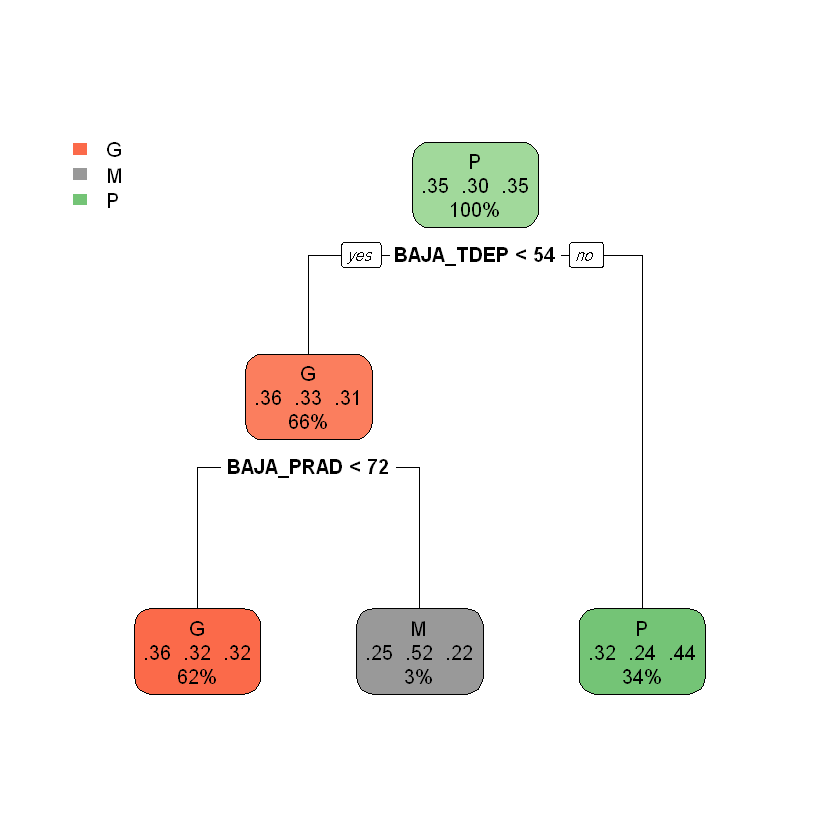

In [61]:
minitree = rpart(CATALTA ~ BAJA_PRAD + BAJA_TDEP + BAJA_IDEPMAY + BAJA_PRMAY,
               data = mcat.train,
               method = "class"
              )

rpart.plot(minitree)

In [62]:
minipred = predict(minitree, mcat.train, type = "class")

acc.class(minipred, mcat.train$CATALTA)

[1] 0.39425

In [63]:
minipred = predict(minitree, mcat.test, type = "class")

acc.class(minipred, mcat.test$CATALTA)

[1] 0.4

### Crear modelos con categoría binaria Grande vs. Pequeño

- Primer modelo -> 5 & 6 == Grande, el resto Pequeño
- Segundo modelo -> 4 & 5 & 6 == Grande, el resto Pequeño

In [14]:
# db_joined <- read.csv(choose.files())

# db_joined$MESVAR <- as.factor(db_joined$MESVAR)
# db_joined$CNAC <- as.factor(db_joined$CNAC)
# db_joined$BPROVNAC <- as.factor(db_joined$BPROVNAC)
# db_joined$TAMUBAJA <- as.factor(db_joined$TAMUBAJA)
# db_joined$ARRBAJA <- as.factor(db_joined$ARRBAJA)
# db_joined$TAMUALTA <- as.factor(db_joined$TAMUALTA)

# baja <- grepl("BAJA", names(db_joined), fixed = TRUE)

# baja_ind <- names(db_joined)[baja][-c(1,2,3)]

# selection <- c("SEXO","EDAD","MESVAR","CNAC","BPROVNAC","ARRALTA", # variables personales
#                baja_ind, # variables municipales de BAJA 
#                "TAMUALTA" # variable objetivo
#                 )
# db_joined <- db_joined[selection]

In [15]:
rows = sample(1:nrow(db_joined), 10000)
db.select <- db_joined[rows,]
rownames(db.select) <- NULL
# rm(db_joined)

In [16]:
db.select$ALTA_56 <- as.factor(ifelse(db.select$TAMUALTA == 5 | db.select$TAMUALTA == 6,
                                      "G", "P"))

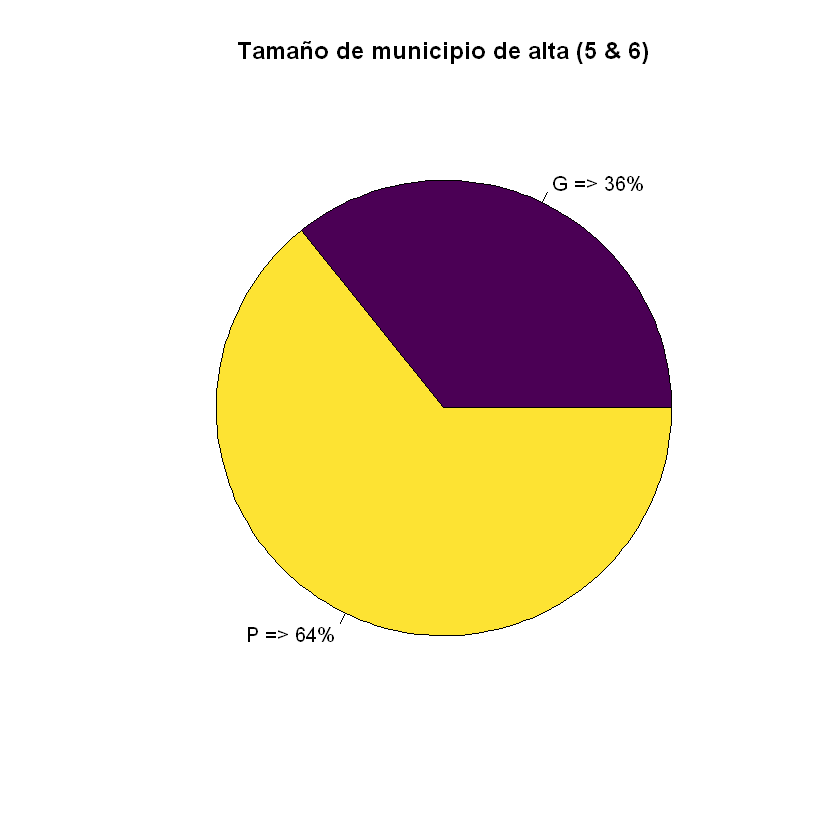

In [17]:
aux <- sort(table(db.select$ALTA_56))
aux <- as.data.frame(aux)

slices <- aux$Freq
lbl <- aux$Var1
pct <- round(slices/sum(slices)*100)
lbl <- paste(lbl, "=>", pct)
lbl <- paste(lbl,"%", sep="")
pie(slices, labels = lbl, col = hcl.colors(length(lbl)),
    main="Tamaño de municipio de alta (5 & 6)")

In [18]:
db.select$ALTA_456 <- as.factor(ifelse(db.select$TAMUALTA == 4 | db.select$TAMUALTA == 5 | db.select$TAMUALTA == 6,
                                      "G", "P"))

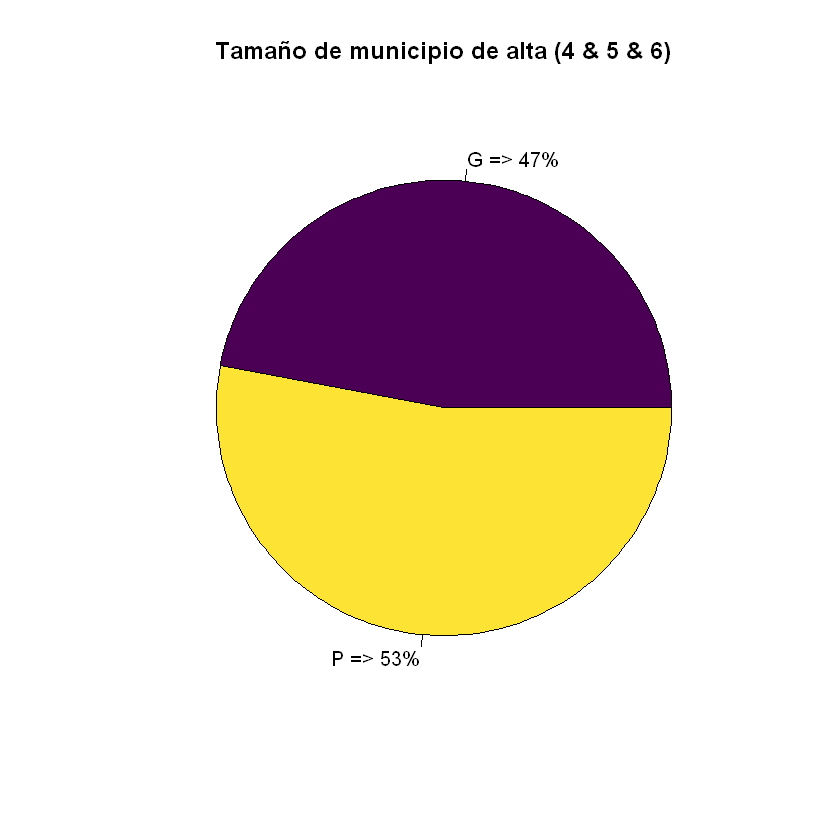

In [19]:
aux <- sort(table(db.select$ALTA_456))
aux <- as.data.frame(aux)

slices <- aux$Freq
lbl <- aux$Var1
pct <- round(slices/sum(slices)*100)
lbl <- paste(lbl, "=>", pct)
lbl <- paste(lbl,"%", sep="")
pie(slices, labels = lbl, col = hcl.colors(length(lbl)),
    main="Tamaño de municipio de alta (4 & 5 & 6)")

In [20]:
selection56 <- c("SEXO","EDAD","MESVAR","CNAC","BPROVNAC","ARRALTA", # variables personales
               baja_ind, # variables municipales de BAJA 
               "ALTA_56" # variable objetivo
               )

In [21]:
selection456 <- c("SEXO","EDAD","MESVAR","CNAC","BPROVNAC","ARRALTA", # variables personales
               baja_ind, # variables municipales de BAJA 
               "ALTA_456" # variable objetivo
               )

In [22]:
db_56 <- db.select[selection56]

n = nrow(db_56)

indtrain = sample(1:n, 0.8*n)     # 80% para train
indtest = setdiff(1:n, indtrain)  # 20% para test

db56.train = db_56[indtrain,]
rownames(db56.train) <- NULL

db56.test = db_56[indtest,]
rownames(db56.test) <- NULL

In [23]:
db_456 <- db.select[selection456]

n = nrow(db_456)

indtrain = sample(1:n, 0.8*n)     # 80% para train
indtest = setdiff(1:n, indtrain)  # 20% para test

db456.train = db_456[indtrain,]
rownames(db456.train) <- NULL

db456.test = db_456[indtest,]
rownames(db456.test) <- NULL

### Entrenar los árboles (Modelo 5 & 6 Grande):

In [26]:
r56 = rpart(ALTA_56~.,
               data = db56.train,
               method = "class",
               control = rpart.control(minsplit = 2, minbucket = 1, cp = 0)
              )

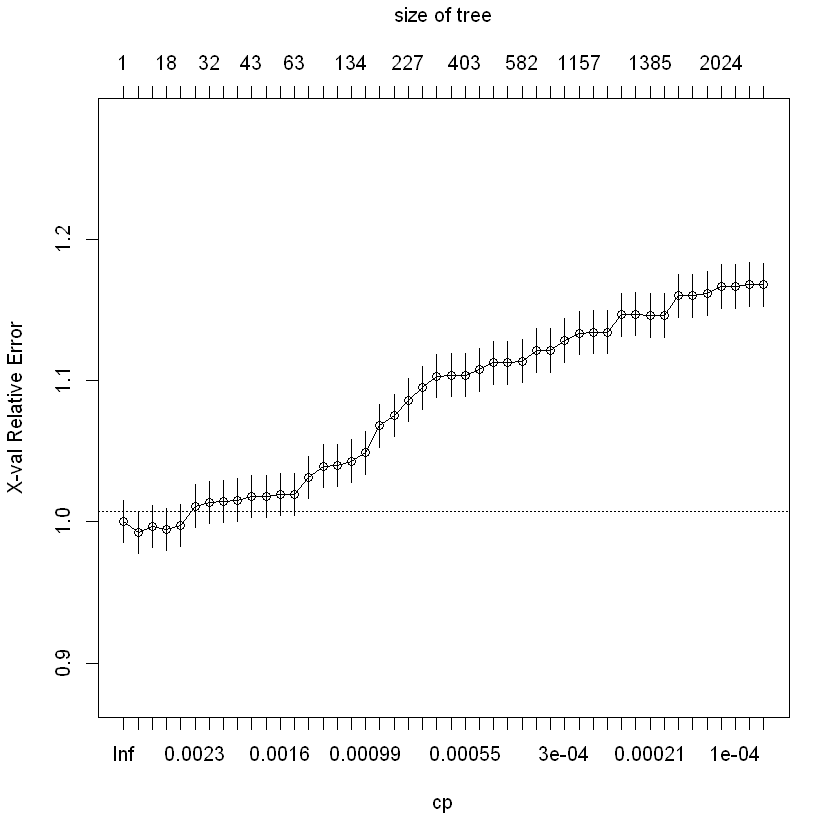

In [27]:
plotcp(r56)

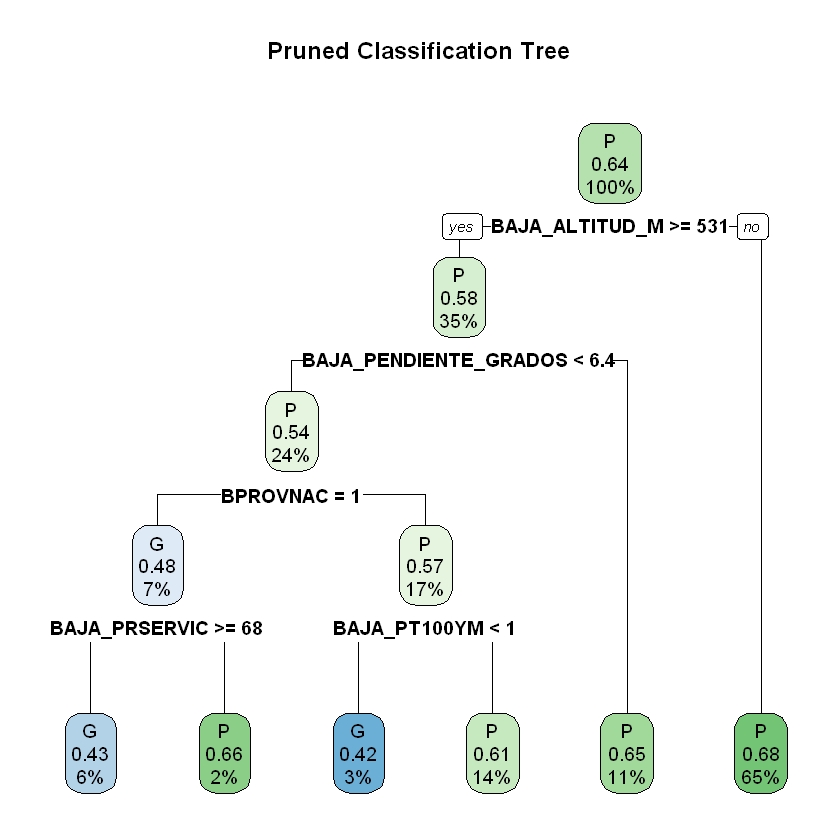

In [28]:
ptree56 <- prune(r56,
               cp = r56$cptable[which.min(r56$cptable[,"xerror"]),"CP"])

rpart.plot(ptree56, uniform=TRUE, main="Pruned Classification Tree")

In [29]:
pred.pruned = predict(ptree56, db56.train, type = "class")

acc.class(pred.pruned, db56.train$ALTA_56)

[1] 0.654125

In [30]:
pred.pruned = predict(ptree56, db56.test, type = "class")

acc.class(pred.pruned, db56.test$ALTA_56)

[1] 0.6445

### Entrenar los árboles (Modelo 4 & 5 & 6 Grande):

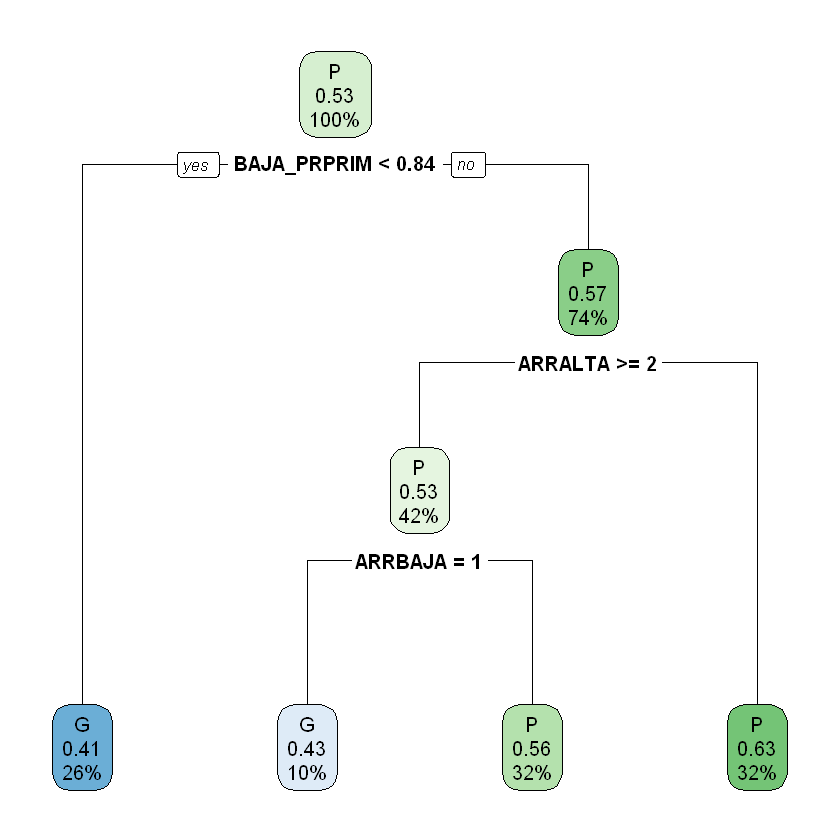

In [31]:
r456 = rpart(ALTA_456~.,
               data = db456.train,
               method = "class")

rpart.plot(r456)

In [32]:
pred = predict(r456, db456.train, type = "class")

acc.class(pred, db456.train$ALTA_456)

[1] 0.588625

In [33]:
pred = predict(r456, db456.test, type = "class")

acc.class(pred, db456.test$ALTA_456)

[1] 0.588

Crecer el completo y podar:

In [34]:
full456 = rpart(ALTA_456~.,
               data = db456.train,
               method = "class",
               control = rpart.control(minsplit = 2, minbucket = 1, cp = 0)
              )

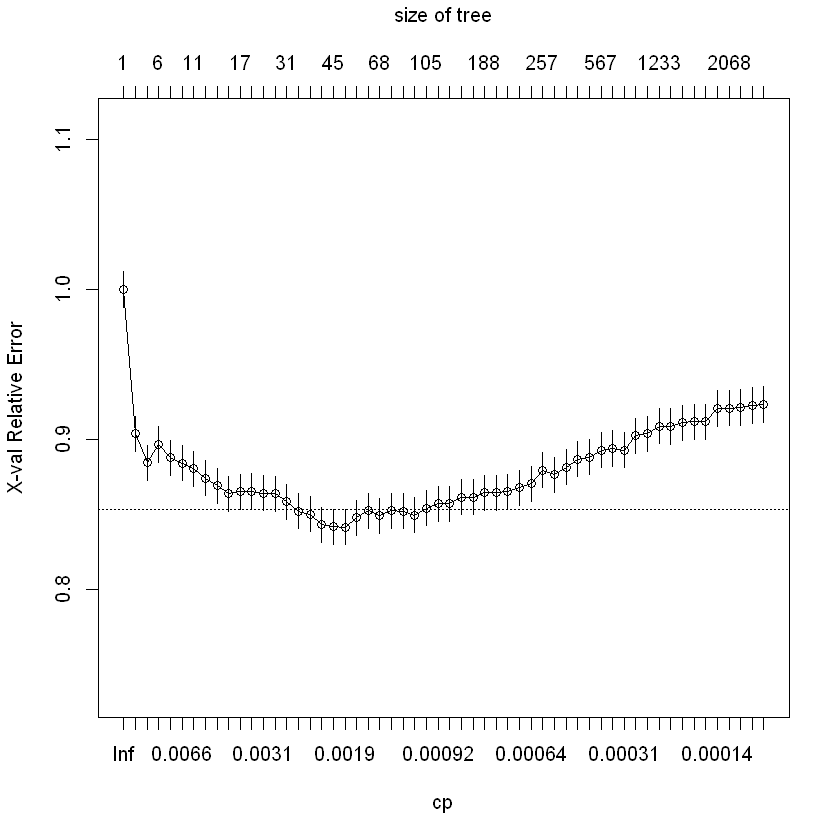

In [35]:
plotcp(full456)

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

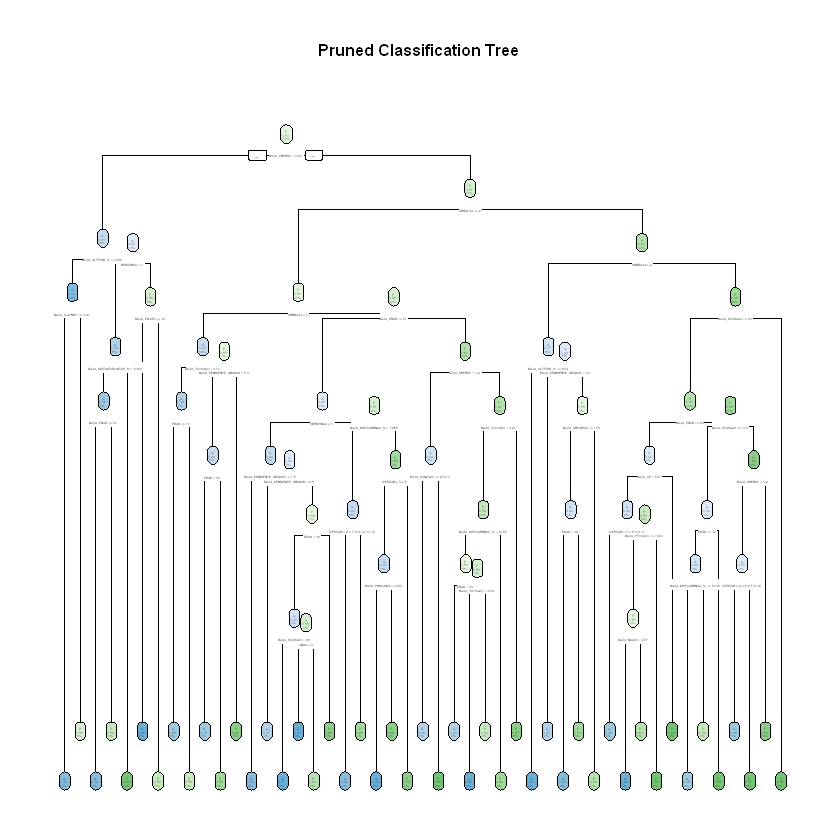

In [36]:
ptree456 <- prune(full456,
               cp = full456$cptable[which.min(full456$cptable[,"xerror"]),"CP"])

rpart.plot(ptree456, uniform=TRUE, main="Pruned Classification Tree")

In [37]:
pred.pruned = predict(ptree456, db456.train, type = "class")

acc.class(pred.pruned, db456.train$ALTA_456)

[1] 0.668375

In [38]:
pred.pruned = predict(ptree456, db456.test, type = "class")

acc.class(pred.pruned, db456.test$ALTA_456)

[1] 0.604

### Balancear la muestra para volver a aplicar este modelo:

In [39]:
G <- subset(db_456, ALTA_456 == "G")
P <- subset(db_456, ALTA_456 == "P")

ind <- sample(1:nrow(P), size=nrow(G))
P <- P[ind,]

db.bal.456 <- rbind(G,P)

db.bal.456 <- db.bal.456[sample(1:nrow(db.bal.456)), ]
rownames(db.bal.456) <- NULL

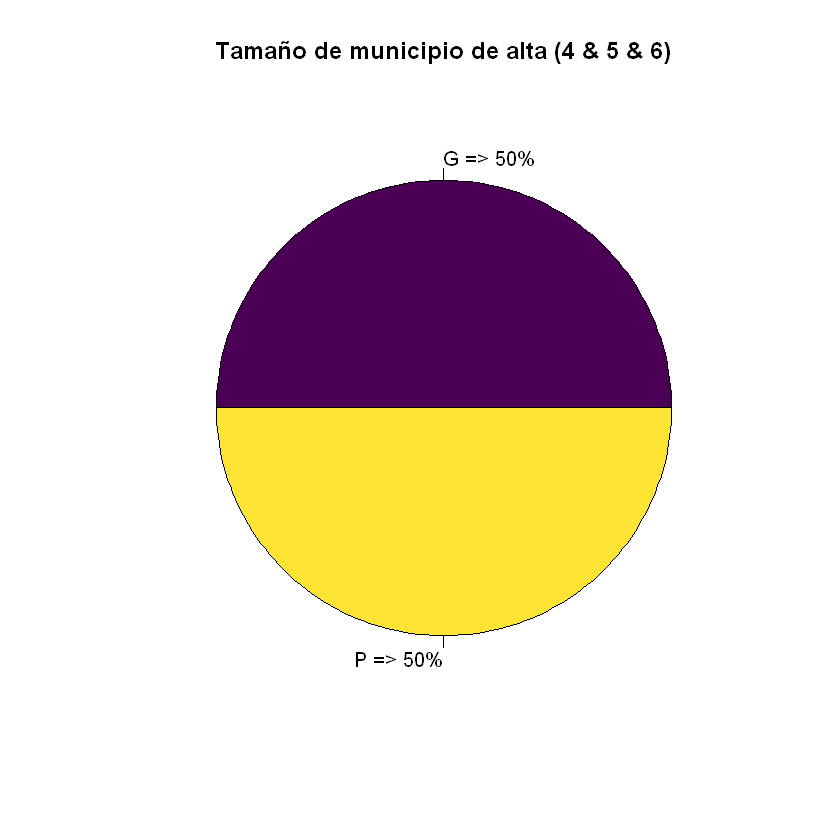

In [40]:
aux <- sort(table(db.bal.456$ALTA_456))
aux <- as.data.frame(aux)

slices <- aux$Freq
lbl <- aux$Var1
pct <- round(slices/sum(slices)*100)
lbl <- paste(lbl, "=>", pct)
lbl <- paste(lbl,"%", sep="")
pie(slices, labels = lbl, col = hcl.colors(length(lbl)),
    main="Tamaño de municipio de alta (4 & 5 & 6)")

In [41]:
n = nrow(db.bal.456)

indtrain = sample(1:n, 0.8*n)     # 80% para train
indtest = setdiff(1:n, indtrain)  # 20% para test

db.bal.456.train = db.bal.456[indtrain,]
rownames(db.bal.456.train) <- NULL

db.bal.456.test = db.bal.456[indtest,]
rownames(db.bal.456.test) <- NULL

In [42]:
full.bal.456 = rpart(ALTA_456~.,
               data = db.bal.456.train,
               method = "class",
               control = rpart.control(minsplit = 2, minbucket = 1, cp = 0)
                     )

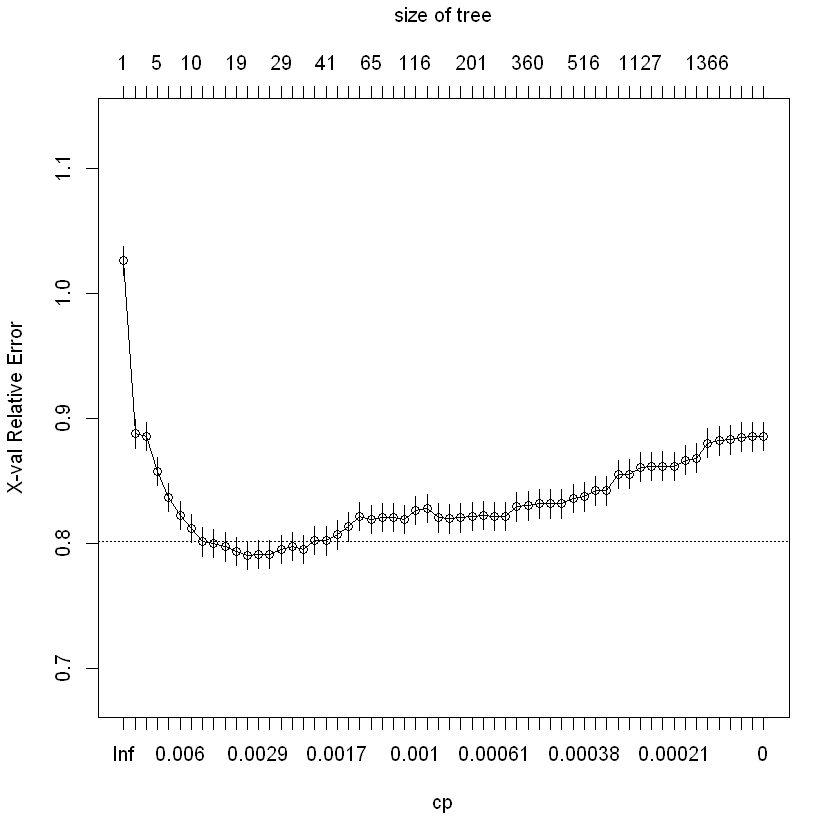

In [43]:
plotcp(full.bal.456)

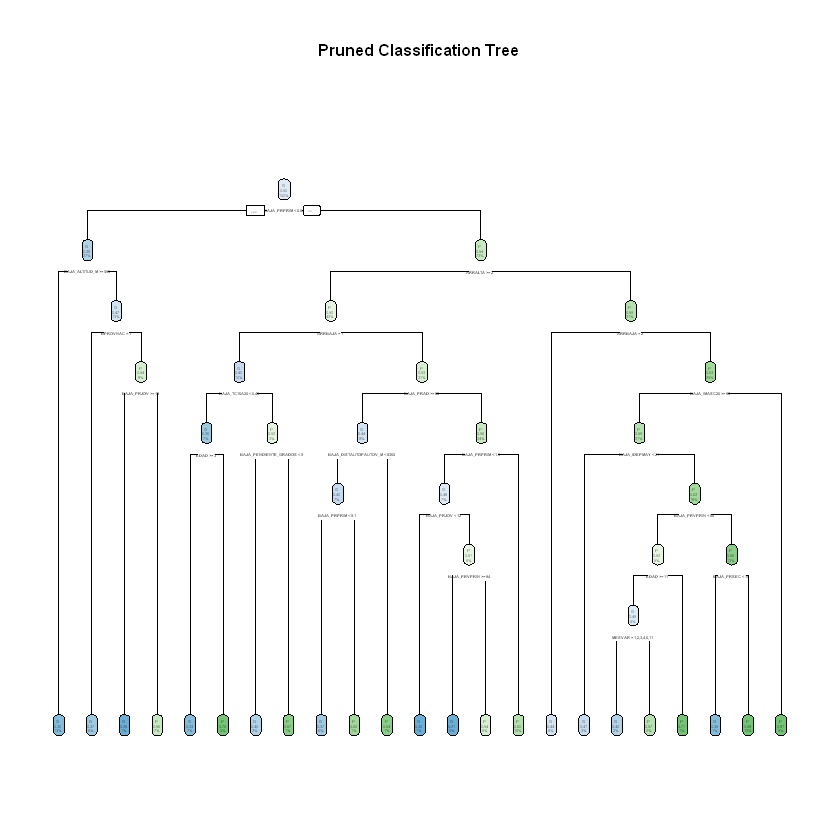

In [44]:
ptree.bal.456 <- prune(full.bal.456,
               cp = full.bal.456$cptable[which.min(full.bal.456$cptable[,"xerror"]),"CP"])

rpart.plot(ptree.bal.456, uniform=TRUE, main="Pruned Classification Tree")

In [45]:
pred.pruned = predict(ptree.bal.456, db.bal.456.train, type = "class")

acc.class(pred.pruned, db.bal.456.train$ALTA_456)

[1] 0.6359766

In [46]:
pred.pruned = predict(ptree.bal.456, db.bal.456.test, type = "class")

acc.class(pred.pruned, db.bal.456.test$ALTA_456)

[1] 0.5829787

In [47]:
ptree.bal.456$variable.importance

BAJA_PRPRIM          BAJA_PRVNPRIN           BAJA_PRVPRIN 
            86.7539371             63.9497902             63.9497902 
               ARRBAJA BAJA_DISTESTACFERROC_M           BAJA_IMASC20 
            59.0483156             53.9695833             41.2475658 
             BAJA_TDEP                ARRALTA              BAJA_PRAD 
            39.1605523             37.5223865             33.9648669 
          BAJA_IDEPMAY             BAJA_PRMAY         BAJA_RATINEDIF 
            33.7215157             32.3150912             31.7500427 
 BAJA_PENDIENTE_GRADOS         BAJA_ALTITUD_M           BAJA_POB2020 
            27.7928336             26.7527383             25.7674759 
            BAJA_PRJOV                BAJA_CV     BAJA_DISTCARRNAC_M 
            23.2192196             22.8287559             22.7521887 
              BPROVNAC                   EDAD           BAJA_IDEPJOV 
            21.5938559             18.0689402             17.8212504 
                  CNAC  BAJA_DISTAUTOPAUTOV_M               TAMUBAJA 
            15.8281973             14.9222249             14.0201639 
          BAJA_PT100YM           BAJA_TC16A20           BAJA_PT95A99 
            13.6285392             13.3479510             12.6886399 
          BAJA_PT90A94          BAJA_PRSERVIC             BAJA_PRSEC 
            12.2186903             10.1865214              9.8644502 
          BAJA_INVPERM           BAJA_PT65A69           BAJA_JUBPENS 
             6.0819042              5.5123516              5.4388835 
                MESVAR            BAJA_FALLEC           BAJA_PT70A74 
             5.2452884              4.8916074              4.8916074 
          BAJA_PT75A79          BAJA_PRIMARIO           BAJA_PT85A89 
             4.8916074              3.5850292              3.5188401 
          BAJA_PT80A84     BAJA_DISTNUC10KM_M              BAJA_OCTP 
             2.9808987              1.9151072              1.3067378 
          BAJA_INDUSTR             BAJA_JOVEN             BAJA_PT5A9 
             1.2133994              1.1200610              1.0267226 
          BAJA_AREAKM2            BAJA_OCUOTR             BAJA_PARPE 
             0.3097431              0.2072827              0.2072827 
        BAJA_SERVICIOS 
             0.1770451

## Random Forest

In [ ]:
library(randomForest)

In [49]:
rf <- randomForest(ALTA_456 ~ ., data = db.bal.456.train)

In [50]:
rf


Call:
 randomForest(formula = ALTA_456 ~ ., data = db.bal.456.train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 8

        OOB estimate of  error rate: 41.05%
Confusion matrix:
     G    P class.error
G 2133 1625   0.4324109
P 1460 2298   0.3885045

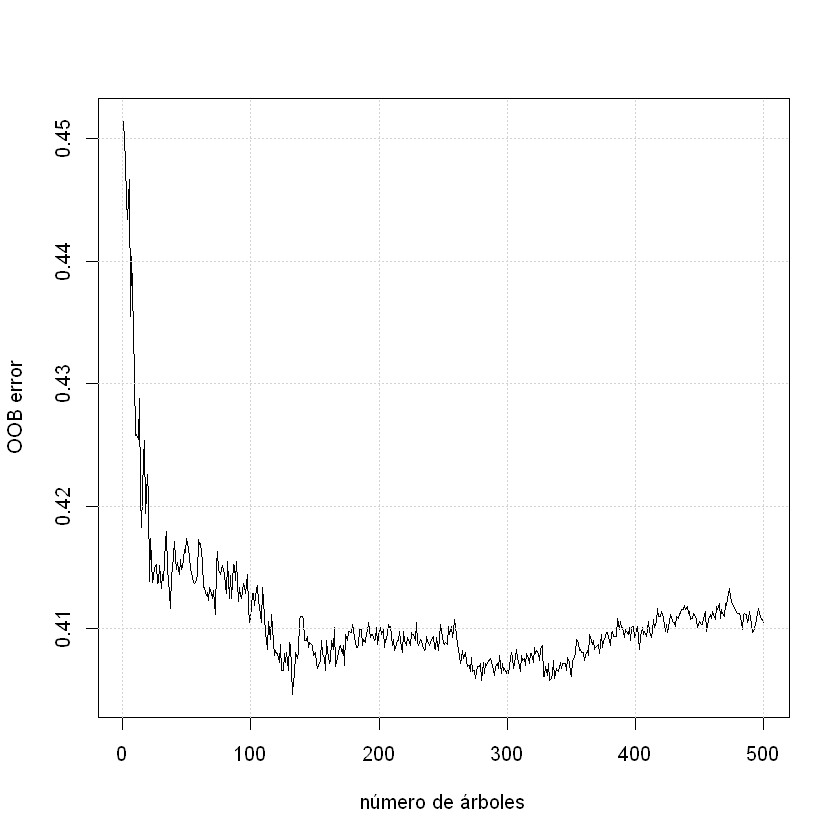

In [51]:
plot(rf$err.rate[, 1], type = "l", xlab = "número de árboles", ylab = "OOB error")
grid()

In [52]:
ntree.optim <- which.min(rf$err.rate[,1])
ntree.optim

[1] 132

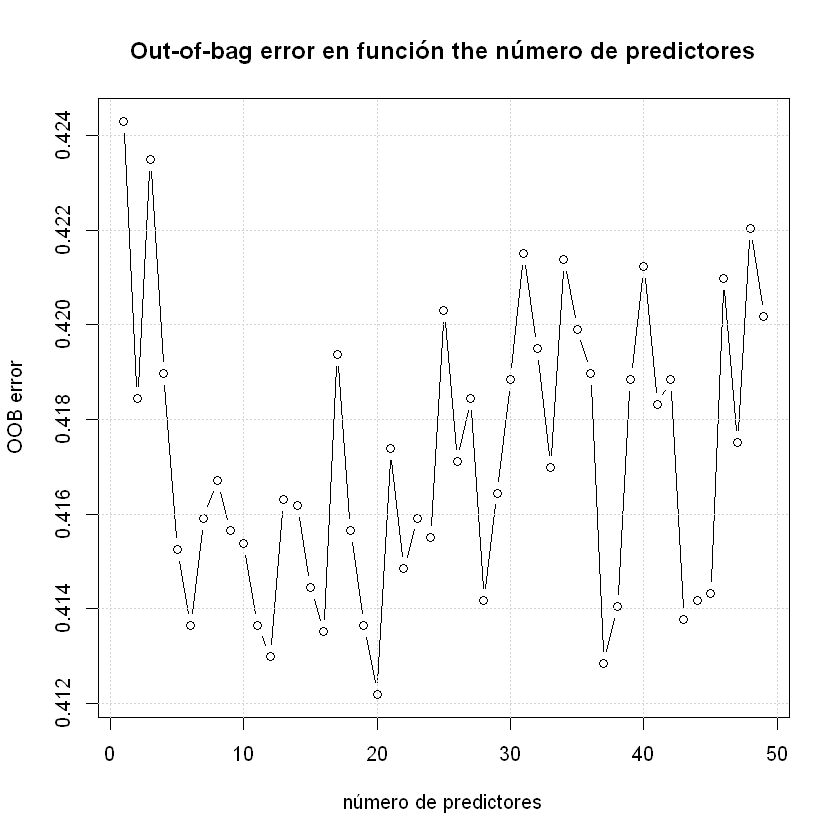

In [53]:
mtry.choices <- 2:50

err <- vector("numeric", length(mtry.choices))

for (i in 1:length(mtry.choices)) {
    
    rf1 <- randomForest(ALTA_456 ~., data = db.bal.456.train,
                        ntree = ntree.optim, mtry = mtry.choices[i])
    
    pred1 <- predict(rf1, db.bal.456.test, type = "class")
    
    err[i] <- rf1$err.rate[ntree.optim, 1]
}

plot(err, ty = "b", ylab = "OOB error", xlab = "número de predictores")
grid()
title(main = "Out-of-bag error en función the número de predictores")

In [54]:
mtry.best <- which.min(err)
mtry.best

[1] 20

In [55]:
rf.best <- randomForest(ALTA_456 ~., data = db.bal.456.train,
                        ntree = ntree.optim, mtry = mtry.best)

In [56]:
ntree.optim <- which.min(rf.best$err.rate[,1])
ntree.optim

[1] 105

In [ ]:
samp.choices <- c(0.1,0.3,0.5,0.7,0.8)*nrow(db.bal.456.train)

err <- vector("numeric", length(samp.choices))

for (i in 1:length(samp.choices)) {
    
    rf1 <- randomForest(ALTA_456 ~., data = db.bal.456.train,
                        ntree = ntree.optim, mtry = mtry.best,
                        sampsize = samp.choices[i])
    
    pred1 <- predict(rf1, db.bal.456.test, type = "class")
    
    err[i] <- rf1$err.rate[ntree.optim, 1]
}

plot(err, ty = "b", ylab = "OOB error", xlab = "tamaño de muestra")
grid()
title(main = "Out-of-bag error en función de tamaño de muestra")

Warning message in matrix(rfout$nodestatus, ncol = ntree):
"data length [157941] is not a sub-multiple or multiple of the number of rows [1505]"Warning message in matrix(rfout$bestvar, ncol = ntree):
"data length [157941] is not a sub-multiple or multiple of the number of rows [1505]"Warning message in matrix(rfout$nodepred, ncol = ntree):
"data length [157941] is not a sub-multiple or multiple of the number of rows [1505]"Warning message in matrix(rfout$xbestsplit, ncol = ntree):
"data length [157941] is not a sub-multiple or multiple of the number of rows [1505]"

In [ ]:
samp.optim <- which.min(err)
samp.optim

samp.choices

In [ ]:
nrow(db.bal.456.train)

In [ ]:
samp.optim <- 5141

In [ ]:
rf.best <- randomForest(ALTA_456 ~., data = db.bal.456.train,
                        importance = TRUE,
                        ntree = ntree.optim,
                        mtry = mtry.best,
                        sampsize = samp.optim
                       )

In [ ]:
varImpPlot(rf.best, type=1)

In [ ]:
barplot(sort(rf.best$importance[,3], decreasing = TRUE), ylab="MeanDecreaseAccuracy", main = "Importancia de predictores")
grid()

In [ ]:
par(mar=c(8, 4, 4, 2))
barplot(sort(rf.best$importance[,3],decreasing = TRUE)[1:10],
        las = 2,
        ylab = "MeanDecreaseAccuracy",
        main = "Importancia de 10 predictores")
grid()

In [ ]:
rfpred = predict(rf.best, db.bal.456.test, type = "class")

acc.class(rfpred, db.bal.456.test$ALTA_456)

## Boosting

In [ ]:
library(adabag)

In [ ]:
ab = boosting(ALTA_456 ~., db.bal.456.train, importance=TRUE)

In [ ]:
res <- errorevol(ab, db.bal.456.train)
plot(res)
grid()

In [ ]:
mfinal.optim <- which.min(res$error)
mfinal.optim

In [ ]:
### No volvemos a ejecutar, porque mfinal por defecto ha sido 100.
# ab = boosting(ALTA_456 ~., db.bal.456.train,
#              mfinal = mfinal.optim)

In [ ]:
for (i in c(1,10,20,60)) {
    plot(ab$trees[[i]], main=paste("árbol número ",i))
    text(ab$trees[[i]]) 
}

In [ ]:
barplot(sort(ab$importance, decreasing=TRUE), ylab="MeanDecreaseAccuracy", main = "Importancia de predictores")
grid()

In [ ]:
par(mar=c(15, 4, 4, 2))
barplot(sort(ab$importance, decreasing = TRUE)[1:10],
        las = 2,
        main = "importancia de 10 predictores")
grid()

In [ ]:
pred.ab = predict(ab, db.bal.456.test, type = "class")

acc.class(pred.ab$class, db.bal.456.test$ALTA_456)